In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd "gdrive/MyDrive/Colab Notebooks/VinBrain_Intern/W1/1. U-Net on SIIM dataset"

/content/gdrive/MyDrive/Colab Notebooks/VinBrain_Intern/W1/1. U-Net on SIIM dataset


In [3]:
# %cd "Dataset"
# !unzip "archive.zip"

In [4]:
# Import library
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

**Dataset**

In [5]:
# define a class to transform image
class ImageTransform():
  def __init__(self):
      self.data_transform = {
              'train': transforms.Compose([
                  transforms.ToTensor()
              ]),
              'val': transforms.Compose([
                  transforms.ToTensor()
              ])
          }
  def __call__(self, img, phase = 'train'):
      return self.data_transform[phase](img)

(256, 256)


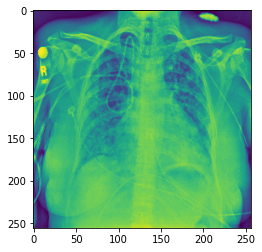

In [6]:
# demo transform an image
img_file_path = "./Dataset/train/1.2.276.0.7230010.3.1.4.8323329.7001.1517875202.297845.png"
img = Image.open(img_file_path)
image_2_npArray = np.asarray(img)
print(np.shape(image_2_npArray))
plt.imshow(img)
plt.show()

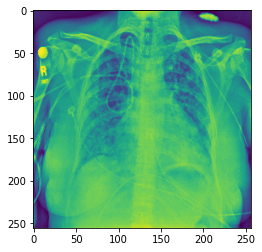

In [7]:
# after transforming an image in dataset
transform = ImageTransform()
img_transformed = transform(img)
img_transformed = np.clip(img_transformed, 0, 1)
img_transformed = img_transformed.view(256, 256)
plt.imshow(img_transformed)

In [8]:
def make_datapath_list(phase = "train"):
    root_path = "./Dataset/"
    target_path = osp.join(root_path + phase + "/*.png")
    path_list = []  
    for path in glob.glob(target_path):
        path_list.append(path)
    return sorted(path_list)

In [9]:
# Test make_datapath_list
image_train_list = len(make_datapath_list())
print(image_train_list)
top10datapath = make_datapath_list()[:10]
top10datapath

12047


['./Dataset/train/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10003.1517875220.942420.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10004.1517875220.929537.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10005.1517875220.958951.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10006.1517875220.954474.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10007.1517875220.954767.png',
 './Dataset/train/1.2.276.0.7230010.3.1.4.8323329.10008.1517875220.957633.png']

In [10]:
image_masks_list = len(make_datapath_list("masks"))
print(image_masks_list)
top10MaskDatapath = make_datapath_list("masks")[:10]
top10MaskDatapath

12047


['./Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10003.1517875220.942420.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10004.1517875220.929537.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10005.1517875220.958951.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10006.1517875220.954474.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10007.1517875220.954767.png',
 './Dataset/masks/1.2.276.0.7230010.3.1.4.8323329.10008.1517875220.957633.png']

In [11]:
# create dataset
class ImageDataset(data.Dataset):
    def __init__(self, image_list, mask_list, transform = None, phase = "train"):
        self.image_list = image_list
        self.mask_list = mask_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        mask_path = self.mask_list[idx]
        img = Image.open(image_path)
        mask = Image.open(mask_path)

        img_transformed = self.transform(img, self.phase)
        mask_transformed = self.transform(mask, self.phase)
    
        return img_transformed, mask_transformed

In [12]:
# create dataloader
img_train = make_datapath_list()
mask_train = make_datapath_list("masks")

transformed_dataset = ImageDataset(image_list = img_train, mask_list = mask_train, transform = transform)

train_len = int(0.8 * len(transformed_dataset))
validation_len = len(transformed_dataset) - train_len

train_data, val_data = data.dataset.random_split(transformed_dataset,[train_len, validation_len])

train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True, num_workers = 4)
val_dataloader = DataLoader(val_data, batch_size = 32, shuffle = False, num_workers = 4)

In [13]:
print(len(train_data))
print(len(val_data))

9637
2410


In [14]:
# Test Dataloader
print(next(iter(train_dataloader)))
input_batch_matrix = torch.FloatTensor(next(iter(train_dataloader))[1])
image_batch_matrix = torch.FloatTensor(next(iter(train_dataloader))[0])
print(input_batch_matrix.size())
# -> each batch consists of (tensor of image, tensor of masks)

[tensor([[[[0.4471, 0.2784, 0.1451,  ..., 0.0745, 0.0745, 0.0784],
          [0.4353, 0.2667, 0.1373,  ..., 0.0431, 0.0471, 0.0549],
          [0.4471, 0.2588, 0.1373,  ..., 0.0314, 0.0314, 0.0392],
          ...,
          [0.4039, 0.3647, 0.3451,  ..., 0.0471, 0.0902, 0.1333],
          [0.4353, 0.4039, 0.3804,  ..., 0.0471, 0.0784, 0.1255],
          [0.4784, 0.4471, 0.4314,  ..., 0.0392, 0.0784, 0.1216]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.2549, 0.2549, 0.2549],
          [0.0000, 0.0000, 0.0000,  ..., 0.2549, 0.2549, 0.2549],
          [0.0000, 0.0000, 0.0000,  ..., 0.2549, 0.2549, 0.2549],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2275, 0.2275, 0.2275],
          [0.0000, 0.0000, 0.0000,  ..., 0.2275, 0.2275, 0.2275],
          [0.0000, 0.0000, 0.0000,  ..., 0.1961, 0.1961, 0.1961]]],


        [[[0.0510, 0.1569, 0.1216,  ..., 0.0431, 0.0431, 0.0549],
          [0.0549, 0.1922, 0.1725,  ..., 0.0431, 0.0431, 0.0549],
          [0.0745, 0.1647, 0.1765,  .

In [15]:
def show(img, mask):
    grid_img = torchvision.utils.make_grid(img, nrow=16)
    plt.figure()
    plt.imshow(grid_img.permute(1, 2, 0))

    grid_img_1 = torchvision.utils.make_grid(mask, nrow=16)
    plt.figure()
    plt.imshow(grid_img_1.permute(1, 2, 0))

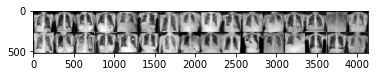

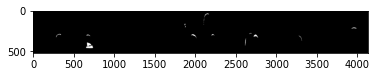

In [16]:
show(image_batch_matrix, input_batch_matrix)

In [17]:
index = 0
# print(train_dataset.__len__())
img, mask = transformed_dataset.__getitem__(index)
print(img.shape)
print(mask)
# img and mask matrix have the same shape 

torch.Size([1, 256, 256])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


**U - Net**

In [18]:
# (conv_layer1 -> BatchNorm -> ReLU) -> (conv_layer2 -> BatchNorm -> ReLU)
class ContractingPathModule(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(ContractingPathModule, self).__init__()
        self.in_chan = in_chan
        self.out_chan = out_chan
        self.conv = nn.Sequential(
            nn.Conv2d(self.in_chan, 
                      self.out_chan, 
                      kernel_size = 3, 
                      stride = 1, 
                      padding = 1, 
                      bias = True),
            nn.ReLU(),
            nn.Conv2d(self.out_chan, 
                      self.out_chan, 
                      kernel_size = 3, 
                      stride = 1, 
                      padding = 1, 
                      bias = True),
            nn.ReLU()
        )
    def forward(self, input):
        return self.conv(input)

In [19]:
  # conv_2d_transpose -> similar to contracting part
  class ExpansivePathModule(nn.Module):
      def __init__(self, in_chan, out_chan):
          super(ExpansivePathModule, self).__init__()
          self.in_chan = in_chan
          self.out_chan = out_chan
          self.conv = nn.Sequential(
              nn.Conv2d(self.out_chan, 
                        self.out_chan, 
                        kernel_size = 3, 
                        stride = 1, 
                        padding = 1, 
                        bias = True),
              nn.ReLU()
          )
          self.upConv = nn.ConvTranspose2d(self.in_chan, 
                                           self.out_chan, 
                                           kernel_size = 2, 
                                           stride = 2)
      def forward(self, input):
          input = self.upConv(input)
          return self.conv(input)


In [20]:
# I now have train_dataloader. Start build a UNet
class UNet(nn.Module):
      def __init__(self, n_channels, n_classes):
          super(UNet, self).__init__()
          self.n_channels = n_channels
          self.n_classes = n_classes

          # Left-side structure of UNet
          self.moduleContract1 = ContractingPathModule(self.n_channels, 64)
          self.moduleContract2 = ContractingPathModule(64, 128)
          self.moduleContract3 = ContractingPathModule(128, 256)
          self.moduleContract4 = ContractingPathModule(256, 512)
          self.moduleContract5 = ContractingPathModule(512, 1024)

          # Right-side structure of UNet
          self.moduleExpansive1 = ExpansivePathModule(1024, 512)
          self.Up_conv5 = ContractingPathModule(1024, 512)

          self.moduleExpansive2 = ExpansivePathModule(512, 256)
          self.Up_conv4 = ContractingPathModule(512, 256)
          
          self.moduleExpansive3 = ExpansivePathModule(256, 128)
          self.Up_conv3 = ContractingPathModule(256, 128)
          
          self.moduleExpansive4 = ExpansivePathModule(128, 64)
          self.Up_conv2 = ContractingPathModule(128, 64)

          # # Final Layer
          self.out_layer = nn.Sequential(
                              nn.Conv2d(64, 2, kernel_size = 3, stride = 1),
                              nn.ReLU(),
                              nn.Conv2d(2, 
                                     self.n_classes,  
                                     kernel_size = 1, 
                                     stride = 1, 
                                     padding = 1
                              ),
                              nn.Sigmoid()
          )

      def forward(self, input):
          # Stage 1
          conv_1 = self.moduleContract1(input)
          pool_1 = nn.MaxPool2d(kernel_size = 2, stride = 2)(conv_1)
          
          conv_2 = self.moduleContract2(pool_1)
          pool_2 =  nn.MaxPool2d(kernel_size = 2, stride = 2)(conv_2)
          
          conv_3 =  self.moduleContract3(pool_2)
          pool_3 =  nn.MaxPool2d(kernel_size = 2, stride = 2)(conv_3)
          
          conv_4 =  self.moduleContract4(pool_3)
          drop_4 = nn.Dropout(0.5)(conv_4)
          pool_4 =  nn.MaxPool2d(kernel_size = 2, stride = 2)(drop_4)
          
          conv_5 = self.moduleContract5(pool_4)
          drop_5 = nn.Dropout(0.5)(conv_5)
    
          # Stage 2
          x_6 = self.moduleExpansive1(drop_5)
          x_6 = torch.cat((drop_4, x_6), dim = 1)
          x_6 = self.Up_conv5(x_6)
        
          x_7 = self.moduleExpansive2(x_6)
          x_7 = torch.cat((conv_3, x_7), dim = 1)
          x_7 = self.Up_conv4(x_7)
          

          x_8 = self.moduleExpansive3(x_7)
          x_8 = torch.cat((conv_2, x_8), dim = 1)
          x_8 = self.Up_conv3(x_8)

          x_9 = self.moduleExpansive4(x_8)
          x_9 = torch.cat((conv_1, x_9), dim = 1)
          x_9 = self.Up_conv2(x_9)
          
          # Final Stage
          output = self.out_layer(x_9)
          return output

In [21]:
# net = UNet(n_channels = 1, n_classes = 1)
# input = torch.rand(4, 1, 256, 256)
# pred = net(input)
# pred.size()

In [22]:
# print(net)

**TRAIN MODEL**

In [23]:
# hyper parameter
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(n_channels = 1, n_classes = 1)
optimizer = optim.Adam(net.parameters(), lr = 1e-4)

In [24]:
net.to(device = device)

UNet(
  (moduleContract1): ContractingPathModule(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (moduleContract2): ContractingPathModule(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (moduleContract3): ContractingPathModule(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (moduleContract4): ContractingPathModule(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(5

In [25]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
pytorch_total_params 

34166085

In [26]:
def accuracy_check_iou(mask, prediction):
    target = mask.detach().cpu().numpy()
    prediction = prediction.detach().cpu().numpy()

    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    
    return iou_score

In [27]:
def accuracy_check_for_batch(masks, predictions, batch_size):
    total_acc = 0
    for index in range(batch_size):
        total_acc += accuracy_check_iou(masks[index], predictions[index])
    return total_acc / batch_size

In [ ]:
# Train model with dataset
for epoch in range(20):
    print("Epoch {}/{}".format(epoch, num_epochs))
    net.train()
    epoch_loss = 0.0
    accuracy = 0
    for image, masks in tqdm(train_dataloader):
        optimizer.zero_grad()
        image = image.to(device = device, dtype = torch.float32)
        masks = masks.to(device = device, dtype = torch.float32)
        masks = (masks > 0.5).float()
        masks_pred = net(image)
        loss = F.binary_cross_entropy(masks_pred, masks)
        prediction = (masks_pred > 0.5).float()
        print("IoU_score: ", accuracy_check_for_batch(masks, prediction, image.size(0)))
        accuracy += accuracy_check_for_batch(masks, prediction, image.size(0))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
            
    epoch_loss = epoch_loss / len(train_dataloader)
    print("Train Loss: {:.4f}".format(epoch_loss))
    print("Accuracy After Epoch: ", accuracy / len(train_dataloader))
    if (epoch == 19):
      torch.save({
              'epoch': epoch,
              'model_state_dict': net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': epoch_loss,
            }, "./ckpts/checkpoint_{:d}.pt".format(epoch))


  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 0/2



  0%|          | 1/302 [00:00<03:59,  1.26it/s]

IoU_score:  0.0



  1%|          | 2/302 [00:01<04:15,  1.18it/s]

IoU_score:  0.0



  1%|          | 3/302 [00:02<04:27,  1.12it/s]

IoU_score:  0.0



  1%|▏         | 4/302 [00:03<04:35,  1.08it/s]

IoU_score:  0.0



  2%|▏         | 5/302 [00:04<04:40,  1.06it/s]

IoU_score:  0.0



  2%|▏         | 6/302 [00:05<04:43,  1.04it/s]

IoU_score:  0.0



  2%|▏         | 7/302 [00:06<04:46,  1.03it/s]

IoU_score:  0.0



  3%|▎         | 8/302 [00:07<04:47,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 9/302 [00:08<04:47,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 10/302 [00:09<04:47,  1.02it/s]

IoU_score:  0.0



  4%|▎         | 11/302 [00:10<04:47,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 12/302 [00:11<04:46,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 13/302 [00:12<04:46,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 14/302 [00:13<04:46,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 15/302 [00:14<04:45,  1.01it/s]

IoU_score:  5.165289256198347e-05



  5%|▌         | 16/302 [00:15<04:44,  1.00it/s]

IoU_score:  0.0



  6%|▌         | 17/302 [00:16<04:43,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 18/302 [00:17<04:42,  1.01it/s]

IoU_score:  0.0



  6%|▋         | 19/302 [00:18<04:41,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 20/302 [00:19<04:40,  1.00it/s]

IoU_score:  0.0



  7%|▋         | 21/302 [00:20<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 22/302 [00:21<04:38,  1.00it/s]

IoU_score:  4.9676769817719373e-05



  8%|▊         | 23/302 [00:22<04:37,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 24/302 [00:23<04:35,  1.01it/s]

IoU_score:  0.00018406413612565445



  8%|▊         | 25/302 [00:24<04:35,  1.01it/s]

IoU_score:  2.898886827458256e-05



  9%|▊         | 26/302 [00:25<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 27/302 [00:26<04:33,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 28/302 [00:27<04:32,  1.00it/s]

IoU_score:  0.0



 10%|▉         | 29/302 [00:28<04:32,  1.00it/s]

IoU_score:  0.0



 10%|▉         | 30/302 [00:29<04:30,  1.00it/s]

IoU_score:  0.0



 10%|█         | 31/302 [00:30<04:29,  1.00it/s]

IoU_score:  0.0



 11%|█         | 32/302 [00:31<04:28,  1.00it/s]

IoU_score:  0.0



 11%|█         | 33/302 [00:32<04:28,  1.00it/s]

IoU_score:  0.0



 11%|█▏        | 34/302 [00:33<04:26,  1.00it/s]

IoU_score:  0.0



 12%|█▏        | 35/302 [00:34<04:26,  1.00it/s]

IoU_score:  0.0



 12%|█▏        | 36/302 [00:35<04:25,  1.00it/s]

IoU_score:  0.0



 12%|█▏        | 37/302 [00:36<04:23,  1.00it/s]

IoU_score:  0.0



 13%|█▎        | 38/302 [00:37<04:23,  1.00it/s]

IoU_score:  0.0



 13%|█▎        | 39/302 [00:38<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 40/302 [00:39<04:20,  1.00it/s]

IoU_score:  0.0



 14%|█▎        | 41/302 [00:40<04:19,  1.01it/s]

IoU_score:  7.41223908918406e-05



 14%|█▍        | 42/302 [00:41<04:18,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 43/302 [00:42<04:17,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 44/302 [00:43<04:16,  1.01it/s]

IoU_score:  8.636573007830493e-05



 15%|█▍        | 45/302 [00:44<04:15,  1.01it/s]

IoU_score:  0.0



 15%|█▌        | 46/302 [00:45<04:14,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 47/302 [00:46<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 48/302 [00:47<04:12,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 49/302 [00:48<04:12,  1.00it/s]

IoU_score:  0.0



 17%|█▋        | 50/302 [00:49<04:11,  1.00it/s]

IoU_score:  0.0



 17%|█▋        | 51/302 [00:50<04:09,  1.00it/s]

IoU_score:  0.0



 17%|█▋        | 52/302 [00:51<04:09,  1.00it/s]

IoU_score:  0.0



 18%|█▊        | 53/302 [00:52<04:07,  1.00it/s]

IoU_score:  0.0



 18%|█▊        | 54/302 [00:53<04:06,  1.00it/s]

IoU_score:  6.716818914562064e-05



 18%|█▊        | 55/302 [00:54<04:05,  1.00it/s]

IoU_score:  0.0



 19%|█▊        | 56/302 [00:55<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 57/302 [00:56<04:03,  1.00it/s]

IoU_score:  0.0



 19%|█▉        | 58/302 [00:57<04:02,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 59/302 [00:58<04:01,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 60/302 [00:59<04:00,  1.00it/s]

IoU_score:  0.0



 20%|██        | 61/302 [01:00<03:59,  1.01it/s]

IoU_score:  0.0



 21%|██        | 62/302 [01:01<03:59,  1.00it/s]

IoU_score:  0.0



 21%|██        | 63/302 [01:02<03:57,  1.01it/s]

IoU_score:  0.0



 21%|██        | 64/302 [01:03<03:56,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 65/302 [01:04<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 66/302 [01:05<03:54,  1.01it/s]

IoU_score:  5.0180650341228424e-05



 22%|██▏       | 67/302 [01:06<03:53,  1.01it/s]

IoU_score:  6.169792694965449e-05



 23%|██▎       | 68/302 [01:07<03:52,  1.00it/s]

IoU_score:  0.0



 23%|██▎       | 69/302 [01:08<03:52,  1.00it/s]

IoU_score:  0.0



 23%|██▎       | 70/302 [01:09<03:51,  1.00it/s]

IoU_score:  0.0



 24%|██▎       | 71/302 [01:10<03:50,  1.00it/s]

IoU_score:  0.0



 24%|██▍       | 72/302 [01:11<03:48,  1.00it/s]

IoU_score:  0.0



 24%|██▍       | 73/302 [01:12<03:47,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 74/302 [01:13<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 75/302 [01:14<03:45,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 76/302 [01:15<03:44,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 77/302 [01:16<03:43,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 78/302 [01:17<03:42,  1.01it/s]

IoU_score:  0.00020645645645645644



 26%|██▌       | 79/302 [01:18<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▋       | 80/302 [01:19<03:40,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 81/302 [01:20<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 82/302 [01:21<03:38,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 83/302 [01:22<03:37,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 84/302 [01:23<03:36,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 85/302 [01:24<03:36,  1.00it/s]

IoU_score:  0.0



 28%|██▊       | 86/302 [01:25<03:35,  1.00it/s]

IoU_score:  0.0



 29%|██▉       | 87/302 [01:26<03:33,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 88/302 [01:27<03:32,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 89/302 [01:28<03:32,  1.00it/s]

IoU_score:  0.0



 30%|██▉       | 90/302 [01:29<03:30,  1.01it/s]

IoU_score:  0.0



 30%|███       | 91/302 [01:30<03:30,  1.00it/s]

IoU_score:  0.0



 30%|███       | 92/302 [01:31<03:28,  1.00it/s]

IoU_score:  0.0



 31%|███       | 93/302 [01:32<03:28,  1.00it/s]

IoU_score:  0.0



 31%|███       | 94/302 [01:33<03:27,  1.00it/s]

IoU_score:  0.0



 31%|███▏      | 95/302 [01:34<03:26,  1.00it/s]

IoU_score:  0.0



 32%|███▏      | 96/302 [01:35<03:25,  1.00it/s]

IoU_score:  0.0



 32%|███▏      | 97/302 [01:36<03:24,  1.00it/s]

IoU_score:  0.0



 32%|███▏      | 98/302 [01:37<03:22,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 99/302 [01:38<03:21,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 100/302 [01:39<03:20,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 101/302 [01:40<03:19,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 102/302 [01:41<03:18,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 103/302 [01:42<03:17,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 104/302 [01:43<03:17,  1.00it/s]

IoU_score:  0.0



 35%|███▍      | 105/302 [01:44<03:15,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 106/302 [01:45<03:15,  1.00it/s]

IoU_score:  0.0



 35%|███▌      | 107/302 [01:46<03:14,  1.00it/s]

IoU_score:  0.0



 36%|███▌      | 108/302 [01:47<03:13,  1.00it/s]

IoU_score:  0.0



 36%|███▌      | 109/302 [01:48<03:12,  1.00it/s]

IoU_score:  0.0



 36%|███▋      | 110/302 [01:49<03:11,  1.00it/s]

IoU_score:  0.0



 37%|███▋      | 111/302 [01:50<03:10,  1.00it/s]

IoU_score:  0.0



 37%|███▋      | 112/302 [01:51<03:09,  1.00it/s]

IoU_score:  0.0



 37%|███▋      | 113/302 [01:52<03:08,  1.00it/s]

IoU_score:  0.0



 38%|███▊      | 114/302 [01:53<03:07,  1.00it/s]

IoU_score:  0.0



 38%|███▊      | 115/302 [01:54<03:06,  1.00it/s]

IoU_score:  0.0



 38%|███▊      | 116/302 [01:55<03:05,  1.00it/s]

IoU_score:  0.00017179769103903243



 39%|███▊      | 117/302 [01:56<03:04,  1.00it/s]

IoU_score:  0.0



 39%|███▉      | 118/302 [01:57<03:03,  1.00it/s]

IoU_score:  0.0



 39%|███▉      | 119/302 [01:58<03:02,  1.00it/s]

IoU_score:  0.0



 40%|███▉      | 120/302 [01:59<03:01,  1.00it/s]

IoU_score:  0.0



 40%|████      | 121/302 [02:00<03:00,  1.00it/s]

IoU_score:  0.0



 40%|████      | 122/302 [02:01<02:59,  1.00it/s]

IoU_score:  0.0



 41%|████      | 123/302 [02:02<02:58,  1.00it/s]

IoU_score:  0.0



 41%|████      | 124/302 [02:03<02:56,  1.01it/s]

IoU_score:  1.496647509578544e-05



 41%|████▏     | 125/302 [02:04<02:55,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 126/302 [02:05<02:54,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 127/302 [02:06<02:54,  1.00it/s]

IoU_score:  0.0



 42%|████▏     | 128/302 [02:07<02:52,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 129/302 [02:08<02:51,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 130/302 [02:09<02:51,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 131/302 [02:10<02:50,  1.00it/s]

IoU_score:  0.0



 44%|████▎     | 132/302 [02:11<02:49,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 133/302 [02:12<02:48,  1.00it/s]

IoU_score:  0.0



 44%|████▍     | 134/302 [02:13<02:47,  1.01it/s]

IoU_score:  0.0



 45%|████▍     | 135/302 [02:14<02:46,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 136/302 [02:15<02:45,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 137/302 [02:16<02:43,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 138/302 [02:17<02:42,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 139/302 [02:18<02:41,  1.01it/s]

IoU_score:  0.0



 46%|████▋     | 140/302 [02:19<02:41,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 141/302 [02:20<02:39,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 142/302 [02:21<02:38,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 143/302 [02:22<02:37,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 144/302 [02:23<02:37,  1.01it/s]

IoU_score:  0.00013643528520371792



 48%|████▊     | 145/302 [02:24<02:35,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 146/302 [02:25<02:34,  1.01it/s]

IoU_score:  0.0



 49%|████▊     | 147/302 [02:26<02:34,  1.00it/s]

IoU_score:  0.0



 49%|████▉     | 148/302 [02:27<02:33,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 149/302 [02:28<02:32,  1.01it/s]

IoU_score:  0.0



 50%|████▉     | 150/302 [02:29<02:31,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 151/302 [02:30<02:30,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 152/302 [02:31<02:29,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 153/302 [02:32<02:28,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 154/302 [02:33<02:27,  1.00it/s]

IoU_score:  0.0



 51%|█████▏    | 155/302 [02:34<02:26,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 156/302 [02:35<02:25,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 157/302 [02:35<02:23,  1.01it/s]

IoU_score:  4.922713399625874e-05



 52%|█████▏    | 158/302 [02:36<02:23,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 159/302 [02:37<02:22,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 160/302 [02:38<02:21,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 161/302 [02:39<02:20,  1.01it/s]

IoU_score:  0.0



 54%|█████▎    | 162/302 [02:40<02:19,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 163/302 [02:41<02:18,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 164/302 [02:42<02:17,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 165/302 [02:43<02:16,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 166/302 [02:44<02:15,  1.01it/s]

IoU_score:  0.0



 55%|█████▌    | 167/302 [02:45<02:14,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 168/302 [02:46<02:13,  1.00it/s]

IoU_score:  0.0



 56%|█████▌    | 169/302 [02:47<02:12,  1.00it/s]

IoU_score:  0.0



 56%|█████▋    | 170/302 [02:48<02:11,  1.00it/s]

IoU_score:  0.0



 57%|█████▋    | 171/302 [02:49<02:10,  1.00it/s]

IoU_score:  0.0



 57%|█████▋    | 172/302 [02:50<02:09,  1.00it/s]

IoU_score:  0.0



 57%|█████▋    | 173/302 [02:51<02:08,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 174/302 [02:52<02:07,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 175/302 [02:53<02:06,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 176/302 [02:54<02:05,  1.01it/s]

IoU_score:  0.0



 59%|█████▊    | 177/302 [02:55<02:04,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 178/302 [02:56<02:03,  1.00it/s]

IoU_score:  0.0



 59%|█████▉    | 179/302 [02:57<02:02,  1.00it/s]

IoU_score:  0.0



 60%|█████▉    | 180/302 [02:58<02:01,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 181/302 [02:59<02:00,  1.01it/s]

IoU_score:  0.0



 60%|██████    | 182/302 [03:00<01:59,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 183/302 [03:01<01:58,  1.00it/s]

IoU_score:  0.0



 61%|██████    | 184/302 [03:02<01:57,  1.01it/s]

IoU_score:  0.0



 61%|██████▏   | 185/302 [03:03<01:56,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 186/302 [03:04<01:55,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 187/302 [03:05<01:54,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 188/302 [03:06<01:53,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 189/302 [03:07<01:52,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 190/302 [03:08<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 191/302 [03:09<01:50,  1.00it/s]

IoU_score:  0.0



 64%|██████▎   | 192/302 [03:10<01:49,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 193/302 [03:11<01:48,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 194/302 [03:12<01:47,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 195/302 [03:13<01:46,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 196/302 [03:14<01:45,  1.01it/s]

IoU_score:  0.0



 65%|██████▌   | 197/302 [03:15<01:44,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 198/302 [03:16<01:43,  1.01it/s]

IoU_score:  4.416961130742049e-05



 66%|██████▌   | 199/302 [03:17<01:42,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 200/302 [03:18<01:41,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 201/302 [03:19<01:40,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 202/302 [03:20<01:39,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 203/302 [03:21<01:38,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 204/302 [03:22<01:37,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 205/302 [03:23<01:36,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 206/302 [03:24<01:35,  1.00it/s]

IoU_score:  0.0



 69%|██████▊   | 207/302 [03:25<01:34,  1.00it/s]

IoU_score:  0.0



 69%|██████▉   | 208/302 [03:26<01:33,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 209/302 [03:27<01:32,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 210/302 [03:28<01:31,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 211/302 [03:29<01:30,  1.01it/s]

IoU_score:  0.0



 70%|███████   | 212/302 [03:30<01:29,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 213/302 [03:31<01:28,  1.00it/s]

IoU_score:  0.0



 71%|███████   | 214/302 [03:32<01:27,  1.00it/s]

IoU_score:  0.0



 71%|███████   | 215/302 [03:33<01:26,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 216/302 [03:34<01:25,  1.00it/s]

IoU_score:  0.0



 72%|███████▏  | 217/302 [03:35<01:24,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 218/302 [03:36<01:23,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 219/302 [03:37<01:22,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 220/302 [03:38<01:21,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 221/302 [03:39<01:20,  1.00it/s]

IoU_score:  0.0



 74%|███████▎  | 222/302 [03:40<01:19,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 223/302 [03:41<01:18,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 224/302 [03:42<01:17,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 225/302 [03:43<01:16,  1.00it/s]

IoU_score:  0.0



 75%|███████▍  | 226/302 [03:44<01:15,  1.00it/s]

IoU_score:  0.0



 75%|███████▌  | 227/302 [03:45<01:14,  1.00it/s]

IoU_score:  0.0



 75%|███████▌  | 228/302 [03:46<01:13,  1.00it/s]

IoU_score:  0.0



 76%|███████▌  | 229/302 [03:47<01:12,  1.00it/s]

IoU_score:  0.0



 76%|███████▌  | 230/302 [03:48<01:11,  1.00it/s]

IoU_score:  0.0



 76%|███████▋  | 231/302 [03:49<01:10,  1.00it/s]

IoU_score:  0.0



 77%|███████▋  | 232/302 [03:50<01:09,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 233/302 [03:51<01:08,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 234/302 [03:52<01:07,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 235/302 [03:53<01:06,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 236/302 [03:54<01:05,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 237/302 [03:55<01:04,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 238/302 [03:56<01:03,  1.00it/s]

IoU_score:  0.0



 79%|███████▉  | 239/302 [03:57<01:02,  1.00it/s]

IoU_score:  0.0



 79%|███████▉  | 240/302 [03:58<01:01,  1.00it/s]

IoU_score:  0.0



 80%|███████▉  | 241/302 [03:59<01:00,  1.00it/s]

IoU_score:  0.0



 80%|████████  | 242/302 [04:00<00:59,  1.00it/s]

IoU_score:  0.0



 80%|████████  | 243/302 [04:01<00:58,  1.00it/s]

IoU_score:  0.0



 81%|████████  | 244/302 [04:02<00:57,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 245/302 [04:03<00:56,  1.00it/s]

IoU_score:  0.0



 81%|████████▏ | 246/302 [04:04<00:55,  1.00it/s]

IoU_score:  0.0



 82%|████████▏ | 247/302 [04:05<00:54,  1.00it/s]

IoU_score:  0.0



 82%|████████▏ | 248/302 [04:06<00:53,  1.00it/s]

IoU_score:  0.0



 82%|████████▏ | 249/302 [04:07<00:52,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 250/302 [04:08<00:51,  1.00it/s]

IoU_score:  0.0



 83%|████████▎ | 251/302 [04:09<00:50,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 252/302 [04:10<00:49,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 253/302 [04:11<00:48,  1.01it/s]

IoU_score:  8.91485626508668e-05



 84%|████████▍ | 254/302 [04:12<00:47,  1.00it/s]

IoU_score:  0.0



 84%|████████▍ | 255/302 [04:13<00:46,  1.00it/s]

IoU_score:  0.0



 85%|████████▍ | 256/302 [04:14<00:45,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 257/302 [04:15<00:44,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 258/302 [04:16<00:43,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 259/302 [04:17<00:42,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 260/302 [04:18<00:41,  1.01it/s]

IoU_score:  0.0



 86%|████████▋ | 261/302 [04:19<00:40,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 262/302 [04:20<00:39,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 263/302 [04:21<00:38,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 264/302 [04:22<00:37,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 265/302 [04:23<00:36,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 266/302 [04:24<00:35,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 267/302 [04:25<00:34,  1.01it/s]

IoU_score:  0.0



 89%|████████▊ | 268/302 [04:26<00:33,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 269/302 [04:27<00:32,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 270/302 [04:28<00:31,  1.01it/s]

IoU_score:  1.2060980316480124e-05



 90%|████████▉ | 271/302 [04:29<00:30,  1.00it/s]

IoU_score:  0.0



 90%|█████████ | 272/302 [04:30<00:29,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 273/302 [04:31<00:28,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 274/302 [04:32<00:27,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 275/302 [04:33<00:26,  1.00it/s]

IoU_score:  0.0



 91%|█████████▏| 276/302 [04:34<00:25,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 277/302 [04:35<00:24,  1.00it/s]

IoU_score:  0.0



 92%|█████████▏| 278/302 [04:36<00:23,  1.00it/s]

IoU_score:  0.0



 92%|█████████▏| 279/302 [04:37<00:22,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 280/302 [04:38<00:21,  1.00it/s]

IoU_score:  0.0



 93%|█████████▎| 281/302 [04:39<00:20,  1.00it/s]

IoU_score:  0.0



 93%|█████████▎| 282/302 [04:40<00:19,  1.00it/s]

IoU_score:  0.0



 94%|█████████▎| 283/302 [04:41<00:18,  1.00it/s]

IoU_score:  0.0



 94%|█████████▍| 284/302 [04:42<00:17,  1.00it/s]

IoU_score:  0.0



 94%|█████████▍| 285/302 [04:43<00:16,  1.00it/s]

IoU_score:  0.0



 95%|█████████▍| 286/302 [04:44<00:15,  1.00it/s]

IoU_score:  0.0



 95%|█████████▌| 287/302 [04:45<00:14,  1.00it/s]

IoU_score:  0.0



 95%|█████████▌| 288/302 [04:46<00:13,  1.00it/s]

IoU_score:  0.0002652676255600094



 96%|█████████▌| 289/302 [04:47<00:12,  1.00it/s]

IoU_score:  0.00012297097884899163



 96%|█████████▌| 290/302 [04:48<00:11,  1.01it/s]

IoU_score:  0.0



 96%|█████████▋| 291/302 [04:49<00:10,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 292/302 [04:50<00:09,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 293/302 [04:51<00:08,  1.00it/s]

IoU_score:  2.8762080073630926e-05



 97%|█████████▋| 294/302 [04:52<00:07,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 295/302 [04:53<00:06,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 296/302 [04:54<00:05,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 297/302 [04:55<00:04,  1.01it/s]

IoU_score:  0.0



 99%|█████████▊| 298/302 [04:56<00:03,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 299/302 [04:57<00:02,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 300/302 [04:58<00:01,  1.01it/s]

IoU_score:  0.0



100%|█████████▉| 301/302 [04:59<00:00,  1.01it/s]

IoU_score:  0.0



100%|██████████| 302/302 [04:59<00:00,  1.01it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

IoU_score:  0.0
Train Loss: 0.3078
Accuracy After Epoch:  5.9443060752822484e-06
Epoch 1/2



  0%|          | 1/302 [00:00<03:47,  1.32it/s]

IoU_score:  0.0



  1%|          | 2/302 [00:01<04:08,  1.21it/s]

IoU_score:  5.8345780433159075e-05



  1%|          | 3/302 [00:02<04:22,  1.14it/s]

IoU_score:  0.0



  1%|▏         | 4/302 [00:03<04:31,  1.10it/s]

IoU_score:  0.0



  2%|▏         | 5/302 [00:04<04:37,  1.07it/s]

IoU_score:  0.00017179769103903243



  2%|▏         | 6/302 [00:05<04:41,  1.05it/s]

IoU_score:  0.0



  2%|▏         | 7/302 [00:06<04:44,  1.04it/s]

IoU_score:  0.0



  3%|▎         | 8/302 [00:07<04:46,  1.03it/s]

IoU_score:  0.0



  3%|▎         | 9/302 [00:08<04:46,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 10/302 [00:09<04:47,  1.02it/s]

IoU_score:  0.0



  4%|▎         | 11/302 [00:10<04:47,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 12/302 [00:11<04:46,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 13/302 [00:12<04:46,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 14/302 [00:13<04:45,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 15/302 [00:14<04:44,  1.01it/s]

IoU_score:  0.0



  5%|▌         | 16/302 [00:15<04:43,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 17/302 [00:16<04:42,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 18/302 [00:17<04:41,  1.01it/s]

IoU_score:  0.0



  6%|▋         | 19/302 [00:18<04:41,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 20/302 [00:19<04:40,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 21/302 [00:20<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 22/302 [00:21<04:38,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 23/302 [00:22<04:37,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 24/302 [00:23<04:36,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 25/302 [00:24<04:35,  1.01it/s]

IoU_score:  0.0



  9%|▊         | 26/302 [00:25<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 27/302 [00:26<04:33,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 28/302 [00:27<04:31,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 29/302 [00:28<04:30,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 30/302 [00:29<04:29,  1.01it/s]

IoU_score:  0.0



 10%|█         | 31/302 [00:30<04:28,  1.01it/s]

IoU_score:  0.0



 11%|█         | 32/302 [00:31<04:28,  1.01it/s]

IoU_score:  0.0



 11%|█         | 33/302 [00:32<04:27,  1.01it/s]

IoU_score:  0.0



 11%|█▏        | 34/302 [00:33<04:26,  1.01it/s]

IoU_score:  5.0180650341228424e-05



 12%|█▏        | 35/302 [00:34<04:24,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 36/302 [00:35<04:23,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 37/302 [00:36<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 38/302 [00:37<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 39/302 [00:38<04:20,  1.01it/s]

IoU_score:  1.2060980316480124e-05



 13%|█▎        | 40/302 [00:39<04:19,  1.01it/s]

IoU_score:  0.0



 14%|█▎        | 41/302 [00:40<04:19,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 42/302 [00:41<04:18,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 43/302 [00:42<04:17,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 44/302 [00:43<04:16,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 45/302 [00:44<04:14,  1.01it/s]

IoU_score:  0.0



 15%|█▌        | 46/302 [00:45<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 47/302 [00:46<04:12,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 48/302 [00:47<04:12,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 49/302 [00:48<04:10,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 50/302 [00:49<04:10,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 51/302 [00:50<04:08,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 52/302 [00:51<04:08,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 53/302 [00:52<04:07,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 54/302 [00:53<04:06,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 55/302 [00:54<04:05,  1.01it/s]

IoU_score:  0.0



 19%|█▊        | 56/302 [00:55<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 57/302 [00:56<04:03,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 58/302 [00:57<04:02,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 59/302 [00:58<04:01,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 60/302 [00:59<04:00,  1.01it/s]

IoU_score:  0.0



 20%|██        | 61/302 [01:00<03:59,  1.01it/s]

IoU_score:  0.0



 21%|██        | 62/302 [01:01<03:58,  1.01it/s]

IoU_score:  0.0



 21%|██        | 63/302 [01:02<03:57,  1.01it/s]

IoU_score:  0.0



 21%|██        | 64/302 [01:03<03:56,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 65/302 [01:04<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 66/302 [01:05<03:54,  1.01it/s]

IoU_score:  7.41223908918406e-05



 22%|██▏       | 67/302 [01:06<03:53,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 68/302 [01:07<03:52,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 69/302 [01:08<03:51,  1.00it/s]

IoU_score:  0.0



 23%|██▎       | 70/302 [01:09<03:50,  1.01it/s]

IoU_score:  0.0



 24%|██▎       | 71/302 [01:10<03:49,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 72/302 [01:11<03:48,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 73/302 [01:12<03:47,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 74/302 [01:13<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 75/302 [01:14<03:45,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 76/302 [01:15<03:44,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 77/302 [01:16<03:43,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 78/302 [01:17<03:42,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 79/302 [01:18<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▋       | 80/302 [01:19<03:40,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 81/302 [01:20<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 82/302 [01:21<03:38,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 83/302 [01:22<03:37,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 84/302 [01:23<03:36,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 85/302 [01:24<03:35,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 86/302 [01:25<03:34,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 87/302 [01:26<03:33,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 88/302 [01:27<03:32,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 89/302 [01:28<03:31,  1.01it/s]

IoU_score:  0.0



 30%|██▉       | 90/302 [01:29<03:30,  1.01it/s]

IoU_score:  0.0



 30%|███       | 91/302 [01:30<03:29,  1.01it/s]

IoU_score:  0.0



 30%|███       | 92/302 [01:31<03:28,  1.01it/s]

IoU_score:  0.0



 31%|███       | 93/302 [01:32<03:28,  1.00it/s]

IoU_score:  0.0



 31%|███       | 94/302 [01:33<03:26,  1.01it/s]

IoU_score:  0.0



 31%|███▏      | 95/302 [01:34<03:25,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 96/302 [01:35<03:24,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 97/302 [01:36<03:23,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 98/302 [01:37<03:22,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 99/302 [01:38<03:21,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 100/302 [01:39<03:20,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 101/302 [01:40<03:19,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 102/302 [01:41<03:18,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 103/302 [01:42<03:17,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 104/302 [01:43<03:16,  1.01it/s]

IoU_score:  0.0



 35%|███▍      | 105/302 [01:44<03:15,  1.01it/s]

IoU_score:  0.00012297097884899163



 35%|███▌      | 106/302 [01:45<03:14,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 107/302 [01:45<03:13,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 108/302 [01:46<03:12,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 109/302 [01:47<03:11,  1.01it/s]

IoU_score:  0.0



 36%|███▋      | 110/302 [01:48<03:10,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 111/302 [01:49<03:09,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 112/302 [01:50<03:08,  1.01it/s]

IoU_score:  2.8762080073630926e-05



 37%|███▋      | 113/302 [01:51<03:07,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 114/302 [01:52<03:06,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 115/302 [01:53<03:05,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 116/302 [01:54<03:04,  1.01it/s]

IoU_score:  0.0



 39%|███▊      | 117/302 [01:55<03:03,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 118/302 [01:56<03:02,  1.01it/s]

IoU_score:  4.416961130742049e-05



 39%|███▉      | 119/302 [01:57<03:01,  1.01it/s]

IoU_score:  0.0



 40%|███▉      | 120/302 [01:58<03:00,  1.01it/s]

IoU_score:  0.0



 40%|████      | 121/302 [01:59<02:59,  1.01it/s]

IoU_score:  0.0



 40%|████      | 122/302 [02:00<02:58,  1.01it/s]

IoU_score:  0.0



 41%|████      | 123/302 [02:01<02:57,  1.01it/s]

IoU_score:  0.0



 41%|████      | 124/302 [02:02<02:56,  1.01it/s]

IoU_score:  0.0



 41%|████▏     | 125/302 [02:03<02:55,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 126/302 [02:04<02:54,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 127/302 [02:05<02:53,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 128/302 [02:06<02:52,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 129/302 [02:07<02:51,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 130/302 [02:08<02:50,  1.01it/s]

IoU_score:  0.0002652676255600094



 43%|████▎     | 131/302 [02:09<02:49,  1.01it/s]

IoU_score:  0.0



 44%|████▎     | 132/302 [02:10<02:48,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 133/302 [02:11<02:47,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 134/302 [02:12<02:46,  1.01it/s]

IoU_score:  0.0



 45%|████▍     | 135/302 [02:13<02:45,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 136/302 [02:14<02:44,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 137/302 [02:15<02:43,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 138/302 [02:16<02:42,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 139/302 [02:17<02:41,  1.01it/s]

IoU_score:  0.0



 46%|████▋     | 140/302 [02:18<02:40,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 141/302 [02:19<02:39,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 142/302 [02:20<02:38,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 143/302 [02:21<02:37,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 144/302 [02:22<02:36,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 145/302 [02:23<02:35,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 146/302 [02:24<02:34,  1.01it/s]

IoU_score:  0.0



 49%|████▊     | 147/302 [02:25<02:33,  1.01it/s]

IoU_score:  5.165289256198347e-05



 49%|████▉     | 148/302 [02:26<02:32,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 149/302 [02:27<02:31,  1.01it/s]

IoU_score:  0.0



 50%|████▉     | 150/302 [02:28<02:30,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 151/302 [02:29<02:29,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 152/302 [02:30<02:28,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 153/302 [02:31<02:27,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 154/302 [02:32<02:27,  1.01it/s]

IoU_score:  0.0



 51%|█████▏    | 155/302 [02:33<02:25,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 156/302 [02:34<02:25,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 157/302 [02:35<02:24,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 158/302 [02:36<02:22,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 159/302 [02:37<02:21,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 160/302 [02:38<02:21,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 161/302 [02:39<02:20,  1.01it/s]

IoU_score:  0.0



 54%|█████▎    | 162/302 [02:40<02:18,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 163/302 [02:41<02:18,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 164/302 [02:42<02:17,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 165/302 [02:43<02:15,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 166/302 [02:44<02:15,  1.01it/s]

IoU_score:  0.0



 55%|█████▌    | 167/302 [02:45<02:13,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 168/302 [02:46<02:13,  1.01it/s]

IoU_score:  1.496647509578544e-05



 56%|█████▌    | 169/302 [02:47<02:12,  1.01it/s]

IoU_score:  0.0



 56%|█████▋    | 170/302 [02:48<02:11,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 171/302 [02:49<02:10,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 172/302 [02:50<02:09,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 173/302 [02:51<02:08,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 174/302 [02:52<02:07,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 175/302 [02:53<02:05,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 176/302 [02:54<02:04,  1.01it/s]

IoU_score:  0.0



 59%|█████▊    | 177/302 [02:55<02:03,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 178/302 [02:56<02:02,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 179/302 [02:57<02:01,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 180/302 [02:58<02:00,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 181/302 [02:59<02:00,  1.01it/s]

IoU_score:  0.0



 60%|██████    | 182/302 [03:00<01:58,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 183/302 [03:01<01:57,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 184/302 [03:02<01:57,  1.01it/s]

IoU_score:  0.0



 61%|██████▏   | 185/302 [03:03<01:55,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 186/302 [03:04<01:55,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 187/302 [03:05<01:54,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 188/302 [03:06<01:53,  1.01it/s]

IoU_score:  8.636573007830493e-05



 63%|██████▎   | 189/302 [03:07<01:52,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 190/302 [03:08<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 191/302 [03:09<01:50,  1.01it/s]

IoU_score:  0.0



 64%|██████▎   | 192/302 [03:10<01:49,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 193/302 [03:11<01:48,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 194/302 [03:12<01:47,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 195/302 [03:13<01:46,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 196/302 [03:14<01:45,  1.01it/s]

IoU_score:  0.0



 65%|██████▌   | 197/302 [03:15<01:44,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 198/302 [03:16<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 199/302 [03:17<01:42,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 200/302 [03:18<01:41,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 201/302 [03:19<01:40,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 202/302 [03:20<01:39,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 203/302 [03:21<01:38,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 204/302 [03:22<01:37,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 205/302 [03:23<01:36,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 206/302 [03:24<01:35,  1.01it/s]

IoU_score:  0.0



 69%|██████▊   | 207/302 [03:25<01:34,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 208/302 [03:26<01:33,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 209/302 [03:27<01:32,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 210/302 [03:28<01:31,  1.01it/s]

IoU_score:  6.169792694965449e-05



 70%|██████▉   | 211/302 [03:29<01:30,  1.01it/s]

IoU_score:  4.9676769817719373e-05



 70%|███████   | 212/302 [03:30<01:29,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 213/302 [03:31<01:28,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 214/302 [03:32<01:27,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 215/302 [03:33<01:26,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 216/302 [03:34<01:25,  1.01it/s]

IoU_score:  7.808950477055884e-05



 72%|███████▏  | 217/302 [03:35<01:24,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 218/302 [03:36<01:23,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 219/302 [03:37<01:22,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 220/302 [03:38<01:21,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 221/302 [03:39<01:20,  1.01it/s]

IoU_score:  0.00020645645645645644



 74%|███████▎  | 222/302 [03:40<01:19,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 223/302 [03:41<01:18,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 224/302 [03:42<01:17,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 225/302 [03:43<01:16,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 226/302 [03:44<01:15,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 227/302 [03:45<01:14,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 228/302 [03:46<01:13,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 229/302 [03:47<01:12,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 230/302 [03:48<01:11,  1.01it/s]

IoU_score:  0.0



 76%|███████▋  | 231/302 [03:49<01:10,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 232/302 [03:50<01:09,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 233/302 [03:51<01:08,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 234/302 [03:52<01:07,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 235/302 [03:53<01:06,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 236/302 [03:54<01:05,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 237/302 [03:55<01:04,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 238/302 [03:56<01:03,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 239/302 [03:56<01:02,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 240/302 [03:57<01:01,  1.01it/s]

IoU_score:  0.0



 80%|███████▉  | 241/302 [03:58<01:00,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 242/302 [03:59<00:59,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 243/302 [04:00<00:58,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 244/302 [04:01<00:57,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 245/302 [04:02<00:56,  1.01it/s]

IoU_score:  0.0



 81%|████████▏ | 246/302 [04:03<00:55,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 247/302 [04:04<00:54,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 248/302 [04:05<00:53,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 249/302 [04:06<00:52,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 250/302 [04:07<00:51,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 251/302 [04:08<00:50,  1.01it/s]

IoU_score:  4.922713399625874e-05



 83%|████████▎ | 252/302 [04:09<00:49,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 253/302 [04:10<00:48,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 254/302 [04:11<00:47,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 255/302 [04:12<00:46,  1.01it/s]

IoU_score:  0.0



 85%|████████▍ | 256/302 [04:13<00:45,  1.01it/s]

IoU_score:  8.91485626508668e-05



 85%|████████▌ | 257/302 [04:14<00:44,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 258/302 [04:15<00:43,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 259/302 [04:16<00:42,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 260/302 [04:17<00:41,  1.01it/s]

IoU_score:  0.0



 86%|████████▋ | 261/302 [04:18<00:40,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 262/302 [04:19<00:39,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 263/302 [04:20<00:38,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 264/302 [04:21<00:37,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 265/302 [04:22<00:36,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 266/302 [04:23<00:35,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 267/302 [04:24<00:34,  1.01it/s]

IoU_score:  0.0



 89%|████████▊ | 268/302 [04:25<00:33,  1.01it/s]

IoU_score:  6.716818914562064e-05



 89%|████████▉ | 269/302 [04:26<00:32,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 270/302 [04:27<00:31,  1.01it/s]

IoU_score:  0.0



 90%|████████▉ | 271/302 [04:28<00:30,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 272/302 [04:29<00:29,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 273/302 [04:30<00:28,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 274/302 [04:31<00:27,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 275/302 [04:32<00:26,  1.01it/s]

IoU_score:  0.0



 91%|█████████▏| 276/302 [04:33<00:25,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 277/302 [04:34<00:24,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 278/302 [04:35<00:23,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 279/302 [04:36<00:22,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 280/302 [04:37<00:21,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 281/302 [04:38<00:20,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 282/302 [04:39<00:19,  1.01it/s]

IoU_score:  0.0



 94%|█████████▎| 283/302 [04:40<00:18,  1.01it/s]

IoU_score:  0.00018406413612565445



 94%|█████████▍| 284/302 [04:41<00:17,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 285/302 [04:42<00:16,  1.01it/s]

IoU_score:  0.0



 95%|█████████▍| 286/302 [04:43<00:15,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 287/302 [04:44<00:14,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 288/302 [04:45<00:13,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 289/302 [04:46<00:12,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 290/302 [04:47<00:11,  1.01it/s]

IoU_score:  0.0



 96%|█████████▋| 291/302 [04:48<00:10,  1.01it/s]

IoU_score:  2.898886827458256e-05



 97%|█████████▋| 292/302 [04:49<00:09,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 293/302 [04:50<00:08,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 294/302 [04:51<00:07,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 295/302 [04:52<00:06,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 296/302 [04:53<00:05,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 297/302 [04:54<00:04,  1.01it/s]

IoU_score:  0.0



 99%|█████████▊| 298/302 [04:55<00:03,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 299/302 [04:56<00:02,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 300/302 [04:57<00:01,  1.01it/s]

IoU_score:  0.0



100%|█████████▉| 301/302 [04:58<00:00,  1.01it/s]

IoU_score:  0.0



100%|██████████| 302/302 [04:59<00:00,  1.01it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

IoU_score:  0.0
Train Loss: 0.3069
Accuracy After Epoch:  5.944306075282249e-06
Epoch 2/2



  0%|          | 1/302 [00:00<03:52,  1.29it/s]

IoU_score:  0.0



  1%|          | 2/302 [00:01<04:11,  1.19it/s]

IoU_score:  0.0



  1%|          | 3/302 [00:02<04:24,  1.13it/s]

IoU_score:  0.0



  1%|▏         | 4/302 [00:03<04:32,  1.09it/s]

IoU_score:  0.0



  2%|▏         | 5/302 [00:04<04:38,  1.06it/s]

IoU_score:  0.0



  2%|▏         | 6/302 [00:05<04:42,  1.05it/s]

IoU_score:  0.0



  2%|▏         | 7/302 [00:06<04:44,  1.04it/s]

IoU_score:  0.0



  3%|▎         | 8/302 [00:07<04:46,  1.03it/s]

IoU_score:  0.0



  3%|▎         | 9/302 [00:08<04:46,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 10/302 [00:09<04:47,  1.02it/s]

IoU_score:  0.0



  4%|▎         | 11/302 [00:10<04:46,  1.02it/s]

IoU_score:  0.0



  4%|▍         | 12/302 [00:11<04:46,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 13/302 [00:12<04:45,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 14/302 [00:13<04:44,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 15/302 [00:14<04:43,  1.01it/s]

IoU_score:  0.0



  5%|▌         | 16/302 [00:15<04:43,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 17/302 [00:16<04:41,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 18/302 [00:17<04:41,  1.01it/s]

IoU_score:  0.0



  6%|▋         | 19/302 [00:18<04:40,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 20/302 [00:19<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 21/302 [00:20<04:38,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 22/302 [00:21<04:37,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 23/302 [00:22<04:36,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 24/302 [00:23<04:35,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 25/302 [00:24<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▊         | 26/302 [00:25<04:33,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 27/302 [00:26<04:32,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 28/302 [00:27<04:31,  1.01it/s]

IoU_score:  8.91485626508668e-05



 10%|▉         | 29/302 [00:28<04:30,  1.01it/s]

IoU_score:  5.165289256198347e-05



 10%|▉         | 30/302 [00:29<04:29,  1.01it/s]

IoU_score:  0.0



 10%|█         | 31/302 [00:30<04:28,  1.01it/s]

IoU_score:  0.0



 11%|█         | 32/302 [00:31<04:27,  1.01it/s]

IoU_score:  0.0



 11%|█         | 33/302 [00:32<04:26,  1.01it/s]

IoU_score:  0.0



 11%|█▏        | 34/302 [00:33<04:25,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 35/302 [00:34<04:24,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 36/302 [00:35<04:23,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 37/302 [00:36<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 38/302 [00:37<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 39/302 [00:38<04:20,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 40/302 [00:39<04:19,  1.01it/s]

IoU_score:  0.0



 14%|█▎        | 41/302 [00:40<04:18,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 42/302 [00:41<04:17,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 43/302 [00:42<04:16,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 44/302 [00:43<04:15,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 45/302 [00:44<04:14,  1.01it/s]

IoU_score:  0.0



 15%|█▌        | 46/302 [00:45<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 47/302 [00:46<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 48/302 [00:47<04:12,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 49/302 [00:48<04:11,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 50/302 [00:49<04:10,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 51/302 [00:50<04:09,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 52/302 [00:51<04:08,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 53/302 [00:52<04:07,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 54/302 [00:53<04:05,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 55/302 [00:54<04:04,  1.01it/s]

IoU_score:  1.2060980316480124e-05



 19%|█▊        | 56/302 [00:55<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 57/302 [00:56<04:03,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 58/302 [00:57<04:02,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 59/302 [00:58<04:01,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 60/302 [00:59<04:00,  1.01it/s]

IoU_score:  0.0



 20%|██        | 61/302 [01:00<03:59,  1.01it/s]

IoU_score:  0.0



 21%|██        | 62/302 [01:01<03:57,  1.01it/s]

IoU_score:  0.0



 21%|██        | 63/302 [01:02<03:56,  1.01it/s]

IoU_score:  0.0



 21%|██        | 64/302 [01:03<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 65/302 [01:04<03:54,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 66/302 [01:05<03:53,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 67/302 [01:06<03:53,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 68/302 [01:07<03:51,  1.01it/s]

IoU_score:  8.636573007830493e-05



 23%|██▎       | 69/302 [01:08<03:51,  1.01it/s]

IoU_score:  0.0001085264307743875



 23%|██▎       | 70/302 [01:09<03:50,  1.01it/s]

IoU_score:  0.0



 24%|██▎       | 71/302 [01:10<03:48,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 72/302 [01:11<03:48,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 73/302 [01:12<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 74/302 [01:13<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 75/302 [01:14<03:44,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 76/302 [01:15<03:43,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 77/302 [01:16<03:42,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 78/302 [01:17<03:42,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 79/302 [01:18<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▋       | 80/302 [01:19<03:40,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 81/302 [01:20<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 82/302 [01:21<03:38,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 83/302 [01:22<03:37,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 84/302 [01:23<03:36,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 85/302 [01:24<03:35,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 86/302 [01:25<03:34,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 87/302 [01:26<03:33,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 88/302 [01:27<03:32,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 89/302 [01:28<03:31,  1.01it/s]

IoU_score:  0.0



 30%|██▉       | 90/302 [01:29<03:30,  1.01it/s]

IoU_score:  0.0



 30%|███       | 91/302 [01:30<03:29,  1.01it/s]

IoU_score:  0.0



 30%|███       | 92/302 [01:31<03:28,  1.01it/s]

IoU_score:  0.0



 31%|███       | 93/302 [01:32<03:27,  1.01it/s]

IoU_score:  0.0



 31%|███       | 94/302 [01:32<03:26,  1.01it/s]

IoU_score:  0.0



 31%|███▏      | 95/302 [01:33<03:25,  1.01it/s]

IoU_score:  1.496647509578544e-05



 32%|███▏      | 96/302 [01:34<03:24,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 97/302 [01:35<03:23,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 98/302 [01:36<03:22,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 99/302 [01:37<03:21,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 100/302 [01:38<03:20,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 101/302 [01:39<03:19,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 102/302 [01:40<03:18,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 103/302 [01:41<03:17,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 104/302 [01:42<03:16,  1.01it/s]

IoU_score:  0.0



 35%|███▍      | 105/302 [01:43<03:15,  1.01it/s]

IoU_score:  0.00017179769103903243



 35%|███▌      | 106/302 [01:44<03:14,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 107/302 [01:45<03:13,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 108/302 [01:46<03:12,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 109/302 [01:47<03:11,  1.01it/s]

IoU_score:  0.0



 36%|███▋      | 110/302 [01:48<03:10,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 111/302 [01:49<03:09,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 112/302 [01:50<03:08,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 113/302 [01:51<03:07,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 114/302 [01:52<03:06,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 115/302 [01:53<03:05,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 116/302 [01:54<03:04,  1.01it/s]

IoU_score:  0.0



 39%|███▊      | 117/302 [01:55<03:03,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 118/302 [01:56<03:02,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 119/302 [01:57<03:01,  1.01it/s]

IoU_score:  0.0



 40%|███▉      | 120/302 [01:58<03:00,  1.01it/s]

IoU_score:  0.0



 40%|████      | 121/302 [01:59<02:59,  1.01it/s]

IoU_score:  0.0



 40%|████      | 122/302 [02:00<02:58,  1.01it/s]

IoU_score:  4.416961130742049e-05



 41%|████      | 123/302 [02:01<02:57,  1.01it/s]

IoU_score:  0.0



 41%|████      | 124/302 [02:02<02:56,  1.01it/s]

IoU_score:  0.0



 41%|████▏     | 125/302 [02:03<02:55,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 126/302 [02:04<02:54,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 127/302 [02:05<02:53,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 128/302 [02:06<02:52,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 129/302 [02:07<02:51,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 130/302 [02:08<02:50,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 131/302 [02:09<02:49,  1.01it/s]

IoU_score:  0.0



 44%|████▎     | 132/302 [02:10<02:48,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 133/302 [02:11<02:47,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 134/302 [02:12<02:46,  1.01it/s]

IoU_score:  0.0



 45%|████▍     | 135/302 [02:13<02:45,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 136/302 [02:14<02:44,  1.01it/s]

IoU_score:  7.808950477055884e-05



 45%|████▌     | 137/302 [02:15<02:43,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 138/302 [02:16<02:42,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 139/302 [02:17<02:41,  1.01it/s]

IoU_score:  0.0



 46%|████▋     | 140/302 [02:18<02:40,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 141/302 [02:19<02:39,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 142/302 [02:20<02:38,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 143/302 [02:21<02:37,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 144/302 [02:22<02:36,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 145/302 [02:23<02:35,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 146/302 [02:24<02:34,  1.01it/s]

IoU_score:  0.0



 49%|████▊     | 147/302 [02:25<02:33,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 148/302 [02:26<02:32,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 149/302 [02:27<02:31,  1.01it/s]

IoU_score:  0.0



 50%|████▉     | 150/302 [02:28<02:30,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 151/302 [02:29<02:29,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 152/302 [02:30<02:28,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 153/302 [02:31<02:27,  1.01it/s]

IoU_score:  6.716818914562064e-05



 51%|█████     | 154/302 [02:32<02:26,  1.01it/s]

IoU_score:  0.0



 51%|█████▏    | 155/302 [02:33<02:25,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 156/302 [02:34<02:24,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 157/302 [02:35<02:23,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 158/302 [02:36<02:22,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 159/302 [02:37<02:21,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 160/302 [02:38<02:20,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 161/302 [02:39<02:19,  1.01it/s]

IoU_score:  0.0



 54%|█████▎    | 162/302 [02:40<02:18,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 163/302 [02:41<02:17,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 164/302 [02:42<02:16,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 165/302 [02:43<02:15,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 166/302 [02:44<02:14,  1.01it/s]

IoU_score:  0.0



 55%|█████▌    | 167/302 [02:45<02:13,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 168/302 [02:46<02:12,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 169/302 [02:47<02:11,  1.01it/s]

IoU_score:  0.0



 56%|█████▋    | 170/302 [02:48<02:10,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 171/302 [02:49<02:09,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 172/302 [02:50<02:08,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 173/302 [02:51<02:08,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 174/302 [02:52<02:07,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 175/302 [02:53<02:06,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 176/302 [02:54<02:05,  1.01it/s]

IoU_score:  0.0



 59%|█████▊    | 177/302 [02:55<02:04,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 178/302 [02:56<02:02,  1.01it/s]

IoU_score:  2.8762080073630926e-05



 59%|█████▉    | 179/302 [02:57<02:01,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 180/302 [02:58<02:00,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 181/302 [02:59<01:59,  1.01it/s]

IoU_score:  4.922713399625874e-05



 60%|██████    | 182/302 [03:00<01:58,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 183/302 [03:01<01:57,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 184/302 [03:02<01:56,  1.01it/s]

IoU_score:  0.0



 61%|██████▏   | 185/302 [03:03<01:55,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 186/302 [03:04<01:54,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 187/302 [03:05<01:53,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 188/302 [03:06<01:52,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 189/302 [03:07<01:52,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 190/302 [03:08<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 191/302 [03:09<01:50,  1.01it/s]

IoU_score:  0.0



 64%|██████▎   | 192/302 [03:10<01:49,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 193/302 [03:11<01:48,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 194/302 [03:12<01:47,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 195/302 [03:13<01:46,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 196/302 [03:14<01:45,  1.01it/s]

IoU_score:  0.0



 65%|██████▌   | 197/302 [03:15<01:44,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 198/302 [03:16<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 199/302 [03:17<01:42,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 200/302 [03:18<01:41,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 201/302 [03:19<01:40,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 202/302 [03:20<01:39,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 203/302 [03:21<01:38,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 204/302 [03:22<01:37,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 205/302 [03:23<01:36,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 206/302 [03:24<01:35,  1.01it/s]

IoU_score:  0.0



 69%|██████▊   | 207/302 [03:25<01:34,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 208/302 [03:26<01:33,  1.01it/s]

IoU_score:  0.00012297097884899163



 69%|██████▉   | 209/302 [03:27<01:32,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 210/302 [03:28<01:31,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 211/302 [03:29<01:30,  1.01it/s]

IoU_score:  0.0



 70%|███████   | 212/302 [03:30<01:29,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 213/302 [03:31<01:28,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 214/302 [03:32<01:27,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 215/302 [03:33<01:26,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 216/302 [03:34<01:25,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 217/302 [03:34<01:24,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 218/302 [03:35<01:23,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 219/302 [03:36<01:22,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 220/302 [03:37<01:21,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 221/302 [03:38<01:20,  1.01it/s]

IoU_score:  0.0



 74%|███████▎  | 222/302 [03:39<01:19,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 223/302 [03:40<01:18,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 224/302 [03:41<01:17,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 225/302 [03:42<01:16,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 226/302 [03:43<01:15,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 227/302 [03:44<01:14,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 228/302 [03:45<01:13,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 229/302 [03:46<01:12,  1.01it/s]

IoU_score:  2.898886827458256e-05



 76%|███████▌  | 230/302 [03:47<01:11,  1.01it/s]

IoU_score:  0.0



 76%|███████▋  | 231/302 [03:48<01:10,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 232/302 [03:49<01:09,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 233/302 [03:50<01:08,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 234/302 [03:51<01:07,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 235/302 [03:52<01:06,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 236/302 [03:53<01:05,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 237/302 [03:54<01:04,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 238/302 [03:55<01:03,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 239/302 [03:56<01:02,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 240/302 [03:57<01:01,  1.01it/s]

IoU_score:  0.00020645645645645644



 80%|███████▉  | 241/302 [03:58<01:00,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 242/302 [03:59<00:59,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 243/302 [04:00<00:58,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 244/302 [04:01<00:57,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 245/302 [04:02<00:56,  1.01it/s]

IoU_score:  0.0



 81%|████████▏ | 246/302 [04:03<00:55,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 247/302 [04:04<00:54,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 248/302 [04:05<00:53,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 249/302 [04:06<00:52,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 250/302 [04:07<00:51,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 251/302 [04:08<00:50,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 252/302 [04:09<00:49,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 253/302 [04:10<00:48,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 254/302 [04:11<00:47,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 255/302 [04:12<00:46,  1.01it/s]

IoU_score:  0.0



 85%|████████▍ | 256/302 [04:13<00:45,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 257/302 [04:14<00:44,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 258/302 [04:15<00:43,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 259/302 [04:16<00:42,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 260/302 [04:17<00:41,  1.01it/s]

IoU_score:  0.0



 86%|████████▋ | 261/302 [04:18<00:40,  1.01it/s]

IoU_score:  4.9676769817719373e-05



 87%|████████▋ | 262/302 [04:19<00:39,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 263/302 [04:20<00:38,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 264/302 [04:21<00:37,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 265/302 [04:22<00:36,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 266/302 [04:23<00:35,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 267/302 [04:24<00:34,  1.01it/s]

IoU_score:  0.0002652676255600094



 89%|████████▊ | 268/302 [04:25<00:33,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 269/302 [04:26<00:32,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 270/302 [04:27<00:31,  1.01it/s]

IoU_score:  0.0



 90%|████████▉ | 271/302 [04:28<00:30,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 272/302 [04:29<00:29,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 273/302 [04:30<00:28,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 274/302 [04:31<00:27,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 275/302 [04:32<00:26,  1.01it/s]

IoU_score:  0.0



 91%|█████████▏| 276/302 [04:33<00:25,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 277/302 [04:34<00:24,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 278/302 [04:35<00:23,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 279/302 [04:36<00:22,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 280/302 [04:37<00:21,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 281/302 [04:38<00:20,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 282/302 [04:39<00:19,  1.01it/s]

IoU_score:  0.0



 94%|█████████▎| 283/302 [04:40<00:18,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 284/302 [04:41<00:17,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 285/302 [04:42<00:16,  1.01it/s]

IoU_score:  0.0



 95%|█████████▍| 286/302 [04:43<00:15,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 287/302 [04:44<00:14,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 288/302 [04:45<00:13,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 289/302 [04:46<00:12,  1.01it/s]

IoU_score:  0.00018406413612565445



 96%|█████████▌| 290/302 [04:47<00:11,  1.01it/s]

IoU_score:  0.0



 96%|█████████▋| 291/302 [04:48<00:10,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 292/302 [04:49<00:09,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 293/302 [04:50<00:08,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 294/302 [04:51<00:07,  1.01it/s]

IoU_score:  6.169792694965449e-05



 98%|█████████▊| 295/302 [04:52<00:06,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 296/302 [04:53<00:05,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 297/302 [04:54<00:04,  1.01it/s]

IoU_score:  0.0



 99%|█████████▊| 298/302 [04:55<00:03,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 299/302 [04:56<00:02,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 300/302 [04:57<00:01,  1.01it/s]

IoU_score:  7.41223908918406e-05



100%|█████████▉| 301/302 [04:58<00:00,  1.01it/s]

IoU_score:  0.0



100%|██████████| 302/302 [04:59<00:00,  1.01it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

IoU_score:  0.0
Train Loss: 0.3064
Accuracy After Epoch:  5.9443060752822484e-06
Epoch 3/2



  0%|          | 1/302 [00:00<03:49,  1.31it/s]

IoU_score:  0.0



  1%|          | 2/302 [00:01<04:08,  1.21it/s]

IoU_score:  0.0002214744608567518



  1%|          | 3/302 [00:02<04:22,  1.14it/s]

IoU_score:  0.0



  1%|▏         | 4/302 [00:03<04:32,  1.09it/s]

IoU_score:  0.0



  2%|▏         | 5/302 [00:04<04:37,  1.07it/s]

IoU_score:  0.0



  2%|▏         | 6/302 [00:05<04:41,  1.05it/s]

IoU_score:  0.0



  2%|▏         | 7/302 [00:06<04:44,  1.04it/s]

IoU_score:  0.0



  3%|▎         | 8/302 [00:07<04:45,  1.03it/s]

IoU_score:  0.0



  3%|▎         | 9/302 [00:08<04:46,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 10/302 [00:09<04:46,  1.02it/s]

IoU_score:  0.0



  4%|▎         | 11/302 [00:10<04:46,  1.02it/s]

IoU_score:  0.0



  4%|▍         | 12/302 [00:11<04:46,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 13/302 [00:12<04:45,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 14/302 [00:13<04:44,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 15/302 [00:14<04:43,  1.01it/s]

IoU_score:  0.0



  5%|▌         | 16/302 [00:15<04:43,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 17/302 [00:16<04:42,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 18/302 [00:17<04:41,  1.01it/s]

IoU_score:  0.0



  6%|▋         | 19/302 [00:18<04:40,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 20/302 [00:19<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 21/302 [00:20<04:38,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 22/302 [00:21<04:37,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 23/302 [00:22<04:36,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 24/302 [00:23<04:36,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 25/302 [00:24<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▊         | 26/302 [00:25<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 27/302 [00:26<04:32,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 28/302 [00:27<04:31,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 29/302 [00:28<04:30,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 30/302 [00:29<04:29,  1.01it/s]

IoU_score:  0.0



 10%|█         | 31/302 [00:30<04:28,  1.01it/s]

IoU_score:  0.0



 11%|█         | 32/302 [00:31<04:27,  1.01it/s]

IoU_score:  0.0



 11%|█         | 33/302 [00:32<04:26,  1.01it/s]

IoU_score:  0.0



 11%|█▏        | 34/302 [00:33<04:26,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 35/302 [00:34<04:24,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 36/302 [00:35<04:23,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 37/302 [00:36<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 38/302 [00:37<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 39/302 [00:38<04:20,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 40/302 [00:39<04:19,  1.01it/s]

IoU_score:  0.0



 14%|█▎        | 41/302 [00:40<04:18,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 42/302 [00:41<04:17,  1.01it/s]

IoU_score:  1.496647509578544e-05



 14%|█▍        | 43/302 [00:42<04:16,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 44/302 [00:43<04:15,  1.01it/s]

IoU_score:  6.716818914562064e-05



 15%|█▍        | 45/302 [00:44<04:14,  1.01it/s]

IoU_score:  0.0



 15%|█▌        | 46/302 [00:45<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 47/302 [00:46<04:12,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 48/302 [00:47<04:11,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 49/302 [00:48<04:11,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 50/302 [00:49<04:10,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 51/302 [00:50<04:08,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 52/302 [00:51<04:07,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 53/302 [00:52<04:07,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 54/302 [00:53<04:06,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 55/302 [00:54<04:05,  1.01it/s]

IoU_score:  0.0



 19%|█▊        | 56/302 [00:55<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 57/302 [00:56<04:02,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 58/302 [00:57<04:01,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 59/302 [00:58<04:00,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 60/302 [00:59<03:59,  1.01it/s]

IoU_score:  0.0



 20%|██        | 61/302 [01:00<03:59,  1.01it/s]

IoU_score:  0.0



 21%|██        | 62/302 [01:01<03:58,  1.01it/s]

IoU_score:  0.0



 21%|██        | 63/302 [01:02<03:57,  1.01it/s]

IoU_score:  0.0



 21%|██        | 64/302 [01:03<03:56,  1.01it/s]

IoU_score:  5.165289256198347e-05



 22%|██▏       | 65/302 [01:04<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 66/302 [01:05<03:53,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 67/302 [01:06<03:52,  1.01it/s]

IoU_score:  8.636573007830493e-05



 23%|██▎       | 68/302 [01:07<03:51,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 69/302 [01:08<03:50,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 70/302 [01:09<03:49,  1.01it/s]

IoU_score:  0.0



 24%|██▎       | 71/302 [01:10<03:49,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 72/302 [01:11<03:48,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 73/302 [01:12<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 74/302 [01:13<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 75/302 [01:14<03:45,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 76/302 [01:15<03:43,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 77/302 [01:16<03:42,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 78/302 [01:17<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 79/302 [01:18<03:40,  1.01it/s]

IoU_score:  0.0



 26%|██▋       | 80/302 [01:19<03:40,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 81/302 [01:20<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 82/302 [01:21<03:38,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 83/302 [01:22<03:37,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 84/302 [01:23<03:36,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 85/302 [01:24<03:35,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 86/302 [01:25<03:34,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 87/302 [01:26<03:33,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 88/302 [01:27<03:32,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 89/302 [01:28<03:31,  1.01it/s]

IoU_score:  0.0



 30%|██▉       | 90/302 [01:29<03:30,  1.01it/s]

IoU_score:  0.0



 30%|███       | 91/302 [01:30<03:29,  1.01it/s]

IoU_score:  0.0



 30%|███       | 92/302 [01:31<03:28,  1.01it/s]

IoU_score:  0.0



 31%|███       | 93/302 [01:31<03:27,  1.01it/s]

IoU_score:  4.416961130742049e-05



 31%|███       | 94/302 [01:32<03:26,  1.01it/s]

IoU_score:  0.0



 31%|███▏      | 95/302 [01:33<03:25,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 96/302 [01:34<03:24,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 97/302 [01:35<03:23,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 98/302 [01:36<03:22,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 99/302 [01:37<03:21,  1.01it/s]

IoU_score:  7.41223908918406e-05



 33%|███▎      | 100/302 [01:38<03:20,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 101/302 [01:39<03:19,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 102/302 [01:40<03:18,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 103/302 [01:41<03:17,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 104/302 [01:42<03:16,  1.01it/s]

IoU_score:  0.0



 35%|███▍      | 105/302 [01:43<03:15,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 106/302 [01:44<03:14,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 107/302 [01:45<03:13,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 108/302 [01:46<03:12,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 109/302 [01:47<03:11,  1.01it/s]

IoU_score:  0.0



 36%|███▋      | 110/302 [01:48<03:10,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 111/302 [01:49<03:09,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 112/302 [01:50<03:08,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 113/302 [01:51<03:07,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 114/302 [01:52<03:06,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 115/302 [01:53<03:05,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 116/302 [01:54<03:04,  1.01it/s]

IoU_score:  0.0



 39%|███▊      | 117/302 [01:55<03:03,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 118/302 [01:56<03:02,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 119/302 [01:57<03:01,  1.01it/s]

IoU_score:  0.0



 40%|███▉      | 120/302 [01:58<03:00,  1.01it/s]

IoU_score:  5.8345780433159075e-05



 40%|████      | 121/302 [01:59<02:59,  1.01it/s]

IoU_score:  0.0



 40%|████      | 122/302 [02:00<02:58,  1.01it/s]

IoU_score:  0.0



 41%|████      | 123/302 [02:01<02:57,  1.01it/s]

IoU_score:  0.0



 41%|████      | 124/302 [02:02<02:56,  1.01it/s]

IoU_score:  0.0



 41%|████▏     | 125/302 [02:03<02:55,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 126/302 [02:04<02:54,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 127/302 [02:05<02:53,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 128/302 [02:06<02:52,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 129/302 [02:07<02:51,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 130/302 [02:08<02:50,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 131/302 [02:09<02:49,  1.01it/s]

IoU_score:  0.0



 44%|████▎     | 132/302 [02:10<02:48,  1.01it/s]

IoU_score:  1.2060980316480124e-05



 44%|████▍     | 133/302 [02:11<02:47,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 134/302 [02:12<02:46,  1.01it/s]

IoU_score:  0.0



 45%|████▍     | 135/302 [02:13<02:45,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 136/302 [02:14<02:44,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 137/302 [02:15<02:43,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 138/302 [02:16<02:42,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 139/302 [02:17<02:41,  1.01it/s]

IoU_score:  0.0



 46%|████▋     | 140/302 [02:18<02:40,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 141/302 [02:19<02:39,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 142/302 [02:20<02:38,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 143/302 [02:21<02:37,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 144/302 [02:22<02:36,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 145/302 [02:23<02:35,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 146/302 [02:24<02:34,  1.01it/s]

IoU_score:  2.898886827458256e-05



 49%|████▊     | 147/302 [02:25<02:33,  1.01it/s]

IoU_score:  0.00012297097884899163



 49%|████▉     | 148/302 [02:26<02:32,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 149/302 [02:27<02:31,  1.01it/s]

IoU_score:  0.0



 50%|████▉     | 150/302 [02:28<02:30,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 151/302 [02:29<02:29,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 152/302 [02:30<02:28,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 153/302 [02:31<02:27,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 154/302 [02:32<02:26,  1.01it/s]

IoU_score:  0.0



 51%|█████▏    | 155/302 [02:33<02:25,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 156/302 [02:34<02:24,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 157/302 [02:35<02:23,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 158/302 [02:36<02:22,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 159/302 [02:37<02:21,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 160/302 [02:38<02:20,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 161/302 [02:39<02:19,  1.01it/s]

IoU_score:  0.0



 54%|█████▎    | 162/302 [02:40<02:18,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 163/302 [02:41<02:17,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 164/302 [02:42<02:16,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 165/302 [02:43<02:15,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 166/302 [02:44<02:14,  1.01it/s]

IoU_score:  0.0



 55%|█████▌    | 167/302 [02:45<02:13,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 168/302 [02:46<02:12,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 169/302 [02:47<02:11,  1.01it/s]

IoU_score:  6.169792694965449e-05



 56%|█████▋    | 170/302 [02:48<02:10,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 171/302 [02:49<02:09,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 172/302 [02:50<02:08,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 173/302 [02:51<02:07,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 174/302 [02:52<02:06,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 175/302 [02:53<02:05,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 176/302 [02:54<02:05,  1.01it/s]

IoU_score:  0.0



 59%|█████▊    | 177/302 [02:55<02:03,  1.01it/s]

IoU_score:  8.91485626508668e-05



 59%|█████▉    | 178/302 [02:56<02:02,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 179/302 [02:57<02:02,  1.01it/s]

IoU_score:  5.0180650341228424e-05



 60%|█████▉    | 180/302 [02:58<02:00,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 181/302 [02:59<02:00,  1.01it/s]

IoU_score:  0.0



 60%|██████    | 182/302 [03:00<01:59,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 183/302 [03:01<01:58,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 184/302 [03:02<01:57,  1.01it/s]

IoU_score:  0.0



 61%|██████▏   | 185/302 [03:03<01:56,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 186/302 [03:04<01:55,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 187/302 [03:05<01:54,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 188/302 [03:06<01:53,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 189/302 [03:07<01:52,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 190/302 [03:08<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 191/302 [03:09<01:50,  1.01it/s]

IoU_score:  0.0



 64%|██████▎   | 192/302 [03:10<01:49,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 193/302 [03:11<01:48,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 194/302 [03:12<01:47,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 195/302 [03:13<01:46,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 196/302 [03:14<01:45,  1.01it/s]

IoU_score:  0.0



 65%|██████▌   | 197/302 [03:15<01:44,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 198/302 [03:16<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 199/302 [03:17<01:42,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 200/302 [03:18<01:41,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 201/302 [03:19<01:40,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 202/302 [03:20<01:39,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 203/302 [03:21<01:38,  1.01it/s]

IoU_score:  0.0002652676255600094



 68%|██████▊   | 204/302 [03:22<01:37,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 205/302 [03:23<01:36,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 206/302 [03:24<01:35,  1.01it/s]

IoU_score:  0.0



 69%|██████▊   | 207/302 [03:25<01:34,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 208/302 [03:26<01:33,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 209/302 [03:27<01:32,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 210/302 [03:28<01:31,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 211/302 [03:29<01:30,  1.01it/s]

IoU_score:  0.0



 70%|███████   | 212/302 [03:29<01:29,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 213/302 [03:30<01:28,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 214/302 [03:31<01:27,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 215/302 [03:32<01:26,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 216/302 [03:33<01:25,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 217/302 [03:34<01:24,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 218/302 [03:35<01:23,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 219/302 [03:36<01:22,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 220/302 [03:37<01:21,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 221/302 [03:38<01:20,  1.01it/s]

IoU_score:  0.0



 74%|███████▎  | 222/302 [03:39<01:19,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 223/302 [03:40<01:18,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 224/302 [03:41<01:17,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 225/302 [03:42<01:16,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 226/302 [03:43<01:15,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 227/302 [03:44<01:14,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 228/302 [03:45<01:13,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 229/302 [03:46<01:12,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 230/302 [03:47<01:11,  1.01it/s]

IoU_score:  0.0



 76%|███████▋  | 231/302 [03:48<01:10,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 232/302 [03:49<01:09,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 233/302 [03:50<01:08,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 234/302 [03:51<01:07,  1.01it/s]

IoU_score:  7.808950477055884e-05



 78%|███████▊  | 235/302 [03:52<01:06,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 236/302 [03:53<01:05,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 237/302 [03:54<01:04,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 238/302 [03:55<01:03,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 239/302 [03:56<01:02,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 240/302 [03:57<01:01,  1.01it/s]

IoU_score:  0.0



 80%|███████▉  | 241/302 [03:58<01:00,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 242/302 [03:59<00:59,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 243/302 [04:00<00:58,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 244/302 [04:01<00:57,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 245/302 [04:02<00:56,  1.01it/s]

IoU_score:  0.0



 81%|████████▏ | 246/302 [04:03<00:55,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 247/302 [04:04<00:54,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 248/302 [04:05<00:53,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 249/302 [04:06<00:52,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 250/302 [04:07<00:51,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 251/302 [04:08<00:50,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 252/302 [04:09<00:49,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 253/302 [04:10<00:48,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 254/302 [04:11<00:47,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 255/302 [04:12<00:46,  1.01it/s]

IoU_score:  0.0



 85%|████████▍ | 256/302 [04:13<00:45,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 257/302 [04:14<00:44,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 258/302 [04:15<00:43,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 259/302 [04:16<00:42,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 260/302 [04:17<00:41,  1.01it/s]

IoU_score:  0.0



 86%|████████▋ | 261/302 [04:18<00:40,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 262/302 [04:19<00:39,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 263/302 [04:20<00:38,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 264/302 [04:21<00:37,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 265/302 [04:22<00:36,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 266/302 [04:23<00:35,  1.01it/s]

IoU_score:  0.00018406413612565445



 88%|████████▊ | 267/302 [04:24<00:34,  1.01it/s]

IoU_score:  0.0



 89%|████████▊ | 268/302 [04:25<00:33,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 269/302 [04:26<00:32,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 270/302 [04:27<00:31,  1.01it/s]

IoU_score:  0.0



 90%|████████▉ | 271/302 [04:28<00:30,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 272/302 [04:29<00:29,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 273/302 [04:30<00:28,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 274/302 [04:31<00:27,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 275/302 [04:32<00:26,  1.01it/s]

IoU_score:  0.0



 91%|█████████▏| 276/302 [04:33<00:25,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 277/302 [04:34<00:24,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 278/302 [04:35<00:23,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 279/302 [04:36<00:22,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 280/302 [04:37<00:21,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 281/302 [04:38<00:20,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 282/302 [04:39<00:19,  1.01it/s]

IoU_score:  4.922713399625874e-05



 94%|█████████▎| 283/302 [04:40<00:18,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 284/302 [04:41<00:17,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 285/302 [04:42<00:16,  1.01it/s]

IoU_score:  0.0



 95%|█████████▍| 286/302 [04:43<00:15,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 287/302 [04:44<00:14,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 288/302 [04:45<00:13,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 289/302 [04:46<00:12,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 290/302 [04:47<00:11,  1.01it/s]

IoU_score:  0.0



 96%|█████████▋| 291/302 [04:48<00:10,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 292/302 [04:49<00:09,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 293/302 [04:50<00:08,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 294/302 [04:51<00:07,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 295/302 [04:52<00:06,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 296/302 [04:53<00:05,  1.01it/s]

IoU_score:  0.00020645645645645644



 98%|█████████▊| 297/302 [04:54<00:04,  1.01it/s]

IoU_score:  0.0



 99%|█████████▊| 298/302 [04:55<00:03,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 299/302 [04:56<00:02,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 300/302 [04:57<00:01,  1.01it/s]

IoU_score:  2.8762080073630926e-05



100%|█████████▉| 301/302 [04:58<00:00,  1.01it/s]

IoU_score:  0.0



100%|██████████| 302/302 [04:59<00:00,  1.01it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

IoU_score:  0.0
Train Loss: 0.3064
Accuracy After Epoch:  5.944306075282249e-06
Epoch 4/2



  0%|          | 1/302 [00:00<03:48,  1.32it/s]

IoU_score:  0.0



  1%|          | 2/302 [00:01<04:08,  1.21it/s]

IoU_score:  0.0



  1%|          | 3/302 [00:02<04:22,  1.14it/s]

IoU_score:  0.0



  1%|▏         | 4/302 [00:03<04:31,  1.10it/s]

IoU_score:  6.716818914562064e-05



  2%|▏         | 5/302 [00:04<04:37,  1.07it/s]

IoU_score:  0.0



  2%|▏         | 6/302 [00:05<04:41,  1.05it/s]

IoU_score:  0.0



  2%|▏         | 7/302 [00:06<04:43,  1.04it/s]

IoU_score:  0.0



  3%|▎         | 8/302 [00:07<04:45,  1.03it/s]

IoU_score:  0.0



  3%|▎         | 9/302 [00:08<04:46,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 10/302 [00:09<04:46,  1.02it/s]

IoU_score:  0.0



  4%|▎         | 11/302 [00:10<04:47,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 12/302 [00:11<04:45,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 13/302 [00:12<04:45,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 14/302 [00:13<04:44,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 15/302 [00:14<04:43,  1.01it/s]

IoU_score:  0.0



  5%|▌         | 16/302 [00:15<04:43,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 17/302 [00:16<04:42,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 18/302 [00:17<04:41,  1.01it/s]

IoU_score:  0.0



  6%|▋         | 19/302 [00:18<04:40,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 20/302 [00:19<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 21/302 [00:20<04:38,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 22/302 [00:21<04:37,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 23/302 [00:22<04:36,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 24/302 [00:23<04:35,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 25/302 [00:24<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▊         | 26/302 [00:25<04:33,  1.01it/s]

IoU_score:  0.00012297097884899163



  9%|▉         | 27/302 [00:26<04:32,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 28/302 [00:27<04:31,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 29/302 [00:28<04:30,  1.01it/s]

IoU_score:  4.922713399625874e-05



 10%|▉         | 30/302 [00:29<04:29,  1.01it/s]

IoU_score:  0.0



 10%|█         | 31/302 [00:30<04:28,  1.01it/s]

IoU_score:  0.0



 11%|█         | 32/302 [00:31<04:27,  1.01it/s]

IoU_score:  0.0



 11%|█         | 33/302 [00:32<04:26,  1.01it/s]

IoU_score:  4.416961130742049e-05



 11%|█▏        | 34/302 [00:33<04:25,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 35/302 [00:34<04:24,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 36/302 [00:35<04:23,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 37/302 [00:36<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 38/302 [00:37<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 39/302 [00:38<04:20,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 40/302 [00:39<04:19,  1.01it/s]

IoU_score:  0.0



 14%|█▎        | 41/302 [00:40<04:18,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 42/302 [00:41<04:17,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 43/302 [00:42<04:16,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 44/302 [00:43<04:15,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 45/302 [00:44<04:14,  1.01it/s]

IoU_score:  0.0



 15%|█▌        | 46/302 [00:45<04:13,  1.01it/s]

IoU_score:  7.808950477055884e-05



 16%|█▌        | 47/302 [00:46<04:12,  1.01it/s]

IoU_score:  0.00018406413612565445



 16%|█▌        | 48/302 [00:47<04:11,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 49/302 [00:48<04:10,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 50/302 [00:49<04:09,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 51/302 [00:50<04:08,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 52/302 [00:51<04:07,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 53/302 [00:52<04:07,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 54/302 [00:53<04:06,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 55/302 [00:54<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▊        | 56/302 [00:55<04:03,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 57/302 [00:56<04:02,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 58/302 [00:57<04:02,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 59/302 [00:58<04:01,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 60/302 [00:59<04:00,  1.01it/s]

IoU_score:  0.0



 20%|██        | 61/302 [01:00<03:59,  1.01it/s]

IoU_score:  0.0



 21%|██        | 62/302 [01:01<03:58,  1.01it/s]

IoU_score:  0.0



 21%|██        | 63/302 [01:02<03:57,  1.01it/s]

IoU_score:  0.0



 21%|██        | 64/302 [01:03<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 65/302 [01:04<03:54,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 66/302 [01:05<03:53,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 67/302 [01:06<03:52,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 68/302 [01:07<03:51,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 69/302 [01:08<03:50,  1.01it/s]

IoU_score:  6.169792694965449e-05



 23%|██▎       | 70/302 [01:09<03:49,  1.01it/s]

IoU_score:  0.0



 24%|██▎       | 71/302 [01:10<03:48,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 72/302 [01:11<03:47,  1.01it/s]

IoU_score:  0.00017179769103903243



 24%|██▍       | 73/302 [01:12<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 74/302 [01:13<03:45,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 75/302 [01:14<03:44,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 76/302 [01:15<03:43,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 77/302 [01:16<03:42,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 78/302 [01:17<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 79/302 [01:18<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▋       | 80/302 [01:19<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 81/302 [01:20<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 82/302 [01:21<03:37,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 83/302 [01:22<03:37,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 84/302 [01:23<03:35,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 85/302 [01:23<03:35,  1.01it/s]

IoU_score:  5.165289256198347e-05



 28%|██▊       | 86/302 [01:24<03:34,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 87/302 [01:25<03:33,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 88/302 [01:26<03:32,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 89/302 [01:27<03:31,  1.01it/s]

IoU_score:  0.0



 30%|██▉       | 90/302 [01:28<03:30,  1.01it/s]

IoU_score:  0.0



 30%|███       | 91/302 [01:29<03:29,  1.01it/s]

IoU_score:  0.0



 30%|███       | 92/302 [01:30<03:28,  1.01it/s]

IoU_score:  0.0



 31%|███       | 93/302 [01:31<03:27,  1.01it/s]

IoU_score:  0.0



 31%|███       | 94/302 [01:32<03:26,  1.01it/s]

IoU_score:  0.0



 31%|███▏      | 95/302 [01:33<03:25,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 96/302 [01:34<03:24,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 97/302 [01:35<03:23,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 98/302 [01:36<03:22,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 99/302 [01:37<03:21,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 100/302 [01:38<03:20,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 101/302 [01:39<03:19,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 102/302 [01:40<03:18,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 103/302 [01:41<03:17,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 104/302 [01:42<03:16,  1.01it/s]

IoU_score:  0.0



 35%|███▍      | 105/302 [01:43<03:15,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 106/302 [01:44<03:14,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 107/302 [01:45<03:13,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 108/302 [01:46<03:12,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 109/302 [01:47<03:11,  1.01it/s]

IoU_score:  0.0



 36%|███▋      | 110/302 [01:48<03:10,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 111/302 [01:49<03:09,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 112/302 [01:50<03:08,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 113/302 [01:51<03:07,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 114/302 [01:52<03:06,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 115/302 [01:53<03:05,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 116/302 [01:54<03:04,  1.01it/s]

IoU_score:  0.0



 39%|███▊      | 117/302 [01:55<03:03,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 118/302 [01:56<03:02,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 119/302 [01:57<03:01,  1.01it/s]

IoU_score:  0.0



 40%|███▉      | 120/302 [01:58<03:00,  1.01it/s]

IoU_score:  0.0



 40%|████      | 121/302 [01:59<02:59,  1.01it/s]

IoU_score:  0.0



 40%|████      | 122/302 [02:00<02:58,  1.01it/s]

IoU_score:  0.0



 41%|████      | 123/302 [02:01<02:57,  1.01it/s]

IoU_score:  0.0



 41%|████      | 124/302 [02:02<02:56,  1.01it/s]

IoU_score:  0.0



 41%|████▏     | 125/302 [02:03<02:55,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 126/302 [02:04<02:54,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 127/302 [02:05<02:53,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 128/302 [02:06<02:52,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 129/302 [02:07<02:51,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 130/302 [02:08<02:50,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 131/302 [02:09<02:49,  1.01it/s]

IoU_score:  0.0



 44%|████▎     | 132/302 [02:10<02:48,  1.01it/s]

IoU_score:  0.00020645645645645644



 44%|████▍     | 133/302 [02:11<02:47,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 134/302 [02:12<02:46,  1.01it/s]

IoU_score:  0.0



 45%|████▍     | 135/302 [02:13<02:45,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 136/302 [02:14<02:44,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 137/302 [02:15<02:43,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 138/302 [02:16<02:42,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 139/302 [02:17<02:41,  1.01it/s]

IoU_score:  0.0



 46%|████▋     | 140/302 [02:18<02:40,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 141/302 [02:19<02:39,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 142/302 [02:20<02:38,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 143/302 [02:21<02:37,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 144/302 [02:22<02:36,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 145/302 [02:23<02:35,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 146/302 [02:24<02:34,  1.01it/s]

IoU_score:  0.0



 49%|████▊     | 147/302 [02:25<02:33,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 148/302 [02:26<02:32,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 149/302 [02:27<02:31,  1.01it/s]

IoU_score:  0.0



 50%|████▉     | 150/302 [02:28<02:30,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 151/302 [02:29<02:29,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 152/302 [02:30<02:28,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 153/302 [02:31<02:27,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 154/302 [02:32<02:26,  1.01it/s]

IoU_score:  4.9676769817719373e-05



 51%|█████▏    | 155/302 [02:33<02:25,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 156/302 [02:34<02:24,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 157/302 [02:35<02:23,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 158/302 [02:36<02:23,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 159/302 [02:37<02:21,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 160/302 [02:38<02:20,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 161/302 [02:39<02:19,  1.01it/s]

IoU_score:  0.0



 54%|█████▎    | 162/302 [02:40<02:18,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 163/302 [02:41<02:17,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 164/302 [02:42<02:16,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 165/302 [02:43<02:15,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 166/302 [02:44<02:14,  1.01it/s]

IoU_score:  0.0



 55%|█████▌    | 167/302 [02:45<02:13,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 168/302 [02:46<02:12,  1.01it/s]

IoU_score:  1.2060980316480124e-05



 56%|█████▌    | 169/302 [02:47<02:11,  1.01it/s]

IoU_score:  0.0



 56%|█████▋    | 170/302 [02:48<02:10,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 171/302 [02:49<02:09,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 172/302 [02:50<02:08,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 173/302 [02:51<02:07,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 174/302 [02:52<02:06,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 175/302 [02:53<02:05,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 176/302 [02:54<02:04,  1.01it/s]

IoU_score:  0.0



 59%|█████▊    | 177/302 [02:55<02:03,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 178/302 [02:56<02:02,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 179/302 [02:57<02:01,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 180/302 [02:58<02:00,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 181/302 [02:59<01:59,  1.01it/s]

IoU_score:  0.0



 60%|██████    | 182/302 [03:00<01:58,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 183/302 [03:01<01:57,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 184/302 [03:02<01:56,  1.01it/s]

IoU_score:  0.0



 61%|██████▏   | 185/302 [03:03<01:55,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 186/302 [03:04<01:54,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 187/302 [03:05<01:53,  1.01it/s]

IoU_score:  0.0002652676255600094



 62%|██████▏   | 188/302 [03:06<01:52,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 189/302 [03:07<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 190/302 [03:08<01:50,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 191/302 [03:09<01:49,  1.01it/s]

IoU_score:  0.0



 64%|██████▎   | 192/302 [03:10<01:48,  1.01it/s]

IoU_score:  4.3955343370368e-05



 64%|██████▍   | 193/302 [03:11<01:48,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 194/302 [03:12<01:47,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 195/302 [03:13<01:46,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 196/302 [03:14<01:44,  1.01it/s]

IoU_score:  0.0



 65%|██████▌   | 197/302 [03:14<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 198/302 [03:15<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 199/302 [03:16<01:42,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 200/302 [03:17<01:41,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 201/302 [03:18<01:40,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 202/302 [03:19<01:39,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 203/302 [03:20<01:38,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 204/302 [03:21<01:37,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 205/302 [03:22<01:36,  1.01it/s]

IoU_score:  5.0180650341228424e-05



 68%|██████▊   | 206/302 [03:23<01:35,  1.01it/s]

IoU_score:  8.91485626508668e-05



 69%|██████▊   | 207/302 [03:24<01:34,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 208/302 [03:25<01:33,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 209/302 [03:26<01:32,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 210/302 [03:27<01:31,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 211/302 [03:28<01:30,  1.01it/s]

IoU_score:  0.0



 70%|███████   | 212/302 [03:29<01:29,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 213/302 [03:30<01:28,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 214/302 [03:31<01:27,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 215/302 [03:32<01:26,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 216/302 [03:33<01:25,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 217/302 [03:34<01:24,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 218/302 [03:35<01:23,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 219/302 [03:36<01:22,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 220/302 [03:37<01:21,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 221/302 [03:38<01:20,  1.01it/s]

IoU_score:  0.0



 74%|███████▎  | 222/302 [03:39<01:19,  1.01it/s]

IoU_score:  8.636573007830493e-05



 74%|███████▍  | 223/302 [03:40<01:18,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 224/302 [03:41<01:17,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 225/302 [03:42<01:16,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 226/302 [03:43<01:15,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 227/302 [03:44<01:14,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 228/302 [03:45<01:13,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 229/302 [03:46<01:12,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 230/302 [03:47<01:11,  1.01it/s]

IoU_score:  0.0



 76%|███████▋  | 231/302 [03:48<01:10,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 232/302 [03:49<01:09,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 233/302 [03:50<01:08,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 234/302 [03:51<01:07,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 235/302 [03:52<01:06,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 236/302 [03:53<01:05,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 237/302 [03:54<01:04,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 238/302 [03:55<01:03,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 239/302 [03:56<01:02,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 240/302 [03:57<01:01,  1.01it/s]

IoU_score:  0.0



 80%|███████▉  | 241/302 [03:58<01:00,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 242/302 [03:59<00:59,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 243/302 [04:00<00:58,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 244/302 [04:01<00:57,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 245/302 [04:02<00:56,  1.01it/s]

IoU_score:  0.0



 81%|████████▏ | 246/302 [04:03<00:55,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 247/302 [04:04<00:54,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 248/302 [04:05<00:53,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 249/302 [04:06<00:52,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 250/302 [04:07<00:51,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 251/302 [04:08<00:50,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 252/302 [04:09<00:49,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 253/302 [04:10<00:48,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 254/302 [04:11<00:47,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 255/302 [04:12<00:46,  1.01it/s]

IoU_score:  0.0



 85%|████████▍ | 256/302 [04:13<00:45,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 257/302 [04:14<00:44,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 258/302 [04:15<00:43,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 259/302 [04:16<00:42,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 260/302 [04:17<00:41,  1.01it/s]

IoU_score:  0.0



 86%|████████▋ | 261/302 [04:18<00:40,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 262/302 [04:19<00:39,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 263/302 [04:20<00:38,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 264/302 [04:21<00:37,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 265/302 [04:22<00:36,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 266/302 [04:23<00:35,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 267/302 [04:24<00:34,  1.01it/s]

IoU_score:  0.0



 89%|████████▊ | 268/302 [04:25<00:33,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 269/302 [04:26<00:32,  1.01it/s]

IoU_score:  5.8345780433159075e-05



 89%|████████▉ | 270/302 [04:27<00:31,  1.01it/s]

IoU_score:  0.0



 90%|████████▉ | 271/302 [04:28<00:30,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 272/302 [04:29<00:29,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 273/302 [04:30<00:28,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 274/302 [04:31<00:27,  1.01it/s]

IoU_score:  7.41223908918406e-05



 91%|█████████ | 275/302 [04:32<00:26,  1.01it/s]

IoU_score:  2.8762080073630926e-05



 91%|█████████▏| 276/302 [04:33<00:25,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 277/302 [04:34<00:24,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 278/302 [04:35<00:23,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 279/302 [04:36<00:22,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 280/302 [04:37<00:21,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 281/302 [04:38<00:20,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 282/302 [04:39<00:19,  1.01it/s]

IoU_score:  0.0



 94%|█████████▎| 283/302 [04:40<00:18,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 284/302 [04:41<00:17,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 285/302 [04:42<00:16,  1.01it/s]

IoU_score:  0.0



 95%|█████████▍| 286/302 [04:43<00:15,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 287/302 [04:44<00:14,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 288/302 [04:45<00:13,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 289/302 [04:46<00:12,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 290/302 [04:47<00:11,  1.01it/s]

IoU_score:  0.0



 96%|█████████▋| 291/302 [04:48<00:10,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 292/302 [04:49<00:09,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 293/302 [04:50<00:08,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 294/302 [04:51<00:07,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 295/302 [04:52<00:06,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 296/302 [04:53<00:05,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 297/302 [04:54<00:04,  1.01it/s]

IoU_score:  0.0



 99%|█████████▊| 298/302 [04:55<00:03,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 299/302 [04:56<00:02,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 300/302 [04:57<00:01,  1.01it/s]

IoU_score:  0.0



100%|█████████▉| 301/302 [04:58<00:00,  1.01it/s]

IoU_score:  0.0



100%|██████████| 302/302 [04:58<00:00,  1.01it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

IoU_score:  0.0
Train Loss: 0.3064
Accuracy After Epoch:  5.944306075282249e-06
Epoch 5/2



  0%|          | 1/302 [00:00<03:52,  1.30it/s]

IoU_score:  0.0



  1%|          | 2/302 [00:01<04:10,  1.20it/s]

IoU_score:  0.0



  1%|          | 3/302 [00:02<04:23,  1.13it/s]

IoU_score:  0.0



  1%|▏         | 4/302 [00:03<04:32,  1.09it/s]

IoU_score:  0.0



  2%|▏         | 5/302 [00:04<04:38,  1.07it/s]

IoU_score:  0.0



  2%|▏         | 6/302 [00:05<04:41,  1.05it/s]

IoU_score:  0.0



  2%|▏         | 7/302 [00:06<04:44,  1.04it/s]

IoU_score:  0.0



  3%|▎         | 8/302 [00:07<04:45,  1.03it/s]

IoU_score:  0.0



  3%|▎         | 9/302 [00:08<04:46,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 10/302 [00:09<04:46,  1.02it/s]

IoU_score:  0.0



  4%|▎         | 11/302 [00:10<04:46,  1.02it/s]

IoU_score:  0.0



  4%|▍         | 12/302 [00:11<04:46,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 13/302 [00:12<04:45,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 14/302 [00:13<04:44,  1.01it/s]

IoU_score:  6.169792694965449e-05



  5%|▍         | 15/302 [00:14<04:43,  1.01it/s]

IoU_score:  0.0



  5%|▌         | 16/302 [00:15<04:43,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 17/302 [00:16<04:42,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 18/302 [00:17<04:41,  1.01it/s]

IoU_score:  0.0



  6%|▋         | 19/302 [00:18<04:40,  1.01it/s]

IoU_score:  0.00012297097884899163



  7%|▋         | 20/302 [00:19<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 21/302 [00:20<04:38,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 22/302 [00:21<04:37,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 23/302 [00:22<04:36,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 24/302 [00:23<04:35,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 25/302 [00:24<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▊         | 26/302 [00:25<04:33,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 27/302 [00:26<04:32,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 28/302 [00:27<04:31,  1.01it/s]

IoU_score:  1.496647509578544e-05



 10%|▉         | 29/302 [00:28<04:31,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 30/302 [00:29<04:30,  1.01it/s]

IoU_score:  0.0



 10%|█         | 31/302 [00:30<04:28,  1.01it/s]

IoU_score:  0.0



 11%|█         | 32/302 [00:31<04:27,  1.01it/s]

IoU_score:  0.0



 11%|█         | 33/302 [00:32<04:26,  1.01it/s]

IoU_score:  0.0



 11%|█▏        | 34/302 [00:33<04:25,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 35/302 [00:34<04:24,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 36/302 [00:35<04:23,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 37/302 [00:36<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 38/302 [00:37<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 39/302 [00:38<04:20,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 40/302 [00:39<04:19,  1.01it/s]

IoU_score:  0.0



 14%|█▎        | 41/302 [00:40<04:18,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 42/302 [00:41<04:17,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 43/302 [00:42<04:16,  1.01it/s]

IoU_score:  4.416961130742049e-05



 15%|█▍        | 44/302 [00:43<04:15,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 45/302 [00:44<04:14,  1.01it/s]

IoU_score:  0.0



 15%|█▌        | 46/302 [00:45<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 47/302 [00:46<04:12,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 48/302 [00:47<04:11,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 49/302 [00:48<04:10,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 50/302 [00:49<04:09,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 51/302 [00:50<04:08,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 52/302 [00:51<04:07,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 53/302 [00:52<04:06,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 54/302 [00:53<04:05,  1.01it/s]

IoU_score:  2.8762080073630926e-05



 18%|█▊        | 55/302 [00:54<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▊        | 56/302 [00:55<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 57/302 [00:56<04:02,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 58/302 [00:57<04:01,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 59/302 [00:58<04:00,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 60/302 [00:59<03:59,  1.01it/s]

IoU_score:  0.0



 20%|██        | 61/302 [01:00<03:58,  1.01it/s]

IoU_score:  0.0



 21%|██        | 62/302 [01:01<03:57,  1.01it/s]

IoU_score:  0.0



 21%|██        | 63/302 [01:02<03:56,  1.01it/s]

IoU_score:  0.0



 21%|██        | 64/302 [01:03<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 65/302 [01:04<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 66/302 [01:05<03:53,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 67/302 [01:06<03:52,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 68/302 [01:07<03:51,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 69/302 [01:08<03:51,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 70/302 [01:09<03:50,  1.01it/s]

IoU_score:  0.0



 24%|██▎       | 71/302 [01:10<03:48,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 72/302 [01:11<03:48,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 73/302 [01:12<03:47,  1.01it/s]

IoU_score:  8.636573007830493e-05



 25%|██▍       | 74/302 [01:13<03:45,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 75/302 [01:14<03:44,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 76/302 [01:15<03:44,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 77/302 [01:16<03:43,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 78/302 [01:17<03:42,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 79/302 [01:18<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▋       | 80/302 [01:19<03:40,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 81/302 [01:20<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 82/302 [01:21<03:38,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 83/302 [01:22<03:37,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 84/302 [01:23<03:36,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 85/302 [01:24<03:35,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 86/302 [01:25<03:34,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 87/302 [01:26<03:33,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 88/302 [01:27<03:32,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 89/302 [01:28<03:31,  1.01it/s]

IoU_score:  0.0



 30%|██▉       | 90/302 [01:28<03:30,  1.01it/s]

IoU_score:  0.0



 30%|███       | 91/302 [01:29<03:29,  1.01it/s]

IoU_score:  0.0



 30%|███       | 92/302 [01:30<03:28,  1.01it/s]

IoU_score:  0.0



 31%|███       | 93/302 [01:31<03:27,  1.01it/s]

IoU_score:  0.0



 31%|███       | 94/302 [01:32<03:26,  1.01it/s]

IoU_score:  0.0



 31%|███▏      | 95/302 [01:33<03:25,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 96/302 [01:34<03:24,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 97/302 [01:35<03:23,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 98/302 [01:36<03:22,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 99/302 [01:37<03:21,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 100/302 [01:38<03:20,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 101/302 [01:39<03:19,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 102/302 [01:40<03:18,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 103/302 [01:41<03:17,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 104/302 [01:42<03:15,  1.01it/s]

IoU_score:  0.0



 35%|███▍      | 105/302 [01:43<03:14,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 106/302 [01:44<03:13,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 107/302 [01:45<03:13,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 108/302 [01:46<03:12,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 109/302 [01:47<03:11,  1.01it/s]

IoU_score:  5.8345780433159075e-05



 36%|███▋      | 110/302 [01:48<03:10,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 111/302 [01:49<03:09,  1.01it/s]

IoU_score:  7.808950477055884e-05



 37%|███▋      | 112/302 [01:50<03:08,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 113/302 [01:51<03:07,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 114/302 [01:52<03:06,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 115/302 [01:53<03:05,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 116/302 [01:54<03:04,  1.01it/s]

IoU_score:  0.0



 39%|███▊      | 117/302 [01:55<03:03,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 118/302 [01:56<03:02,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 119/302 [01:57<03:01,  1.01it/s]

IoU_score:  0.0



 40%|███▉      | 120/302 [01:58<03:00,  1.01it/s]

IoU_score:  0.0



 40%|████      | 121/302 [01:59<02:59,  1.01it/s]

IoU_score:  0.0



 40%|████      | 122/302 [02:00<02:58,  1.01it/s]

IoU_score:  0.0



 41%|████      | 123/302 [02:01<02:57,  1.01it/s]

IoU_score:  0.0



 41%|████      | 124/302 [02:02<02:56,  1.01it/s]

IoU_score:  0.0



 41%|████▏     | 125/302 [02:03<02:55,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 126/302 [02:04<02:54,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 127/302 [02:05<02:53,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 128/302 [02:06<02:52,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 129/302 [02:07<02:51,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 130/302 [02:08<02:50,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 131/302 [02:09<02:49,  1.01it/s]

IoU_score:  0.0



 44%|████▎     | 132/302 [02:10<02:48,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 133/302 [02:11<02:47,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 134/302 [02:12<02:46,  1.01it/s]

IoU_score:  0.0



 45%|████▍     | 135/302 [02:13<02:45,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 136/302 [02:14<02:44,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 137/302 [02:15<02:43,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 138/302 [02:16<02:42,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 139/302 [02:17<02:41,  1.01it/s]

IoU_score:  0.0



 46%|████▋     | 140/302 [02:18<02:40,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 141/302 [02:19<02:39,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 142/302 [02:20<02:38,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 143/302 [02:21<02:37,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 144/302 [02:22<02:36,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 145/302 [02:23<02:35,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 146/302 [02:24<02:34,  1.01it/s]

IoU_score:  0.0



 49%|████▊     | 147/302 [02:25<02:33,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 148/302 [02:26<02:32,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 149/302 [02:27<02:31,  1.01it/s]

IoU_score:  0.0



 50%|████▉     | 150/302 [02:28<02:30,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 151/302 [02:29<02:29,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 152/302 [02:30<02:28,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 153/302 [02:31<02:27,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 154/302 [02:32<02:26,  1.01it/s]

IoU_score:  0.0



 51%|█████▏    | 155/302 [02:33<02:25,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 156/302 [02:34<02:24,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 157/302 [02:35<02:23,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 158/302 [02:36<02:22,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 159/302 [02:37<02:21,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 160/302 [02:38<02:20,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 161/302 [02:39<02:19,  1.01it/s]

IoU_score:  0.0



 54%|█████▎    | 162/302 [02:40<02:18,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 163/302 [02:41<02:17,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 164/302 [02:42<02:16,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 165/302 [02:43<02:15,  1.01it/s]

IoU_score:  5.165289256198347e-05



 55%|█████▍    | 166/302 [02:44<02:14,  1.01it/s]

IoU_score:  0.0



 55%|█████▌    | 167/302 [02:45<02:13,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 168/302 [02:46<02:12,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 169/302 [02:47<02:11,  1.01it/s]

IoU_score:  0.0



 56%|█████▋    | 170/302 [02:48<02:10,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 171/302 [02:49<02:09,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 172/302 [02:50<02:08,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 173/302 [02:51<02:07,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 174/302 [02:52<02:06,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 175/302 [02:53<02:06,  1.01it/s]

IoU_score:  0.00016327095354270739



 58%|█████▊    | 176/302 [02:54<02:05,  1.01it/s]

IoU_score:  0.0



 59%|█████▊    | 177/302 [02:55<02:03,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 178/302 [02:56<02:02,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 179/302 [02:57<02:01,  1.01it/s]

IoU_score:  0.00020645645645645644



 60%|█████▉    | 180/302 [02:58<02:00,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 181/302 [02:59<02:00,  1.01it/s]

IoU_score:  0.0



 60%|██████    | 182/302 [03:00<01:58,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 183/302 [03:01<01:57,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 184/302 [03:02<01:56,  1.01it/s]

IoU_score:  0.0



 61%|██████▏   | 185/302 [03:03<01:55,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 186/302 [03:04<01:55,  1.01it/s]

IoU_score:  0.00011734883948684907



 62%|██████▏   | 187/302 [03:05<01:54,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 188/302 [03:06<01:53,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 189/302 [03:07<01:52,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 190/302 [03:08<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 191/302 [03:09<01:50,  1.01it/s]

IoU_score:  0.0



 64%|██████▎   | 192/302 [03:10<01:49,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 193/302 [03:11<01:48,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 194/302 [03:12<01:47,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 195/302 [03:13<01:46,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 196/302 [03:14<01:45,  1.01it/s]

IoU_score:  0.0



 65%|██████▌   | 197/302 [03:15<01:44,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 198/302 [03:16<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 199/302 [03:17<01:42,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 200/302 [03:17<01:41,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 201/302 [03:18<01:40,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 202/302 [03:19<01:39,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 203/302 [03:20<01:38,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 204/302 [03:21<01:37,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 205/302 [03:22<01:36,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 206/302 [03:23<01:35,  1.01it/s]

IoU_score:  0.0



 69%|██████▊   | 207/302 [03:24<01:34,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 208/302 [03:25<01:33,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 209/302 [03:26<01:32,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 210/302 [03:27<01:31,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 211/302 [03:28<01:30,  1.01it/s]

IoU_score:  0.0



 70%|███████   | 212/302 [03:29<01:29,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 213/302 [03:30<01:28,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 214/302 [03:31<01:27,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 215/302 [03:32<01:26,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 216/302 [03:33<01:25,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 217/302 [03:34<01:24,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 218/302 [03:35<01:23,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 219/302 [03:36<01:22,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 220/302 [03:37<01:21,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 221/302 [03:38<01:20,  1.01it/s]

IoU_score:  0.0



 74%|███████▎  | 222/302 [03:39<01:19,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 223/302 [03:40<01:18,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 224/302 [03:41<01:17,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 225/302 [03:42<01:16,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 226/302 [03:43<01:15,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 227/302 [03:44<01:14,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 228/302 [03:45<01:13,  1.01it/s]

IoU_score:  4.9676769817719373e-05



 76%|███████▌  | 229/302 [03:46<01:12,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 230/302 [03:47<01:11,  1.01it/s]

IoU_score:  0.0



 76%|███████▋  | 231/302 [03:48<01:10,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 232/302 [03:49<01:09,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 233/302 [03:50<01:08,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 234/302 [03:51<01:07,  1.01it/s]

IoU_score:  2.898886827458256e-05



 78%|███████▊  | 235/302 [03:52<01:06,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 236/302 [03:53<01:05,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 237/302 [03:54<01:04,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 238/302 [03:55<01:03,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 239/302 [03:56<01:02,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 240/302 [03:57<01:01,  1.01it/s]

IoU_score:  0.00017179769103903243



 80%|███████▉  | 241/302 [03:58<01:00,  1.01it/s]

IoU_score:  0.00018406413612565445



 80%|████████  | 242/302 [03:59<00:59,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 243/302 [04:00<00:58,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 244/302 [04:01<00:57,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 245/302 [04:02<00:56,  1.01it/s]

IoU_score:  0.0



 81%|████████▏ | 246/302 [04:03<00:55,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 247/302 [04:04<00:54,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 248/302 [04:05<00:53,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 249/302 [04:06<00:52,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 250/302 [04:07<00:51,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 251/302 [04:08<00:50,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 252/302 [04:09<00:49,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 253/302 [04:10<00:48,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 254/302 [04:11<00:47,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 255/302 [04:12<00:46,  1.01it/s]

IoU_score:  0.0



 85%|████████▍ | 256/302 [04:13<00:45,  1.01it/s]

IoU_score:  0.0002652676255600094



 85%|████████▌ | 257/302 [04:14<00:44,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 258/302 [04:15<00:43,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 259/302 [04:16<00:42,  1.01it/s]

IoU_score:  1.2060980316480124e-05



 86%|████████▌ | 260/302 [04:17<00:41,  1.01it/s]

IoU_score:  0.0



 86%|████████▋ | 261/302 [04:18<00:40,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 262/302 [04:19<00:39,  1.01it/s]

IoU_score:  4.922713399625874e-05



 87%|████████▋ | 263/302 [04:20<00:38,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 264/302 [04:21<00:37,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 265/302 [04:22<00:36,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 266/302 [04:23<00:35,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 267/302 [04:24<00:34,  1.01it/s]

IoU_score:  0.0



 89%|████████▊ | 268/302 [04:25<00:33,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 269/302 [04:26<00:32,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 270/302 [04:27<00:31,  1.01it/s]

IoU_score:  0.0



 90%|████████▉ | 271/302 [04:28<00:30,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 272/302 [04:29<00:29,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 273/302 [04:30<00:28,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 274/302 [04:31<00:27,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 275/302 [04:32<00:26,  1.01it/s]

IoU_score:  0.0



 91%|█████████▏| 276/302 [04:33<00:25,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 277/302 [04:34<00:24,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 278/302 [04:35<00:23,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 279/302 [04:36<00:22,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 280/302 [04:37<00:21,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 281/302 [04:38<00:20,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 282/302 [04:39<00:19,  1.01it/s]

IoU_score:  0.0



 94%|█████████▎| 283/302 [04:40<00:18,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 284/302 [04:41<00:17,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 285/302 [04:42<00:16,  1.01it/s]

IoU_score:  0.0



 95%|█████████▍| 286/302 [04:43<00:15,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 287/302 [04:44<00:14,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 288/302 [04:45<00:13,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 289/302 [04:46<00:12,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 290/302 [04:47<00:11,  1.01it/s]

IoU_score:  0.0



 96%|█████████▋| 291/302 [04:48<00:10,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 292/302 [04:49<00:09,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 293/302 [04:50<00:08,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 294/302 [04:51<00:07,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 295/302 [04:52<00:06,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 296/302 [04:53<00:05,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 297/302 [04:54<00:04,  1.01it/s]

IoU_score:  0.0



 99%|█████████▊| 298/302 [04:55<00:03,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 299/302 [04:56<00:02,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 300/302 [04:57<00:01,  1.01it/s]

IoU_score:  0.0



100%|█████████▉| 301/302 [04:58<00:00,  1.01it/s]

IoU_score:  0.0



100%|██████████| 302/302 [04:58<00:00,  1.01it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

IoU_score:  0.0
Train Loss: 0.3063
Accuracy After Epoch:  5.944306075282249e-06
Epoch 6/2



  0%|          | 1/302 [00:00<03:49,  1.31it/s]

IoU_score:  0.0002652676255600094



  1%|          | 2/302 [00:01<04:08,  1.21it/s]

IoU_score:  0.0



  1%|          | 3/302 [00:02<04:21,  1.14it/s]

IoU_score:  0.0



  1%|▏         | 4/302 [00:03<04:31,  1.10it/s]

IoU_score:  0.0



  2%|▏         | 5/302 [00:04<04:37,  1.07it/s]

IoU_score:  0.0



  2%|▏         | 6/302 [00:05<04:41,  1.05it/s]

IoU_score:  0.0



  2%|▏         | 7/302 [00:06<04:43,  1.04it/s]

IoU_score:  0.0



  3%|▎         | 8/302 [00:07<04:45,  1.03it/s]

IoU_score:  0.0



  3%|▎         | 9/302 [00:08<04:46,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 10/302 [00:09<04:46,  1.02it/s]

IoU_score:  0.0



  4%|▎         | 11/302 [00:10<04:46,  1.02it/s]

IoU_score:  0.0



  4%|▍         | 12/302 [00:11<04:45,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 13/302 [00:12<04:45,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 14/302 [00:13<04:44,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 15/302 [00:14<04:43,  1.01it/s]

IoU_score:  0.0



  5%|▌         | 16/302 [00:15<04:43,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 17/302 [00:16<04:42,  1.01it/s]

IoU_score:  5.8345780433159075e-05



  6%|▌         | 18/302 [00:17<04:41,  1.01it/s]

IoU_score:  0.0



  6%|▋         | 19/302 [00:18<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 20/302 [00:19<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 21/302 [00:20<04:38,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 22/302 [00:21<04:37,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 23/302 [00:22<04:36,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 24/302 [00:23<04:35,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 25/302 [00:24<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▊         | 26/302 [00:25<04:33,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 27/302 [00:26<04:32,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 28/302 [00:27<04:31,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 29/302 [00:28<04:30,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 30/302 [00:29<04:29,  1.01it/s]

IoU_score:  0.0



 10%|█         | 31/302 [00:30<04:28,  1.01it/s]

IoU_score:  0.0



 11%|█         | 32/302 [00:31<04:27,  1.01it/s]

IoU_score:  0.0



 11%|█         | 33/302 [00:32<04:26,  1.01it/s]

IoU_score:  0.0



 11%|█▏        | 34/302 [00:33<04:25,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 35/302 [00:34<04:24,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 36/302 [00:35<04:23,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 37/302 [00:36<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 38/302 [00:37<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 39/302 [00:38<04:20,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 40/302 [00:39<04:19,  1.01it/s]

IoU_score:  0.0



 14%|█▎        | 41/302 [00:40<04:18,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 42/302 [00:41<04:17,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 43/302 [00:42<04:16,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 44/302 [00:43<04:15,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 45/302 [00:44<04:14,  1.01it/s]

IoU_score:  0.0



 15%|█▌        | 46/302 [00:45<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 47/302 [00:46<04:12,  1.01it/s]

IoU_score:  8.636573007830493e-05



 16%|█▌        | 48/302 [00:47<04:11,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 49/302 [00:48<04:10,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 50/302 [00:49<04:09,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 51/302 [00:50<04:08,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 52/302 [00:51<04:07,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 53/302 [00:52<04:06,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 54/302 [00:53<04:05,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 55/302 [00:54<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▊        | 56/302 [00:55<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 57/302 [00:56<04:02,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 58/302 [00:57<04:02,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 59/302 [00:58<04:00,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 60/302 [00:59<03:59,  1.01it/s]

IoU_score:  0.0



 20%|██        | 61/302 [01:00<03:58,  1.01it/s]

IoU_score:  0.0



 21%|██        | 62/302 [01:01<03:57,  1.01it/s]

IoU_score:  0.0



 21%|██        | 63/302 [01:02<03:57,  1.01it/s]

IoU_score:  0.0



 21%|██        | 64/302 [01:03<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 65/302 [01:04<03:54,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 66/302 [01:05<03:53,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 67/302 [01:06<03:52,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 68/302 [01:07<03:51,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 69/302 [01:08<03:50,  1.01it/s]

IoU_score:  6.169792694965449e-05



 23%|██▎       | 70/302 [01:09<03:50,  1.01it/s]

IoU_score:  0.0



 24%|██▎       | 71/302 [01:10<03:49,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 72/302 [01:11<03:48,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 73/302 [01:12<03:47,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 74/302 [01:13<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 75/302 [01:14<03:45,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 76/302 [01:15<03:43,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 77/302 [01:16<03:42,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 78/302 [01:17<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 79/302 [01:18<03:40,  1.01it/s]

IoU_score:  0.0



 26%|██▋       | 80/302 [01:19<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 81/302 [01:20<03:38,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 82/302 [01:21<03:38,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 83/302 [01:22<03:37,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 84/302 [01:22<03:35,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 85/302 [01:23<03:34,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 86/302 [01:24<03:33,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 87/302 [01:25<03:32,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 88/302 [01:26<03:31,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 89/302 [01:27<03:30,  1.01it/s]

IoU_score:  0.0



 30%|██▉       | 90/302 [01:28<03:29,  1.01it/s]

IoU_score:  0.00017179769103903243



 30%|███       | 91/302 [01:29<03:28,  1.01it/s]

IoU_score:  0.0



 30%|███       | 92/302 [01:30<03:27,  1.01it/s]

IoU_score:  0.0



 31%|███       | 93/302 [01:31<03:27,  1.01it/s]

IoU_score:  0.0



 31%|███       | 94/302 [01:32<03:26,  1.01it/s]

IoU_score:  0.0



 31%|███▏      | 95/302 [01:33<03:25,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 96/302 [01:34<03:24,  1.01it/s]

IoU_score:  7.41223908918406e-05



 32%|███▏      | 97/302 [01:35<03:23,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 98/302 [01:36<03:22,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 99/302 [01:37<03:21,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 100/302 [01:38<03:20,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 101/302 [01:39<03:19,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 102/302 [01:40<03:18,  1.01it/s]

IoU_score:  0.00020645645645645644



 34%|███▍      | 103/302 [01:41<03:17,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 104/302 [01:42<03:16,  1.01it/s]

IoU_score:  0.0



 35%|███▍      | 105/302 [01:43<03:15,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 106/302 [01:44<03:13,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 107/302 [01:45<03:12,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 108/302 [01:46<03:11,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 109/302 [01:47<03:10,  1.01it/s]

IoU_score:  0.0



 36%|███▋      | 110/302 [01:48<03:10,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 111/302 [01:49<03:09,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 112/302 [01:50<03:08,  1.01it/s]

IoU_score:  2.8762080073630926e-05



 37%|███▋      | 113/302 [01:51<03:07,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 114/302 [01:52<03:06,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 115/302 [01:53<03:05,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 116/302 [01:54<03:04,  1.01it/s]

IoU_score:  0.0



 39%|███▊      | 117/302 [01:55<03:03,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 118/302 [01:56<03:02,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 119/302 [01:57<03:01,  1.01it/s]

IoU_score:  0.0



 40%|███▉      | 120/302 [01:58<03:00,  1.01it/s]

IoU_score:  0.0



 40%|████      | 121/302 [01:59<02:59,  1.01it/s]

IoU_score:  0.0



 40%|████      | 122/302 [02:00<02:58,  1.01it/s]

IoU_score:  0.0



 41%|████      | 123/302 [02:01<02:57,  1.01it/s]

IoU_score:  0.0



 41%|████      | 124/302 [02:02<02:56,  1.01it/s]

IoU_score:  0.0



 41%|████▏     | 125/302 [02:03<02:55,  1.01it/s]

IoU_score:  0.00018406413612565445



 42%|████▏     | 126/302 [02:04<02:54,  1.01it/s]

IoU_score:  4.922713399625874e-05



 42%|████▏     | 127/302 [02:05<02:53,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 128/302 [02:06<02:52,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 129/302 [02:07<02:51,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 130/302 [02:08<02:50,  1.01it/s]

IoU_score:  4.416961130742049e-05



 43%|████▎     | 131/302 [02:09<02:49,  1.01it/s]

IoU_score:  0.0



 44%|████▎     | 132/302 [02:10<02:48,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 133/302 [02:11<02:47,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 134/302 [02:12<02:46,  1.01it/s]

IoU_score:  0.0



 45%|████▍     | 135/302 [02:13<02:45,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 136/302 [02:14<02:44,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 137/302 [02:15<02:43,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 138/302 [02:16<02:42,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 139/302 [02:17<02:41,  1.01it/s]

IoU_score:  0.0



 46%|████▋     | 140/302 [02:18<02:40,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 141/302 [02:19<02:39,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 142/302 [02:20<02:38,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 143/302 [02:21<02:37,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 144/302 [02:22<02:36,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 145/302 [02:23<02:35,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 146/302 [02:24<02:34,  1.01it/s]

IoU_score:  0.0



 49%|████▊     | 147/302 [02:25<02:33,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 148/302 [02:26<02:32,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 149/302 [02:27<02:31,  1.01it/s]

IoU_score:  0.0



 50%|████▉     | 150/302 [02:28<02:30,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 151/302 [02:29<02:29,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 152/302 [02:30<02:28,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 153/302 [02:31<02:27,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 154/302 [02:32<02:26,  1.01it/s]

IoU_score:  0.0



 51%|█████▏    | 155/302 [02:33<02:25,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 156/302 [02:34<02:24,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 157/302 [02:35<02:23,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 158/302 [02:36<02:22,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 159/302 [02:37<02:21,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 160/302 [02:38<02:20,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 161/302 [02:39<02:19,  1.01it/s]

IoU_score:  0.0



 54%|█████▎    | 162/302 [02:40<02:18,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 163/302 [02:41<02:17,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 164/302 [02:42<02:16,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 165/302 [02:43<02:15,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 166/302 [02:44<02:14,  1.01it/s]

IoU_score:  0.0



 55%|█████▌    | 167/302 [02:45<02:13,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 168/302 [02:46<02:12,  1.01it/s]

IoU_score:  1.496647509578544e-05



 56%|█████▌    | 169/302 [02:47<02:11,  1.01it/s]

IoU_score:  0.0



 56%|█████▋    | 170/302 [02:48<02:10,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 171/302 [02:49<02:09,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 172/302 [02:50<02:08,  1.01it/s]

IoU_score:  0.00012297097884899163



 57%|█████▋    | 173/302 [02:51<02:07,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 174/302 [02:52<02:06,  1.01it/s]

IoU_score:  1.2060980316480124e-05



 58%|█████▊    | 175/302 [02:53<02:05,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 176/302 [02:54<02:04,  1.01it/s]

IoU_score:  7.808950477055884e-05



 59%|█████▊    | 177/302 [02:55<02:03,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 178/302 [02:56<02:02,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 179/302 [02:57<02:01,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 180/302 [02:58<02:00,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 181/302 [02:59<01:59,  1.01it/s]

IoU_score:  5.165289256198347e-05



 60%|██████    | 182/302 [03:00<01:58,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 183/302 [03:01<01:57,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 184/302 [03:02<01:56,  1.01it/s]

IoU_score:  0.0



 61%|██████▏   | 185/302 [03:03<01:55,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 186/302 [03:04<01:54,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 187/302 [03:05<01:53,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 188/302 [03:06<01:53,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 189/302 [03:07<01:52,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 190/302 [03:08<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 191/302 [03:09<01:50,  1.01it/s]

IoU_score:  0.0



 64%|██████▎   | 192/302 [03:10<01:49,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 193/302 [03:11<01:48,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 194/302 [03:12<01:46,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 195/302 [03:13<01:45,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 196/302 [03:13<01:45,  1.01it/s]

IoU_score:  0.0



 65%|██████▌   | 197/302 [03:14<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 198/302 [03:15<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 199/302 [03:16<01:41,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 200/302 [03:17<01:41,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 201/302 [03:18<01:40,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 202/302 [03:19<01:38,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 203/302 [03:20<01:37,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 204/302 [03:21<01:36,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 205/302 [03:22<01:35,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 206/302 [03:23<01:34,  1.01it/s]

IoU_score:  0.0



 69%|██████▊   | 207/302 [03:24<01:33,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 208/302 [03:25<01:32,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 209/302 [03:26<01:32,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 210/302 [03:27<01:31,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 211/302 [03:28<01:30,  1.01it/s]

IoU_score:  0.0



 70%|███████   | 212/302 [03:29<01:29,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 213/302 [03:30<01:28,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 214/302 [03:31<01:27,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 215/302 [03:32<01:26,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 216/302 [03:33<01:25,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 217/302 [03:34<01:24,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 218/302 [03:35<01:23,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 219/302 [03:36<01:22,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 220/302 [03:37<01:21,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 221/302 [03:38<01:20,  1.01it/s]

IoU_score:  0.0



 74%|███████▎  | 222/302 [03:39<01:19,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 223/302 [03:40<01:18,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 224/302 [03:41<01:17,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 225/302 [03:42<01:16,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 226/302 [03:43<01:15,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 227/302 [03:44<01:14,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 228/302 [03:45<01:13,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 229/302 [03:46<01:12,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 230/302 [03:47<01:11,  1.01it/s]

IoU_score:  0.0



 76%|███████▋  | 231/302 [03:48<01:10,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 232/302 [03:49<01:09,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 233/302 [03:50<01:08,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 234/302 [03:51<01:07,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 235/302 [03:52<01:06,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 236/302 [03:53<01:05,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 237/302 [03:54<01:04,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 238/302 [03:55<01:03,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 239/302 [03:56<01:02,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 240/302 [03:57<01:01,  1.01it/s]

IoU_score:  0.0



 80%|███████▉  | 241/302 [03:58<01:00,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 242/302 [03:59<00:59,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 243/302 [04:00<00:58,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 244/302 [04:01<00:57,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 245/302 [04:02<00:56,  1.01it/s]

IoU_score:  0.0



 81%|████████▏ | 246/302 [04:03<00:55,  1.01it/s]

IoU_score:  6.716818914562064e-05



 82%|████████▏ | 247/302 [04:04<00:54,  1.01it/s]

IoU_score:  8.91485626508668e-05



 82%|████████▏ | 248/302 [04:05<00:53,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 249/302 [04:06<00:52,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 250/302 [04:07<00:51,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 251/302 [04:08<00:50,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 252/302 [04:09<00:49,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 253/302 [04:10<00:48,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 254/302 [04:11<00:47,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 255/302 [04:12<00:46,  1.01it/s]

IoU_score:  0.0



 85%|████████▍ | 256/302 [04:13<00:45,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 257/302 [04:14<00:44,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 258/302 [04:15<00:43,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 259/302 [04:16<00:42,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 260/302 [04:17<00:41,  1.01it/s]

IoU_score:  0.0



 86%|████████▋ | 261/302 [04:18<00:40,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 262/302 [04:19<00:39,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 263/302 [04:20<00:38,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 264/302 [04:21<00:37,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 265/302 [04:22<00:36,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 266/302 [04:23<00:35,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 267/302 [04:24<00:34,  1.01it/s]

IoU_score:  0.0



 89%|████████▊ | 268/302 [04:25<00:33,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 269/302 [04:26<00:32,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 270/302 [04:27<00:31,  1.01it/s]

IoU_score:  0.0



 90%|████████▉ | 271/302 [04:28<00:30,  1.01it/s]

IoU_score:  5.0180650341228424e-05



 90%|█████████ | 272/302 [04:29<00:29,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 273/302 [04:30<00:28,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 274/302 [04:31<00:27,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 275/302 [04:32<00:26,  1.01it/s]

IoU_score:  0.0



 91%|█████████▏| 276/302 [04:33<00:25,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 277/302 [04:34<00:24,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 278/302 [04:35<00:23,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 279/302 [04:36<00:22,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 280/302 [04:37<00:21,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 281/302 [04:38<00:20,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 282/302 [04:39<00:19,  1.01it/s]

IoU_score:  0.0



 94%|█████████▎| 283/302 [04:40<00:18,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 284/302 [04:41<00:17,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 285/302 [04:42<00:16,  1.01it/s]

IoU_score:  0.0



 95%|█████████▍| 286/302 [04:43<00:15,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 287/302 [04:44<00:14,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 288/302 [04:45<00:13,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 289/302 [04:46<00:12,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 290/302 [04:47<00:11,  1.01it/s]

IoU_score:  0.0



 96%|█████████▋| 291/302 [04:48<00:10,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 292/302 [04:49<00:09,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 293/302 [04:50<00:08,  1.01it/s]

IoU_score:  4.9676769817719373e-05



 97%|█████████▋| 294/302 [04:51<00:07,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 295/302 [04:52<00:06,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 296/302 [04:53<00:05,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 297/302 [04:54<00:04,  1.01it/s]

IoU_score:  2.898886827458256e-05



 99%|█████████▊| 298/302 [04:55<00:03,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 299/302 [04:56<00:02,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 300/302 [04:57<00:01,  1.01it/s]

IoU_score:  0.0



100%|█████████▉| 301/302 [04:58<00:00,  1.01it/s]

IoU_score:  0.0



100%|██████████| 302/302 [04:58<00:00,  1.01it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

IoU_score:  0.0
Train Loss: 0.3069
Accuracy After Epoch:  5.9443060752822484e-06
Epoch 7/2



  0%|          | 1/302 [00:00<03:58,  1.26it/s]

IoU_score:  0.0



  1%|          | 2/302 [00:01<04:14,  1.18it/s]

IoU_score:  0.0



  1%|          | 3/302 [00:02<04:26,  1.12it/s]

IoU_score:  0.0



  1%|▏         | 4/302 [00:03<04:34,  1.09it/s]

IoU_score:  0.0



  2%|▏         | 5/302 [00:04<04:39,  1.06it/s]

IoU_score:  0.0



  2%|▏         | 6/302 [00:05<04:43,  1.05it/s]

IoU_score:  0.0



  2%|▏         | 7/302 [00:06<04:45,  1.03it/s]

IoU_score:  7.808950477055884e-05



  3%|▎         | 8/302 [00:07<04:46,  1.03it/s]

IoU_score:  0.0



  3%|▎         | 9/302 [00:08<04:46,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 10/302 [00:09<04:46,  1.02it/s]

IoU_score:  0.0



  4%|▎         | 11/302 [00:10<04:46,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 12/302 [00:11<04:46,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 13/302 [00:12<04:46,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 14/302 [00:13<04:45,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 15/302 [00:14<04:44,  1.01it/s]

IoU_score:  0.0



  5%|▌         | 16/302 [00:15<04:43,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 17/302 [00:16<04:42,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 18/302 [00:17<04:41,  1.01it/s]

IoU_score:  0.0



  6%|▋         | 19/302 [00:18<04:40,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 20/302 [00:19<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 21/302 [00:20<04:38,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 22/302 [00:21<04:37,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 23/302 [00:22<04:36,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 24/302 [00:23<04:35,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 25/302 [00:24<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▊         | 26/302 [00:25<04:33,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 27/302 [00:26<04:32,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 28/302 [00:27<04:31,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 29/302 [00:28<04:30,  1.01it/s]

IoU_score:  5.0180650341228424e-05



 10%|▉         | 30/302 [00:29<04:29,  1.01it/s]

IoU_score:  0.0



 10%|█         | 31/302 [00:30<04:28,  1.01it/s]

IoU_score:  0.0



 11%|█         | 32/302 [00:31<04:27,  1.01it/s]

IoU_score:  0.0



 11%|█         | 33/302 [00:32<04:26,  1.01it/s]

IoU_score:  0.0



 11%|█▏        | 34/302 [00:33<04:25,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 35/302 [00:34<04:24,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 36/302 [00:35<04:23,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 37/302 [00:36<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 38/302 [00:37<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 39/302 [00:38<04:20,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 40/302 [00:39<04:19,  1.01it/s]

IoU_score:  0.0



 14%|█▎        | 41/302 [00:40<04:18,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 42/302 [00:41<04:17,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 43/302 [00:42<04:16,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 44/302 [00:43<04:15,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 45/302 [00:44<04:14,  1.01it/s]

IoU_score:  0.0



 15%|█▌        | 46/302 [00:45<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 47/302 [00:46<04:12,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 48/302 [00:47<04:11,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 49/302 [00:48<04:10,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 50/302 [00:49<04:09,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 51/302 [00:50<04:09,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 52/302 [00:51<04:08,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 53/302 [00:52<04:06,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 54/302 [00:53<04:05,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 55/302 [00:54<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▊        | 56/302 [00:55<04:03,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 57/302 [00:56<04:02,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 58/302 [00:57<04:02,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 59/302 [00:58<04:00,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 60/302 [00:59<03:59,  1.01it/s]

IoU_score:  0.0



 20%|██        | 61/302 [01:00<03:59,  1.01it/s]

IoU_score:  0.0



 21%|██        | 62/302 [01:01<03:58,  1.01it/s]

IoU_score:  0.0



 21%|██        | 63/302 [01:02<03:56,  1.01it/s]

IoU_score:  0.0



 21%|██        | 64/302 [01:03<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 65/302 [01:04<03:54,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 66/302 [01:05<03:53,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 67/302 [01:06<03:52,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 68/302 [01:07<03:52,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 69/302 [01:08<03:50,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 70/302 [01:09<03:49,  1.01it/s]

IoU_score:  0.0



 24%|██▎       | 71/302 [01:10<03:48,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 72/302 [01:11<03:47,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 73/302 [01:12<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 74/302 [01:13<03:45,  1.01it/s]

IoU_score:  1.2060980316480124e-05



 25%|██▍       | 75/302 [01:14<03:44,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 76/302 [01:15<03:43,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 77/302 [01:16<03:42,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 78/302 [01:17<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 79/302 [01:18<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▋       | 80/302 [01:19<03:40,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 81/302 [01:20<03:38,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 82/302 [01:21<03:37,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 83/302 [01:22<03:36,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 84/302 [01:23<03:35,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 85/302 [01:24<03:35,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 86/302 [01:25<03:34,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 87/302 [01:25<03:33,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 88/302 [01:26<03:32,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 89/302 [01:27<03:30,  1.01it/s]

IoU_score:  8.636573007830493e-05



 30%|██▉       | 90/302 [01:28<03:29,  1.01it/s]

IoU_score:  0.0



 30%|███       | 91/302 [01:29<03:28,  1.01it/s]

IoU_score:  0.0



 30%|███       | 92/302 [01:30<03:27,  1.01it/s]

IoU_score:  0.0



 31%|███       | 93/302 [01:31<03:26,  1.01it/s]

IoU_score:  0.0



 31%|███       | 94/302 [01:32<03:25,  1.01it/s]

IoU_score:  0.0



 31%|███▏      | 95/302 [01:33<03:24,  1.01it/s]

IoU_score:  0.00020645645645645644



 32%|███▏      | 96/302 [01:34<03:24,  1.01it/s]

IoU_score:  7.41223908918406e-05



 32%|███▏      | 97/302 [01:35<03:22,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 98/302 [01:36<03:22,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 99/302 [01:37<03:21,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 100/302 [01:38<03:20,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 101/302 [01:39<03:19,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 102/302 [01:40<03:18,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 103/302 [01:41<03:17,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 104/302 [01:42<03:16,  1.01it/s]

IoU_score:  0.0



 35%|███▍      | 105/302 [01:43<03:15,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 106/302 [01:44<03:14,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 107/302 [01:45<03:13,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 108/302 [01:46<03:12,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 109/302 [01:47<03:11,  1.01it/s]

IoU_score:  0.00018406413612565445



 36%|███▋      | 110/302 [01:48<03:10,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 111/302 [01:49<03:09,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 112/302 [01:50<03:08,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 113/302 [01:51<03:07,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 114/302 [01:52<03:06,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 115/302 [01:53<03:05,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 116/302 [01:54<03:04,  1.01it/s]

IoU_score:  0.0



 39%|███▊      | 117/302 [01:55<03:03,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 118/302 [01:56<03:02,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 119/302 [01:57<03:01,  1.01it/s]

IoU_score:  0.0



 40%|███▉      | 120/302 [01:58<03:00,  1.01it/s]

IoU_score:  0.0



 40%|████      | 121/302 [01:59<02:59,  1.01it/s]

IoU_score:  0.0



 40%|████      | 122/302 [02:00<02:58,  1.01it/s]

IoU_score:  0.0



 41%|████      | 123/302 [02:01<02:57,  1.01it/s]

IoU_score:  0.0



 41%|████      | 124/302 [02:02<02:56,  1.01it/s]

IoU_score:  0.0



 41%|████▏     | 125/302 [02:03<02:55,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 126/302 [02:04<02:54,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 127/302 [02:05<02:53,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 128/302 [02:06<02:52,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 129/302 [02:07<02:51,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 130/302 [02:08<02:50,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 131/302 [02:09<02:49,  1.01it/s]

IoU_score:  0.0



 44%|████▎     | 132/302 [02:10<02:48,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 133/302 [02:11<02:47,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 134/302 [02:12<02:46,  1.01it/s]

IoU_score:  0.0



 45%|████▍     | 135/302 [02:13<02:45,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 136/302 [02:14<02:44,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 137/302 [02:15<02:43,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 138/302 [02:16<02:42,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 139/302 [02:17<02:41,  1.01it/s]

IoU_score:  0.0



 46%|████▋     | 140/302 [02:18<02:40,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 141/302 [02:19<02:39,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 142/302 [02:20<02:38,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 143/302 [02:21<02:37,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 144/302 [02:22<02:36,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 145/302 [02:23<02:35,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 146/302 [02:24<02:34,  1.01it/s]

IoU_score:  0.0



 49%|████▊     | 147/302 [02:25<02:33,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 148/302 [02:26<02:32,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 149/302 [02:27<02:31,  1.01it/s]

IoU_score:  0.0



 50%|████▉     | 150/302 [02:28<02:30,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 151/302 [02:29<02:29,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 152/302 [02:30<02:28,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 153/302 [02:31<02:27,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 154/302 [02:32<02:27,  1.01it/s]

IoU_score:  0.0



 51%|█████▏    | 155/302 [02:33<02:26,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 156/302 [02:34<02:25,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 157/302 [02:35<02:24,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 158/302 [02:36<02:23,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 159/302 [02:37<02:21,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 160/302 [02:38<02:20,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 161/302 [02:39<02:19,  1.01it/s]

IoU_score:  0.0



 54%|█████▎    | 162/302 [02:40<02:18,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 163/302 [02:41<02:17,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 164/302 [02:42<02:16,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 165/302 [02:43<02:15,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 166/302 [02:44<02:15,  1.01it/s]

IoU_score:  0.0



 55%|█████▌    | 167/302 [02:45<02:13,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 168/302 [02:46<02:12,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 169/302 [02:47<02:11,  1.01it/s]

IoU_score:  0.0



 56%|█████▋    | 170/302 [02:48<02:10,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 171/302 [02:49<02:09,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 172/302 [02:50<02:08,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 173/302 [02:51<02:07,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 174/302 [02:52<02:06,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 175/302 [02:53<02:05,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 176/302 [02:54<02:04,  1.01it/s]

IoU_score:  0.0



 59%|█████▊    | 177/302 [02:55<02:05,  1.00s/it]

IoU_score:  0.0



 59%|█████▉    | 178/302 [02:56<02:03,  1.00it/s]

IoU_score:  0.0



 59%|█████▉    | 179/302 [02:57<02:02,  1.00it/s]

IoU_score:  0.0



 60%|█████▉    | 180/302 [02:58<02:01,  1.01it/s]

IoU_score:  6.716818914562064e-05



 60%|█████▉    | 181/302 [02:59<02:00,  1.01it/s]

IoU_score:  0.0



 60%|██████    | 182/302 [03:00<01:59,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 183/302 [03:01<01:58,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 184/302 [03:02<01:57,  1.01it/s]

IoU_score:  0.0



 61%|██████▏   | 185/302 [03:03<01:56,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 186/302 [03:04<01:55,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 187/302 [03:05<01:53,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 188/302 [03:06<01:52,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 189/302 [03:07<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 190/302 [03:08<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 191/302 [03:09<01:50,  1.01it/s]

IoU_score:  0.0



 64%|██████▎   | 192/302 [03:10<01:49,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 193/302 [03:11<01:48,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 194/302 [03:12<01:47,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 195/302 [03:13<01:46,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 196/302 [03:14<01:45,  1.01it/s]

IoU_score:  0.0



 65%|██████▌   | 197/302 [03:15<01:44,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 198/302 [03:16<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 199/302 [03:17<01:42,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 200/302 [03:18<01:41,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 201/302 [03:19<01:40,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 202/302 [03:20<01:39,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 203/302 [03:21<01:38,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 204/302 [03:22<01:37,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 205/302 [03:22<01:36,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 206/302 [03:23<01:35,  1.01it/s]

IoU_score:  6.169792694965449e-05



 69%|██████▊   | 207/302 [03:24<01:34,  1.00it/s]

IoU_score:  0.0



 69%|██████▉   | 208/302 [03:25<01:33,  1.00it/s]

IoU_score:  0.0



 69%|██████▉   | 209/302 [03:26<01:32,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 210/302 [03:27<01:31,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 211/302 [03:28<01:30,  1.01it/s]

IoU_score:  0.0



 70%|███████   | 212/302 [03:29<01:29,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 213/302 [03:30<01:28,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 214/302 [03:31<01:27,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 215/302 [03:32<01:26,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 216/302 [03:33<01:25,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 217/302 [03:34<01:24,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 218/302 [03:35<01:23,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 219/302 [03:36<01:22,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 220/302 [03:37<01:21,  1.01it/s]

IoU_score:  2.8762080073630926e-05



 73%|███████▎  | 221/302 [03:38<01:20,  1.01it/s]

IoU_score:  0.0



 74%|███████▎  | 222/302 [03:39<01:19,  1.01it/s]

IoU_score:  0.00012297097884899163



 74%|███████▍  | 223/302 [03:40<01:18,  1.01it/s]

IoU_score:  5.8345780433159075e-05



 74%|███████▍  | 224/302 [03:41<01:17,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 225/302 [03:42<01:16,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 226/302 [03:43<01:15,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 227/302 [03:44<01:14,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 228/302 [03:45<01:13,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 229/302 [03:46<01:12,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 230/302 [03:47<01:11,  1.01it/s]

IoU_score:  0.0



 76%|███████▋  | 231/302 [03:48<01:10,  1.01it/s]

IoU_score:  1.496647509578544e-05



 77%|███████▋  | 232/302 [03:49<01:09,  1.01it/s]

IoU_score:  2.898886827458256e-05



 77%|███████▋  | 233/302 [03:50<01:08,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 234/302 [03:51<01:07,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 235/302 [03:52<01:06,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 236/302 [03:53<01:05,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 237/302 [03:54<01:04,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 238/302 [03:55<01:03,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 239/302 [03:56<01:02,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 240/302 [03:57<01:01,  1.01it/s]

IoU_score:  0.0



 80%|███████▉  | 241/302 [03:58<01:00,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 242/302 [03:59<00:59,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 243/302 [04:00<00:58,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 244/302 [04:01<00:57,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 245/302 [04:02<00:56,  1.01it/s]

IoU_score:  0.0



 81%|████████▏ | 246/302 [04:03<00:55,  1.01it/s]

IoU_score:  0.00017179769103903243



 82%|████████▏ | 247/302 [04:04<00:54,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 248/302 [04:05<00:53,  1.01it/s]

IoU_score:  8.91485626508668e-05



 82%|████████▏ | 249/302 [04:06<00:52,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 250/302 [04:07<00:51,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 251/302 [04:08<00:50,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 252/302 [04:09<00:49,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 253/302 [04:10<00:48,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 254/302 [04:11<00:47,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 255/302 [04:12<00:46,  1.01it/s]

IoU_score:  0.0



 85%|████████▍ | 256/302 [04:13<00:45,  1.01it/s]

IoU_score:  4.416961130742049e-05



 85%|████████▌ | 257/302 [04:14<00:44,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 258/302 [04:15<00:43,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 259/302 [04:16<00:42,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 260/302 [04:17<00:41,  1.01it/s]

IoU_score:  0.0



 86%|████████▋ | 261/302 [04:18<00:40,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 262/302 [04:19<00:39,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 263/302 [04:20<00:38,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 264/302 [04:21<00:37,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 265/302 [04:22<00:36,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 266/302 [04:23<00:35,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 267/302 [04:24<00:34,  1.01it/s]

IoU_score:  0.0



 89%|████████▊ | 268/302 [04:25<00:33,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 269/302 [04:26<00:32,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 270/302 [04:27<00:31,  1.01it/s]

IoU_score:  0.0



 90%|████████▉ | 271/302 [04:28<00:30,  1.01it/s]

IoU_score:  4.922713399625874e-05



 90%|█████████ | 272/302 [04:29<00:29,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 273/302 [04:30<00:28,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 274/302 [04:31<00:27,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 275/302 [04:32<00:26,  1.01it/s]

IoU_score:  0.0



 91%|█████████▏| 276/302 [04:33<00:25,  1.01it/s]

IoU_score:  5.165289256198347e-05



 92%|█████████▏| 277/302 [04:34<00:24,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 278/302 [04:35<00:23,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 279/302 [04:36<00:22,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 280/302 [04:37<00:21,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 281/302 [04:38<00:20,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 282/302 [04:39<00:19,  1.01it/s]

IoU_score:  0.0



 94%|█████████▎| 283/302 [04:40<00:18,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 284/302 [04:41<00:17,  1.01it/s]

IoU_score:  0.0002652676255600094



 94%|█████████▍| 285/302 [04:42<00:16,  1.01it/s]

IoU_score:  0.0



 95%|█████████▍| 286/302 [04:43<00:15,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 287/302 [04:44<00:14,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 288/302 [04:45<00:13,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 289/302 [04:46<00:12,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 290/302 [04:47<00:11,  1.01it/s]

IoU_score:  0.0



 96%|█████████▋| 291/302 [04:48<00:10,  1.01it/s]

IoU_score:  4.9676769817719373e-05



 97%|█████████▋| 292/302 [04:49<00:09,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 293/302 [04:50<00:08,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 294/302 [04:51<00:07,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 295/302 [04:52<00:06,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 296/302 [04:53<00:05,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 297/302 [04:54<00:04,  1.01it/s]

IoU_score:  0.0



 99%|█████████▊| 298/302 [04:55<00:03,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 299/302 [04:56<00:02,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 300/302 [04:57<00:01,  1.01it/s]

IoU_score:  0.0



100%|█████████▉| 301/302 [04:58<00:00,  1.01it/s]

IoU_score:  0.0



100%|██████████| 302/302 [04:58<00:00,  1.01it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

IoU_score:  0.0
Train Loss: 0.3062
Accuracy After Epoch:  5.9443060752822484e-06
Epoch 8/2



  0%|          | 1/302 [00:00<04:01,  1.25it/s]

IoU_score:  0.0



  1%|          | 2/302 [00:01<04:16,  1.17it/s]

IoU_score:  0.0



  1%|          | 3/302 [00:02<04:28,  1.11it/s]

IoU_score:  0.0



  1%|▏         | 4/302 [00:03<04:35,  1.08it/s]

IoU_score:  0.0



  2%|▏         | 5/302 [00:04<04:40,  1.06it/s]

IoU_score:  0.0



  2%|▏         | 6/302 [00:05<04:43,  1.04it/s]

IoU_score:  0.0



  2%|▏         | 7/302 [00:06<04:45,  1.03it/s]

IoU_score:  0.0



  3%|▎         | 8/302 [00:07<04:46,  1.03it/s]

IoU_score:  0.0



  3%|▎         | 9/302 [00:08<04:46,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 10/302 [00:09<04:46,  1.02it/s]

IoU_score:  0.0



  4%|▎         | 11/302 [00:10<04:46,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 12/302 [00:11<04:46,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 13/302 [00:12<04:45,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 14/302 [00:13<04:44,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 15/302 [00:14<04:43,  1.01it/s]

IoU_score:  0.0



  5%|▌         | 16/302 [00:15<04:43,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 17/302 [00:16<04:42,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 18/302 [00:17<04:40,  1.01it/s]

IoU_score:  0.0



  6%|▋         | 19/302 [00:18<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 20/302 [00:19<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 21/302 [00:20<04:38,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 22/302 [00:21<04:37,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 23/302 [00:22<04:36,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 24/302 [00:23<04:35,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 25/302 [00:24<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▊         | 26/302 [00:25<04:33,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 27/302 [00:26<04:32,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 28/302 [00:27<04:31,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 29/302 [00:28<04:30,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 30/302 [00:29<04:29,  1.01it/s]

IoU_score:  0.0



 10%|█         | 31/302 [00:30<04:28,  1.01it/s]

IoU_score:  0.0



 11%|█         | 32/302 [00:31<04:27,  1.01it/s]

IoU_score:  0.0



 11%|█         | 33/302 [00:32<04:26,  1.01it/s]

IoU_score:  0.0



 11%|█▏        | 34/302 [00:33<04:25,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 35/302 [00:34<04:24,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 36/302 [00:35<04:23,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 37/302 [00:36<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 38/302 [00:37<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 39/302 [00:38<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 40/302 [00:39<04:19,  1.01it/s]

IoU_score:  0.0



 14%|█▎        | 41/302 [00:40<04:18,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 42/302 [00:41<04:17,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 43/302 [00:42<04:16,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 44/302 [00:43<04:15,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 45/302 [00:44<04:14,  1.01it/s]

IoU_score:  0.0



 15%|█▌        | 46/302 [00:45<04:13,  1.01it/s]

IoU_score:  7.808950477055884e-05



 16%|█▌        | 47/302 [00:46<04:12,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 48/302 [00:47<04:11,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 49/302 [00:48<04:10,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 50/302 [00:49<04:09,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 51/302 [00:50<04:08,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 52/302 [00:51<04:07,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 53/302 [00:52<04:06,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 54/302 [00:53<04:05,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 55/302 [00:54<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▊        | 56/302 [00:55<04:03,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 57/302 [00:56<04:02,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 58/302 [00:57<04:01,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 59/302 [00:58<04:00,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 60/302 [00:59<03:59,  1.01it/s]

IoU_score:  0.0



 20%|██        | 61/302 [01:00<03:58,  1.01it/s]

IoU_score:  0.0



 21%|██        | 62/302 [01:01<03:57,  1.01it/s]

IoU_score:  0.0



 21%|██        | 63/302 [01:02<03:56,  1.01it/s]

IoU_score:  0.0



 21%|██        | 64/302 [01:03<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 65/302 [01:04<03:54,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 66/302 [01:05<03:53,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 67/302 [01:06<03:52,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 68/302 [01:07<03:51,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 69/302 [01:08<03:50,  1.01it/s]

IoU_score:  8.91485626508668e-05



 23%|██▎       | 70/302 [01:09<03:49,  1.01it/s]

IoU_score:  0.0



 24%|██▎       | 71/302 [01:10<03:48,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 72/302 [01:11<03:47,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 73/302 [01:12<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 74/302 [01:13<03:45,  1.01it/s]

IoU_score:  0.00018406413612565445



 25%|██▍       | 75/302 [01:14<03:45,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 76/302 [01:15<03:44,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 77/302 [01:16<03:43,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 78/302 [01:17<03:42,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 79/302 [01:18<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▋       | 80/302 [01:19<03:40,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 81/302 [01:20<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 82/302 [01:21<03:37,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 83/302 [01:22<03:37,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 84/302 [01:23<03:36,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 85/302 [01:24<03:34,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 86/302 [01:25<03:34,  1.01it/s]

IoU_score:  2.898886827458256e-05



 29%|██▉       | 87/302 [01:26<03:33,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 88/302 [01:27<03:31,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 89/302 [01:27<03:31,  1.01it/s]

IoU_score:  0.0



 30%|██▉       | 90/302 [01:28<03:30,  1.01it/s]

IoU_score:  0.0



 30%|███       | 91/302 [01:29<03:29,  1.01it/s]

IoU_score:  0.0



 30%|███       | 92/302 [01:30<03:28,  1.01it/s]

IoU_score:  0.0



 31%|███       | 93/302 [01:31<03:27,  1.01it/s]

IoU_score:  0.0



 31%|███       | 94/302 [01:32<03:26,  1.01it/s]

IoU_score:  1.2060980316480124e-05



 31%|███▏      | 95/302 [01:33<03:25,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 96/302 [01:34<03:24,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 97/302 [01:35<03:23,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 98/302 [01:36<03:21,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 99/302 [01:37<03:20,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 100/302 [01:38<03:19,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 101/302 [01:39<03:18,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 102/302 [01:40<03:18,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 103/302 [01:41<03:17,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 104/302 [01:42<03:16,  1.01it/s]

IoU_score:  0.0



 35%|███▍      | 105/302 [01:43<03:15,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 106/302 [01:44<03:14,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 107/302 [01:45<03:13,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 108/302 [01:46<03:12,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 109/302 [01:47<03:11,  1.01it/s]

IoU_score:  0.0



 36%|███▋      | 110/302 [01:48<03:10,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 111/302 [01:49<03:09,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 112/302 [01:50<03:08,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 113/302 [01:51<03:07,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 114/302 [01:52<03:06,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 115/302 [01:53<03:05,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 116/302 [01:54<03:04,  1.01it/s]

IoU_score:  0.0



 39%|███▊      | 117/302 [01:55<03:03,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 118/302 [01:56<03:02,  1.01it/s]

IoU_score:  6.169792694965449e-05



 39%|███▉      | 119/302 [01:57<03:01,  1.01it/s]

IoU_score:  0.0



 40%|███▉      | 120/302 [01:58<03:00,  1.01it/s]

IoU_score:  0.0



 40%|████      | 121/302 [01:59<02:59,  1.01it/s]

IoU_score:  0.0



 40%|████      | 122/302 [02:00<02:58,  1.01it/s]

IoU_score:  0.0



 41%|████      | 123/302 [02:01<02:57,  1.01it/s]

IoU_score:  0.0



 41%|████      | 124/302 [02:02<02:56,  1.01it/s]

IoU_score:  0.0



 41%|████▏     | 125/302 [02:03<02:55,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 126/302 [02:04<02:54,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 127/302 [02:05<02:53,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 128/302 [02:06<02:52,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 129/302 [02:07<02:51,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 130/302 [02:08<02:50,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 131/302 [02:09<02:49,  1.01it/s]

IoU_score:  0.0



 44%|████▎     | 132/302 [02:10<02:48,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 133/302 [02:11<02:47,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 134/302 [02:12<02:46,  1.01it/s]

IoU_score:  0.0



 45%|████▍     | 135/302 [02:13<02:45,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 136/302 [02:14<02:44,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 137/302 [02:15<02:43,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 138/302 [02:16<02:42,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 139/302 [02:17<02:41,  1.01it/s]

IoU_score:  0.0



 46%|████▋     | 140/302 [02:18<02:40,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 141/302 [02:19<02:39,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 142/302 [02:20<02:38,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 143/302 [02:21<02:37,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 144/302 [02:22<02:36,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 145/302 [02:23<02:35,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 146/302 [02:24<02:34,  1.01it/s]

IoU_score:  0.0



 49%|████▊     | 147/302 [02:25<02:33,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 148/302 [02:26<02:32,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 149/302 [02:27<02:31,  1.01it/s]

IoU_score:  0.0



 50%|████▉     | 150/302 [02:28<02:30,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 151/302 [02:29<02:29,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 152/302 [02:30<02:28,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 153/302 [02:31<02:27,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 154/302 [02:32<02:26,  1.01it/s]

IoU_score:  0.0



 51%|█████▏    | 155/302 [02:33<02:25,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 156/302 [02:34<02:24,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 157/302 [02:35<02:23,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 158/302 [02:36<02:22,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 159/302 [02:37<02:21,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 160/302 [02:38<02:21,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 161/302 [02:39<02:19,  1.01it/s]

IoU_score:  0.0



 54%|█████▎    | 162/302 [02:40<02:18,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 163/302 [02:41<02:17,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 164/302 [02:42<02:16,  1.01it/s]

IoU_score:  5.8345780433159075e-05



 55%|█████▍    | 165/302 [02:43<02:15,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 166/302 [02:44<02:14,  1.01it/s]

IoU_score:  0.0



 55%|█████▌    | 167/302 [02:45<02:13,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 168/302 [02:46<02:12,  1.01it/s]

IoU_score:  4.922713399625874e-05



 56%|█████▌    | 169/302 [02:47<02:11,  1.01it/s]

IoU_score:  0.0



 56%|█████▋    | 170/302 [02:48<02:10,  1.01it/s]

IoU_score:  0.00017179769103903243



 57%|█████▋    | 171/302 [02:49<02:09,  1.01it/s]

IoU_score:  7.41223908918406e-05



 57%|█████▋    | 172/302 [02:50<02:08,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 173/302 [02:51<02:07,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 174/302 [02:52<02:06,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 175/302 [02:53<02:05,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 176/302 [02:54<02:04,  1.01it/s]

IoU_score:  0.0



 59%|█████▊    | 177/302 [02:55<02:03,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 178/302 [02:56<02:02,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 179/302 [02:57<02:01,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 180/302 [02:58<02:01,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 181/302 [02:59<02:00,  1.01it/s]

IoU_score:  4.9676769817719373e-05



 60%|██████    | 182/302 [03:00<01:59,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 183/302 [03:01<01:57,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 184/302 [03:02<01:57,  1.01it/s]

IoU_score:  0.0



 61%|██████▏   | 185/302 [03:03<01:55,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 186/302 [03:04<01:54,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 187/302 [03:05<01:54,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 188/302 [03:06<01:53,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 189/302 [03:07<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 190/302 [03:08<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 191/302 [03:09<01:50,  1.01it/s]

IoU_score:  0.0



 64%|██████▎   | 192/302 [03:10<01:49,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 193/302 [03:11<01:48,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 194/302 [03:12<01:47,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 195/302 [03:13<01:45,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 196/302 [03:14<01:44,  1.01it/s]

IoU_score:  0.0



 65%|██████▌   | 197/302 [03:15<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 198/302 [03:16<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 199/302 [03:17<01:41,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 200/302 [03:18<01:40,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 201/302 [03:19<01:39,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 202/302 [03:20<01:38,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 203/302 [03:20<01:38,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 204/302 [03:21<01:37,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 205/302 [03:22<01:36,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 206/302 [03:23<01:35,  1.01it/s]

IoU_score:  0.0



 69%|██████▊   | 207/302 [03:24<01:34,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 208/302 [03:25<01:33,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 209/302 [03:26<01:32,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 210/302 [03:27<01:31,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 211/302 [03:28<01:30,  1.01it/s]

IoU_score:  0.0



 70%|███████   | 212/302 [03:29<01:29,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 213/302 [03:30<01:28,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 214/302 [03:31<01:27,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 215/302 [03:32<01:26,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 216/302 [03:33<01:25,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 217/302 [03:34<01:24,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 218/302 [03:35<01:23,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 219/302 [03:36<01:22,  1.01it/s]

IoU_score:  2.8762080073630926e-05



 73%|███████▎  | 220/302 [03:37<01:21,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 221/302 [03:38<01:20,  1.01it/s]

IoU_score:  0.0



 74%|███████▎  | 222/302 [03:39<01:19,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 223/302 [03:40<01:18,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 224/302 [03:41<01:17,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 225/302 [03:42<01:16,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 226/302 [03:43<01:15,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 227/302 [03:44<01:14,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 228/302 [03:45<01:13,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 229/302 [03:46<01:12,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 230/302 [03:47<01:11,  1.01it/s]

IoU_score:  0.0



 76%|███████▋  | 231/302 [03:48<01:10,  1.01it/s]

IoU_score:  4.416961130742049e-05



 77%|███████▋  | 232/302 [03:49<01:09,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 233/302 [03:50<01:08,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 234/302 [03:51<01:07,  1.01it/s]

IoU_score:  0.00012297097884899163



 78%|███████▊  | 235/302 [03:52<01:06,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 236/302 [03:53<01:05,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 237/302 [03:54<01:04,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 238/302 [03:55<01:03,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 239/302 [03:56<01:02,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 240/302 [03:57<01:01,  1.01it/s]

IoU_score:  0.0



 80%|███████▉  | 241/302 [03:58<01:00,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 242/302 [03:59<00:59,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 243/302 [04:00<00:58,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 244/302 [04:01<00:57,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 245/302 [04:02<00:56,  1.01it/s]

IoU_score:  0.0



 81%|████████▏ | 246/302 [04:03<00:55,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 247/302 [04:04<00:54,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 248/302 [04:05<00:53,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 249/302 [04:06<00:52,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 250/302 [04:07<00:51,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 251/302 [04:08<00:50,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 252/302 [04:09<00:49,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 253/302 [04:10<00:48,  1.01it/s]

IoU_score:  1.496647509578544e-05



 84%|████████▍ | 254/302 [04:11<00:47,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 255/302 [04:12<00:46,  1.01it/s]

IoU_score:  0.0



 85%|████████▍ | 256/302 [04:13<00:45,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 257/302 [04:14<00:44,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 258/302 [04:15<00:43,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 259/302 [04:16<00:42,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 260/302 [04:17<00:41,  1.01it/s]

IoU_score:  0.0



 86%|████████▋ | 261/302 [04:18<00:40,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 262/302 [04:19<00:39,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 263/302 [04:20<00:38,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 264/302 [04:21<00:37,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 265/302 [04:22<00:36,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 266/302 [04:23<00:35,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 267/302 [04:24<00:34,  1.01it/s]

IoU_score:  0.0



 89%|████████▊ | 268/302 [04:25<00:33,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 269/302 [04:26<00:32,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 270/302 [04:27<00:31,  1.01it/s]

IoU_score:  0.0



 90%|████████▉ | 271/302 [04:28<00:30,  1.01it/s]

IoU_score:  6.716818914562064e-05



 90%|█████████ | 272/302 [04:29<00:29,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 273/302 [04:30<00:28,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 274/302 [04:31<00:27,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 275/302 [04:32<00:26,  1.01it/s]

IoU_score:  0.0



 91%|█████████▏| 276/302 [04:33<00:25,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 277/302 [04:34<00:24,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 278/302 [04:35<00:23,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 279/302 [04:36<00:22,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 280/302 [04:37<00:21,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 281/302 [04:38<00:20,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 282/302 [04:39<00:19,  1.01it/s]

IoU_score:  0.0



 94%|█████████▎| 283/302 [04:40<00:18,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 284/302 [04:41<00:17,  1.01it/s]

IoU_score:  5.165289256198347e-05



 94%|█████████▍| 285/302 [04:42<00:16,  1.01it/s]

IoU_score:  0.0



 95%|█████████▍| 286/302 [04:43<00:15,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 287/302 [04:44<00:14,  1.01it/s]

IoU_score:  0.00020645645645645644



 95%|█████████▌| 288/302 [04:45<00:13,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 289/302 [04:46<00:12,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 290/302 [04:47<00:11,  1.01it/s]

IoU_score:  0.00035163335563831433



 96%|█████████▋| 291/302 [04:48<00:10,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 292/302 [04:49<00:09,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 293/302 [04:50<00:08,  1.01it/s]

IoU_score:  5.0180650341228424e-05



 97%|█████████▋| 294/302 [04:51<00:07,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 295/302 [04:52<00:06,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 296/302 [04:53<00:05,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 297/302 [04:54<00:04,  1.01it/s]

IoU_score:  0.0



 99%|█████████▊| 298/302 [04:55<00:03,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 299/302 [04:56<00:02,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 300/302 [04:57<00:01,  1.01it/s]

IoU_score:  0.0



100%|█████████▉| 301/302 [04:58<00:00,  1.01it/s]

IoU_score:  0.0



100%|██████████| 302/302 [04:58<00:00,  1.01it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

IoU_score:  0.0
Train Loss: 0.3084
Accuracy After Epoch:  5.944306075282249e-06
Epoch 9/2



  0%|          | 1/302 [00:00<04:02,  1.24it/s]

IoU_score:  0.0



  1%|          | 2/302 [00:01<04:18,  1.16it/s]

IoU_score:  0.0



  1%|          | 3/302 [00:02<04:29,  1.11it/s]

IoU_score:  0.0



  1%|▏         | 4/302 [00:03<04:36,  1.08it/s]

IoU_score:  0.0



  2%|▏         | 5/302 [00:04<04:40,  1.06it/s]

IoU_score:  0.0



  2%|▏         | 6/302 [00:05<04:44,  1.04it/s]

IoU_score:  0.0



  2%|▏         | 7/302 [00:06<04:45,  1.03it/s]

IoU_score:  0.0



  3%|▎         | 8/302 [00:07<04:47,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 9/302 [00:08<04:46,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 10/302 [00:09<04:46,  1.02it/s]

IoU_score:  0.0



  4%|▎         | 11/302 [00:10<04:46,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 12/302 [00:11<04:46,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 13/302 [00:12<04:45,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 14/302 [00:13<04:44,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 15/302 [00:14<04:44,  1.01it/s]

IoU_score:  0.0



  5%|▌         | 16/302 [00:15<04:43,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 17/302 [00:16<04:42,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 18/302 [00:17<04:41,  1.01it/s]

IoU_score:  0.0



  6%|▋         | 19/302 [00:18<04:40,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 20/302 [00:19<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 21/302 [00:20<04:38,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 22/302 [00:21<04:37,  1.01it/s]

IoU_score:  0.00018406413612565445



  8%|▊         | 23/302 [00:22<04:36,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 24/302 [00:23<04:35,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 25/302 [00:24<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▊         | 26/302 [00:25<04:33,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 27/302 [00:26<04:32,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 28/302 [00:27<04:31,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 29/302 [00:28<04:30,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 30/302 [00:29<04:29,  1.01it/s]

IoU_score:  0.0



 10%|█         | 31/302 [00:30<04:29,  1.01it/s]

IoU_score:  0.0



 11%|█         | 32/302 [00:31<04:28,  1.01it/s]

IoU_score:  0.0



 11%|█         | 33/302 [00:32<04:26,  1.01it/s]

IoU_score:  0.0



 11%|█▏        | 34/302 [00:33<04:25,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 35/302 [00:34<04:24,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 36/302 [00:35<04:24,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 37/302 [00:36<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 38/302 [00:37<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 39/302 [00:38<04:20,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 40/302 [00:39<04:20,  1.01it/s]

IoU_score:  0.0



 14%|█▎        | 41/302 [00:40<04:19,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 42/302 [00:41<04:17,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 43/302 [00:42<04:16,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 44/302 [00:43<04:15,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 45/302 [00:44<04:14,  1.01it/s]

IoU_score:  0.0



 15%|█▌        | 46/302 [00:45<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 47/302 [00:46<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 48/302 [00:47<04:12,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 49/302 [00:48<04:11,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 50/302 [00:49<04:10,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 51/302 [00:50<04:09,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 52/302 [00:51<04:08,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 53/302 [00:52<04:07,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 54/302 [00:53<04:06,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 55/302 [00:54<04:05,  1.01it/s]

IoU_score:  0.0002652676255600094



 19%|█▊        | 56/302 [00:55<04:04,  1.01it/s]

IoU_score:  5.0180650341228424e-05



 19%|█▉        | 57/302 [00:56<04:03,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 58/302 [00:57<04:02,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 59/302 [00:58<04:00,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 60/302 [00:59<04:00,  1.01it/s]

IoU_score:  0.0



 20%|██        | 61/302 [01:00<03:59,  1.01it/s]

IoU_score:  0.0



 21%|██        | 62/302 [01:01<03:57,  1.01it/s]

IoU_score:  0.0



 21%|██        | 63/302 [01:02<03:56,  1.01it/s]

IoU_score:  0.0



 21%|██        | 64/302 [01:03<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 65/302 [01:04<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 66/302 [01:05<03:53,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 67/302 [01:06<03:53,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 68/302 [01:07<03:52,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 69/302 [01:08<03:50,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 70/302 [01:09<03:49,  1.01it/s]

IoU_score:  0.0



 24%|██▎       | 71/302 [01:10<03:48,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 72/302 [01:11<03:47,  1.01it/s]

IoU_score:  5.8345780433159075e-05



 24%|██▍       | 73/302 [01:12<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 74/302 [01:13<03:45,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 75/302 [01:14<03:44,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 76/302 [01:15<03:43,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 77/302 [01:16<03:42,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 78/302 [01:17<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 79/302 [01:18<03:40,  1.01it/s]

IoU_score:  0.0



 26%|██▋       | 80/302 [01:19<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 81/302 [01:20<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 82/302 [01:21<03:38,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 83/302 [01:22<03:37,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 84/302 [01:23<03:36,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 85/302 [01:24<03:35,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 86/302 [01:25<03:34,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 87/302 [01:26<03:33,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 88/302 [01:27<03:32,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 89/302 [01:28<03:31,  1.01it/s]

IoU_score:  0.0



 30%|██▉       | 90/302 [01:29<03:29,  1.01it/s]

IoU_score:  0.0



 30%|███       | 91/302 [01:30<03:29,  1.01it/s]

IoU_score:  0.0



 30%|███       | 92/302 [01:31<03:28,  1.01it/s]

IoU_score:  0.0



 31%|███       | 93/302 [01:32<03:27,  1.01it/s]

IoU_score:  0.0



 31%|███       | 94/302 [01:33<03:26,  1.01it/s]

IoU_score:  0.0



 31%|███▏      | 95/302 [01:33<03:25,  1.01it/s]

IoU_score:  5.165289256198347e-05



 32%|███▏      | 96/302 [01:34<03:24,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 97/302 [01:35<03:23,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 98/302 [01:36<03:22,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 99/302 [01:37<03:21,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 100/302 [01:38<03:20,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 101/302 [01:39<03:19,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 102/302 [01:40<03:18,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 103/302 [01:41<03:16,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 104/302 [01:42<03:16,  1.01it/s]

IoU_score:  0.0



 35%|███▍      | 105/302 [01:43<03:15,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 106/302 [01:44<03:14,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 107/302 [01:45<03:13,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 108/302 [01:46<03:12,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 109/302 [01:47<03:11,  1.01it/s]

IoU_score:  0.0



 36%|███▋      | 110/302 [01:48<03:09,  1.01it/s]

IoU_score:  6.716818914562064e-05



 37%|███▋      | 111/302 [01:49<03:09,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 112/302 [01:50<03:07,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 113/302 [01:51<03:07,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 114/302 [01:52<03:06,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 115/302 [01:53<03:05,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 116/302 [01:54<03:04,  1.01it/s]

IoU_score:  0.0



 39%|███▊      | 117/302 [01:55<03:03,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 118/302 [01:56<03:02,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 119/302 [01:57<03:01,  1.01it/s]

IoU_score:  2.898886827458256e-05



 40%|███▉      | 120/302 [01:58<03:00,  1.01it/s]

IoU_score:  0.0



 40%|████      | 121/302 [01:59<02:59,  1.01it/s]

IoU_score:  6.169792694965449e-05



 40%|████      | 122/302 [02:00<02:58,  1.01it/s]

IoU_score:  0.0



 41%|████      | 123/302 [02:01<02:57,  1.01it/s]

IoU_score:  0.0



 41%|████      | 124/302 [02:02<02:56,  1.01it/s]

IoU_score:  0.0



 41%|████▏     | 125/302 [02:03<02:55,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 126/302 [02:04<02:54,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 127/302 [02:05<02:53,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 128/302 [02:06<02:52,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 129/302 [02:07<02:51,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 130/302 [02:08<02:50,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 131/302 [02:09<02:49,  1.01it/s]

IoU_score:  0.0



 44%|████▎     | 132/302 [02:10<02:48,  1.01it/s]

IoU_score:  1.2060980316480124e-05



 44%|████▍     | 133/302 [02:11<02:47,  1.01it/s]

IoU_score:  0.00012297097884899163



 44%|████▍     | 134/302 [02:12<02:46,  1.01it/s]

IoU_score:  0.0



 45%|████▍     | 135/302 [02:13<02:45,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 136/302 [02:14<02:44,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 137/302 [02:15<02:43,  1.01it/s]

IoU_score:  7.41223908918406e-05



 46%|████▌     | 138/302 [02:16<02:42,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 139/302 [02:17<02:41,  1.01it/s]

IoU_score:  0.0



 46%|████▋     | 140/302 [02:18<02:40,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 141/302 [02:19<02:39,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 142/302 [02:20<02:38,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 143/302 [02:21<02:37,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 144/302 [02:22<02:36,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 145/302 [02:23<02:36,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 146/302 [02:24<02:35,  1.01it/s]

IoU_score:  0.0



 49%|████▊     | 147/302 [02:25<02:33,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 148/302 [02:26<02:32,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 149/302 [02:27<02:31,  1.01it/s]

IoU_score:  0.0



 50%|████▉     | 150/302 [02:28<02:30,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 151/302 [02:29<02:29,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 152/302 [02:30<02:28,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 153/302 [02:31<02:27,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 154/302 [02:32<02:26,  1.01it/s]

IoU_score:  0.0



 51%|█████▏    | 155/302 [02:33<02:25,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 156/302 [02:34<02:24,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 157/302 [02:35<02:23,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 158/302 [02:36<02:22,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 159/302 [02:37<02:21,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 160/302 [02:38<02:20,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 161/302 [02:39<02:19,  1.01it/s]

IoU_score:  0.0



 54%|█████▎    | 162/302 [02:40<02:18,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 163/302 [02:41<02:17,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 164/302 [02:42<02:16,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 165/302 [02:43<02:15,  1.01it/s]

IoU_score:  8.636573007830493e-05



 55%|█████▍    | 166/302 [02:44<02:14,  1.01it/s]

IoU_score:  0.0



 55%|█████▌    | 167/302 [02:45<02:13,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 168/302 [02:46<02:12,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 169/302 [02:47<02:11,  1.01it/s]

IoU_score:  0.0



 56%|█████▋    | 170/302 [02:48<02:10,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 171/302 [02:49<02:09,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 172/302 [02:50<02:08,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 173/302 [02:51<02:07,  1.01it/s]

IoU_score:  4.922713399625874e-05



 58%|█████▊    | 174/302 [02:52<02:06,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 175/302 [02:53<02:05,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 176/302 [02:54<02:04,  1.01it/s]

IoU_score:  0.0



 59%|█████▊    | 177/302 [02:55<02:03,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 178/302 [02:56<02:02,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 179/302 [02:57<02:01,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 180/302 [02:58<02:00,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 181/302 [02:59<02:00,  1.01it/s]

IoU_score:  0.00017179769103903243



 60%|██████    | 182/302 [03:00<01:59,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 183/302 [03:01<01:58,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 184/302 [03:02<01:56,  1.01it/s]

IoU_score:  0.0



 61%|██████▏   | 185/302 [03:03<01:56,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 186/302 [03:04<01:55,  1.01it/s]

IoU_score:  8.91485626508668e-05



 62%|██████▏   | 187/302 [03:05<01:53,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 188/302 [03:06<01:53,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 189/302 [03:07<01:52,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 190/302 [03:08<01:50,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 191/302 [03:09<01:50,  1.01it/s]

IoU_score:  0.0



 64%|██████▎   | 192/302 [03:10<01:49,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 193/302 [03:11<01:48,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 194/302 [03:12<01:47,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 195/302 [03:13<01:46,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 196/302 [03:14<01:45,  1.01it/s]

IoU_score:  0.0



 65%|██████▌   | 197/302 [03:15<01:44,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 198/302 [03:16<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 199/302 [03:17<01:42,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 200/302 [03:18<01:41,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 201/302 [03:19<01:40,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 202/302 [03:20<01:39,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 203/302 [03:21<01:38,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 204/302 [03:22<01:37,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 205/302 [03:23<01:36,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 206/302 [03:24<01:35,  1.01it/s]

IoU_score:  0.0



 69%|██████▊   | 207/302 [03:25<01:34,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 208/302 [03:26<01:33,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 209/302 [03:26<01:32,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 210/302 [03:27<01:31,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 211/302 [03:28<01:30,  1.01it/s]

IoU_score:  0.0



 70%|███████   | 212/302 [03:29<01:29,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 213/302 [03:30<01:28,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 214/302 [03:31<01:27,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 215/302 [03:32<01:26,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 216/302 [03:33<01:25,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 217/302 [03:34<01:24,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 218/302 [03:35<01:23,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 219/302 [03:36<01:22,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 220/302 [03:37<01:21,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 221/302 [03:38<01:20,  1.01it/s]

IoU_score:  0.0



 74%|███████▎  | 222/302 [03:39<01:19,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 223/302 [03:40<01:18,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 224/302 [03:41<01:17,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 225/302 [03:42<01:16,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 226/302 [03:43<01:15,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 227/302 [03:44<01:14,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 228/302 [03:45<01:13,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 229/302 [03:46<01:12,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 230/302 [03:47<01:11,  1.01it/s]

IoU_score:  0.0



 76%|███████▋  | 231/302 [03:48<01:10,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 232/302 [03:49<01:09,  1.01it/s]

IoU_score:  7.808950477055884e-05



 77%|███████▋  | 233/302 [03:50<01:08,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 234/302 [03:51<01:07,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 235/302 [03:52<01:06,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 236/302 [03:53<01:05,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 237/302 [03:54<01:04,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 238/302 [03:55<01:03,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 239/302 [03:56<01:02,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 240/302 [03:57<01:01,  1.01it/s]

IoU_score:  0.0



 80%|███████▉  | 241/302 [03:58<01:00,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 242/302 [03:59<00:59,  1.01it/s]

IoU_score:  2.8762080073630926e-05



 80%|████████  | 243/302 [04:00<00:58,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 244/302 [04:01<00:57,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 245/302 [04:02<00:56,  1.01it/s]

IoU_score:  0.0



 81%|████████▏ | 246/302 [04:03<00:55,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 247/302 [04:04<00:54,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 248/302 [04:05<00:53,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 249/302 [04:06<00:52,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 250/302 [04:07<00:51,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 251/302 [04:08<00:50,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 252/302 [04:09<00:49,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 253/302 [04:10<00:48,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 254/302 [04:11<00:47,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 255/302 [04:12<00:46,  1.01it/s]

IoU_score:  4.416961130742049e-05



 85%|████████▍ | 256/302 [04:13<00:45,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 257/302 [04:14<00:44,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 258/302 [04:15<00:43,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 259/302 [04:16<00:42,  1.01it/s]

IoU_score:  1.496647509578544e-05



 86%|████████▌ | 260/302 [04:17<00:41,  1.01it/s]

IoU_score:  0.0



 86%|████████▋ | 261/302 [04:18<00:40,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 262/302 [04:19<00:39,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 263/302 [04:20<00:38,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 264/302 [04:21<00:37,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 265/302 [04:22<00:36,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 266/302 [04:23<00:35,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 267/302 [04:24<00:34,  1.01it/s]

IoU_score:  0.0



 89%|████████▊ | 268/302 [04:25<00:33,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 269/302 [04:26<00:32,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 270/302 [04:27<00:31,  1.01it/s]

IoU_score:  0.0



 90%|████████▉ | 271/302 [04:28<00:30,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 272/302 [04:29<00:29,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 273/302 [04:30<00:28,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 274/302 [04:31<00:27,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 275/302 [04:32<00:26,  1.01it/s]

IoU_score:  0.0



 91%|█████████▏| 276/302 [04:33<00:25,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 277/302 [04:34<00:24,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 278/302 [04:35<00:23,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 279/302 [04:36<00:22,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 280/302 [04:37<00:21,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 281/302 [04:38<00:20,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 282/302 [04:39<00:19,  1.01it/s]

IoU_score:  0.0



 94%|█████████▎| 283/302 [04:40<00:18,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 284/302 [04:41<00:17,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 285/302 [04:42<00:16,  1.01it/s]

IoU_score:  0.0



 95%|█████████▍| 286/302 [04:43<00:15,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 287/302 [04:44<00:14,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 288/302 [04:45<00:13,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 289/302 [04:46<00:12,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 290/302 [04:47<00:11,  1.01it/s]

IoU_score:  0.0



 96%|█████████▋| 291/302 [04:48<00:10,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 292/302 [04:49<00:09,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 293/302 [04:50<00:08,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 294/302 [04:51<00:07,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 295/302 [04:52<00:06,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 296/302 [04:53<00:05,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 297/302 [04:54<00:04,  1.01it/s]

IoU_score:  4.9676769817719373e-05



 99%|█████████▊| 298/302 [04:55<00:03,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 299/302 [04:56<00:02,  1.01it/s]

IoU_score:  0.00020645645645645644



 99%|█████████▉| 300/302 [04:57<00:01,  1.01it/s]

IoU_score:  0.0



100%|█████████▉| 301/302 [04:58<00:00,  1.01it/s]

IoU_score:  0.0



100%|██████████| 302/302 [04:59<00:00,  1.01it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

IoU_score:  0.0
Train Loss: 0.3060
Accuracy After Epoch:  5.9443060752822484e-06
Epoch 10/2



  0%|          | 1/302 [00:00<04:14,  1.18it/s]

IoU_score:  0.0



  1%|          | 2/302 [00:01<04:25,  1.13it/s]

IoU_score:  0.0



  1%|          | 3/302 [00:02<04:34,  1.09it/s]

IoU_score:  0.0



  1%|▏         | 4/302 [00:03<04:40,  1.06it/s]

IoU_score:  0.00020645645645645644



  2%|▏         | 5/302 [00:04<04:43,  1.05it/s]

IoU_score:  0.00018406413612565445



  2%|▏         | 6/302 [00:05<04:46,  1.03it/s]

IoU_score:  0.0



  2%|▏         | 7/302 [00:06<04:47,  1.03it/s]

IoU_score:  0.0



  3%|▎         | 8/302 [00:07<04:47,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 9/302 [00:08<04:48,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 10/302 [00:09<04:48,  1.01it/s]

IoU_score:  0.0



  4%|▎         | 11/302 [00:10<04:47,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 12/302 [00:11<04:47,  1.01it/s]

IoU_score:  4.416961130742049e-05



  4%|▍         | 13/302 [00:12<04:46,  1.01it/s]

IoU_score:  8.636573007830493e-05



  5%|▍         | 14/302 [00:13<04:45,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 15/302 [00:14<04:44,  1.01it/s]

IoU_score:  0.0



  5%|▌         | 16/302 [00:15<04:43,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 17/302 [00:16<04:42,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 18/302 [00:17<04:41,  1.01it/s]

IoU_score:  0.0



  6%|▋         | 19/302 [00:18<04:40,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 20/302 [00:19<04:40,  1.01it/s]

IoU_score:  4.9676769817719373e-05



  7%|▋         | 21/302 [00:20<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 22/302 [00:21<04:37,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 23/302 [00:22<04:36,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 24/302 [00:23<04:35,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 25/302 [00:24<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▊         | 26/302 [00:25<04:33,  1.01it/s]

IoU_score:  5.8345780433159075e-05



  9%|▉         | 27/302 [00:26<04:32,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 28/302 [00:27<04:31,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 29/302 [00:28<04:30,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 30/302 [00:29<04:29,  1.01it/s]

IoU_score:  0.0



 10%|█         | 31/302 [00:30<04:28,  1.01it/s]

IoU_score:  0.0



 11%|█         | 32/302 [00:31<04:27,  1.01it/s]

IoU_score:  0.0



 11%|█         | 33/302 [00:32<04:26,  1.01it/s]

IoU_score:  7.808950477055884e-05



 11%|█▏        | 34/302 [00:33<04:25,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 35/302 [00:34<04:24,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 36/302 [00:35<04:23,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 37/302 [00:36<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 38/302 [00:37<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 39/302 [00:38<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 40/302 [00:39<04:20,  1.01it/s]

IoU_score:  0.0



 14%|█▎        | 41/302 [00:40<04:19,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 42/302 [00:41<04:17,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 43/302 [00:42<04:17,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 44/302 [00:43<04:16,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 45/302 [00:44<04:15,  1.01it/s]

IoU_score:  0.0



 15%|█▌        | 46/302 [00:45<04:14,  1.01it/s]

IoU_score:  1.2060980316480124e-05



 16%|█▌        | 47/302 [00:46<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 48/302 [00:47<04:12,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 49/302 [00:48<04:11,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 50/302 [00:49<04:10,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 51/302 [00:50<04:09,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 52/302 [00:51<04:08,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 53/302 [00:52<04:07,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 54/302 [00:53<04:06,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 55/302 [00:54<04:05,  1.01it/s]

IoU_score:  0.0



 19%|█▊        | 56/302 [00:55<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 57/302 [00:56<04:03,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 58/302 [00:57<04:02,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 59/302 [00:58<04:01,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 60/302 [00:59<03:59,  1.01it/s]

IoU_score:  0.0



 20%|██        | 61/302 [01:00<03:58,  1.01it/s]

IoU_score:  0.0



 21%|██        | 62/302 [01:01<03:58,  1.01it/s]

IoU_score:  0.0



 21%|██        | 63/302 [01:02<03:57,  1.01it/s]

IoU_score:  0.0



 21%|██        | 64/302 [01:03<03:56,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 65/302 [01:04<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 66/302 [01:05<03:54,  1.01it/s]

IoU_score:  0.00012297097884899163



 22%|██▏       | 67/302 [01:06<03:53,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 68/302 [01:07<03:51,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 69/302 [01:08<03:51,  1.01it/s]

IoU_score:  5.0180650341228424e-05



 23%|██▎       | 70/302 [01:09<03:50,  1.01it/s]

IoU_score:  0.0



 24%|██▎       | 71/302 [01:10<03:49,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 72/302 [01:11<03:48,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 73/302 [01:12<03:47,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 74/302 [01:13<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 75/302 [01:14<03:45,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 76/302 [01:15<03:44,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 77/302 [01:16<03:43,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 78/302 [01:17<03:42,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 79/302 [01:18<03:41,  1.01it/s]

IoU_score:  2.8762080073630926e-05



 26%|██▋       | 80/302 [01:19<03:40,  1.01it/s]

IoU_score:  6.169792694965449e-05



 27%|██▋       | 81/302 [01:20<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 82/302 [01:21<03:38,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 83/302 [01:22<03:37,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 84/302 [01:23<03:36,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 85/302 [01:24<03:35,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 86/302 [01:25<03:34,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 87/302 [01:26<03:33,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 88/302 [01:27<03:32,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 89/302 [01:28<03:31,  1.01it/s]

IoU_score:  0.0



 30%|██▉       | 90/302 [01:29<03:30,  1.01it/s]

IoU_score:  0.0



 30%|███       | 91/302 [01:30<03:29,  1.01it/s]

IoU_score:  0.0



 30%|███       | 92/302 [01:31<03:28,  1.01it/s]

IoU_score:  0.0



 31%|███       | 93/302 [01:32<03:27,  1.01it/s]

IoU_score:  0.0



 31%|███       | 94/302 [01:33<03:26,  1.01it/s]

IoU_score:  0.0



 31%|███▏      | 95/302 [01:34<03:25,  1.01it/s]

IoU_score:  4.922713399625874e-05



 32%|███▏      | 96/302 [01:35<03:24,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 97/302 [01:36<03:23,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 98/302 [01:37<03:22,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 99/302 [01:38<03:21,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 100/302 [01:39<03:20,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 101/302 [01:40<03:19,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 102/302 [01:41<03:18,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 103/302 [01:42<03:17,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 104/302 [01:43<03:16,  1.01it/s]

IoU_score:  0.0



 35%|███▍      | 105/302 [01:44<03:15,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 106/302 [01:45<03:14,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 107/302 [01:46<03:13,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 108/302 [01:47<03:12,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 109/302 [01:48<03:11,  1.01it/s]

IoU_score:  0.0



 36%|███▋      | 110/302 [01:49<03:10,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 111/302 [01:49<03:09,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 112/302 [01:50<03:08,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 113/302 [01:51<03:07,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 114/302 [01:52<03:06,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 115/302 [01:53<03:05,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 116/302 [01:54<03:04,  1.01it/s]

IoU_score:  0.0



 39%|███▊      | 117/302 [01:55<03:03,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 118/302 [01:56<03:02,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 119/302 [01:57<03:01,  1.01it/s]

IoU_score:  0.0



 40%|███▉      | 120/302 [01:58<03:00,  1.01it/s]

IoU_score:  0.0



 40%|████      | 121/302 [01:59<02:59,  1.01it/s]

IoU_score:  1.496647509578544e-05



 40%|████      | 122/302 [02:00<02:58,  1.01it/s]

IoU_score:  0.0



 41%|████      | 123/302 [02:01<02:57,  1.01it/s]

IoU_score:  0.0



 41%|████      | 124/302 [02:02<02:56,  1.01it/s]

IoU_score:  0.0



 41%|████▏     | 125/302 [02:03<02:55,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 126/302 [02:04<02:54,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 127/302 [02:05<02:53,  1.01it/s]

IoU_score:  0.00017179769103903243



 42%|████▏     | 128/302 [02:06<02:52,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 129/302 [02:07<02:51,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 130/302 [02:08<02:50,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 131/302 [02:09<02:49,  1.01it/s]

IoU_score:  0.0



 44%|████▎     | 132/302 [02:10<02:48,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 133/302 [02:11<02:47,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 134/302 [02:12<02:46,  1.01it/s]

IoU_score:  0.0



 45%|████▍     | 135/302 [02:13<02:45,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 136/302 [02:14<02:44,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 137/302 [02:15<02:43,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 138/302 [02:16<02:42,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 139/302 [02:17<02:41,  1.01it/s]

IoU_score:  0.0



 46%|████▋     | 140/302 [02:18<02:40,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 141/302 [02:19<02:39,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 142/302 [02:20<02:39,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 143/302 [02:21<02:37,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 144/302 [02:22<02:37,  1.00it/s]

IoU_score:  0.0



 48%|████▊     | 145/302 [02:23<02:36,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 146/302 [02:24<02:35,  1.01it/s]

IoU_score:  0.0



 49%|████▊     | 147/302 [02:25<02:33,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 148/302 [02:26<02:32,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 149/302 [02:27<02:31,  1.01it/s]

IoU_score:  0.0



 50%|████▉     | 150/302 [02:28<02:30,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 151/302 [02:29<02:29,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 152/302 [02:30<02:28,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 153/302 [02:31<02:27,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 154/302 [02:32<02:26,  1.01it/s]

IoU_score:  0.0



 51%|█████▏    | 155/302 [02:33<02:26,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 156/302 [02:34<02:24,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 157/302 [02:35<02:23,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 158/302 [02:36<02:22,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 159/302 [02:37<02:21,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 160/302 [02:38<02:20,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 161/302 [02:39<02:19,  1.01it/s]

IoU_score:  0.0



 54%|█████▎    | 162/302 [02:40<02:18,  1.01it/s]

IoU_score:  0.0002652676255600094



 54%|█████▍    | 163/302 [02:41<02:17,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 164/302 [02:42<02:17,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 165/302 [02:43<02:15,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 166/302 [02:44<02:14,  1.01it/s]

IoU_score:  0.0



 55%|█████▌    | 167/302 [02:45<02:13,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 168/302 [02:46<02:13,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 169/302 [02:47<02:12,  1.01it/s]

IoU_score:  0.0



 56%|█████▋    | 170/302 [02:48<02:11,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 171/302 [02:49<02:09,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 172/302 [02:50<02:08,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 173/302 [02:51<02:07,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 174/302 [02:52<02:07,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 175/302 [02:53<02:06,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 176/302 [02:54<02:05,  1.01it/s]

IoU_score:  0.0



 59%|█████▊    | 177/302 [02:55<02:03,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 178/302 [02:56<02:03,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 179/302 [02:57<02:02,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 180/302 [02:58<02:00,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 181/302 [02:59<02:00,  1.01it/s]

IoU_score:  0.0



 60%|██████    | 182/302 [03:00<01:59,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 183/302 [03:01<01:57,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 184/302 [03:02<01:56,  1.01it/s]

IoU_score:  0.0



 61%|██████▏   | 185/302 [03:03<01:56,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 186/302 [03:04<01:55,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 187/302 [03:05<01:54,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 188/302 [03:06<01:53,  1.01it/s]

IoU_score:  5.165289256198347e-05



 63%|██████▎   | 189/302 [03:07<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 190/302 [03:08<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 191/302 [03:09<01:50,  1.01it/s]

IoU_score:  0.0



 64%|██████▎   | 192/302 [03:10<01:49,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 193/302 [03:11<01:48,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 194/302 [03:12<01:47,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 195/302 [03:13<01:46,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 196/302 [03:14<01:45,  1.01it/s]

IoU_score:  0.0



 65%|██████▌   | 197/302 [03:15<01:44,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 198/302 [03:16<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 199/302 [03:17<01:42,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 200/302 [03:18<01:41,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 201/302 [03:19<01:40,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 202/302 [03:20<01:39,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 203/302 [03:21<01:38,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 204/302 [03:22<01:37,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 205/302 [03:23<01:36,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 206/302 [03:24<01:35,  1.01it/s]

IoU_score:  0.0



 69%|██████▊   | 207/302 [03:25<01:34,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 208/302 [03:26<01:33,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 209/302 [03:27<01:32,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 210/302 [03:28<01:31,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 211/302 [03:29<01:30,  1.01it/s]

IoU_score:  0.0



 70%|███████   | 212/302 [03:30<01:29,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 213/302 [03:31<01:28,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 214/302 [03:32<01:27,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 215/302 [03:33<01:26,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 216/302 [03:34<01:25,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 217/302 [03:35<01:24,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 218/302 [03:36<01:23,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 219/302 [03:37<01:22,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 220/302 [03:38<01:21,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 221/302 [03:39<01:20,  1.01it/s]

IoU_score:  0.0



 74%|███████▎  | 222/302 [03:40<01:19,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 223/302 [03:41<01:18,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 224/302 [03:42<01:17,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 225/302 [03:43<01:16,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 226/302 [03:44<01:15,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 227/302 [03:45<01:14,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 228/302 [03:46<01:13,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 229/302 [03:47<01:12,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 230/302 [03:48<01:11,  1.01it/s]

IoU_score:  0.0



 76%|███████▋  | 231/302 [03:49<01:10,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 232/302 [03:50<01:09,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 233/302 [03:51<01:08,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 234/302 [03:52<01:07,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 235/302 [03:53<01:06,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 236/302 [03:54<01:05,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 237/302 [03:55<01:04,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 238/302 [03:56<01:03,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 239/302 [03:57<01:02,  1.01it/s]

IoU_score:  6.716818914562064e-05



 79%|███████▉  | 240/302 [03:58<01:01,  1.01it/s]

IoU_score:  0.0



 80%|███████▉  | 241/302 [03:59<01:00,  1.00it/s]

IoU_score:  0.0



 80%|████████  | 242/302 [03:59<00:59,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 243/302 [04:00<00:58,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 244/302 [04:01<00:57,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 245/302 [04:02<00:56,  1.01it/s]

IoU_score:  0.0



 81%|████████▏ | 246/302 [04:03<00:55,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 247/302 [04:04<00:54,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 248/302 [04:05<00:53,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 249/302 [04:06<00:52,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 250/302 [04:07<00:51,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 251/302 [04:08<00:50,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 252/302 [04:09<00:49,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 253/302 [04:10<00:48,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 254/302 [04:11<00:47,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 255/302 [04:12<00:46,  1.01it/s]

IoU_score:  0.0



 85%|████████▍ | 256/302 [04:13<00:45,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 257/302 [04:14<00:44,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 258/302 [04:15<00:43,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 259/302 [04:16<00:42,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 260/302 [04:17<00:41,  1.01it/s]

IoU_score:  0.0



 86%|████████▋ | 261/302 [04:18<00:40,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 262/302 [04:19<00:39,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 263/302 [04:20<00:38,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 264/302 [04:21<00:37,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 265/302 [04:22<00:36,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 266/302 [04:23<00:35,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 267/302 [04:24<00:34,  1.01it/s]

IoU_score:  0.0



 89%|████████▊ | 268/302 [04:25<00:33,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 269/302 [04:26<00:32,  1.00it/s]

IoU_score:  0.0



 89%|████████▉ | 270/302 [04:27<00:31,  1.00it/s]

IoU_score:  0.0



 90%|████████▉ | 271/302 [04:28<00:30,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 272/302 [04:29<00:29,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 273/302 [04:30<00:28,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 274/302 [04:31<00:27,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 275/302 [04:32<00:26,  1.01it/s]

IoU_score:  0.0



 91%|█████████▏| 276/302 [04:33<00:25,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 277/302 [04:34<00:24,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 278/302 [04:35<00:23,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 279/302 [04:36<00:22,  1.01it/s]

IoU_score:  7.41223908918406e-05



 93%|█████████▎| 280/302 [04:37<00:21,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 281/302 [04:38<00:20,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 282/302 [04:39<00:19,  1.01it/s]

IoU_score:  0.0



 94%|█████████▎| 283/302 [04:40<00:18,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 284/302 [04:41<00:17,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 285/302 [04:42<00:16,  1.01it/s]

IoU_score:  0.0



 95%|█████████▍| 286/302 [04:43<00:15,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 287/302 [04:44<00:14,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 288/302 [04:45<00:13,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 289/302 [04:46<00:12,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 290/302 [04:47<00:11,  1.01it/s]

IoU_score:  0.0



 96%|█████████▋| 291/302 [04:48<00:10,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 292/302 [04:49<00:09,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 293/302 [04:50<00:08,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 294/302 [04:51<00:07,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 295/302 [04:52<00:06,  1.01it/s]

IoU_score:  8.91485626508668e-05



 98%|█████████▊| 296/302 [04:53<00:05,  1.01it/s]

IoU_score:  2.898886827458256e-05



 98%|█████████▊| 297/302 [04:54<00:04,  1.01it/s]

IoU_score:  0.0



 99%|█████████▊| 298/302 [04:55<00:03,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 299/302 [04:56<00:02,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 300/302 [04:57<00:01,  1.01it/s]

IoU_score:  0.0



100%|█████████▉| 301/302 [04:58<00:00,  1.01it/s]

IoU_score:  0.0



100%|██████████| 302/302 [04:59<00:00,  1.01it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

IoU_score:  0.0
Train Loss: 0.3084
Accuracy After Epoch:  5.9443060752822484e-06
Epoch 11/2



  0%|          | 1/302 [00:00<04:18,  1.17it/s]

IoU_score:  0.0



  1%|          | 2/302 [00:01<04:28,  1.12it/s]

IoU_score:  0.0



  1%|          | 3/302 [00:02<04:36,  1.08it/s]

IoU_score:  0.0



  1%|▏         | 4/302 [00:03<04:41,  1.06it/s]

IoU_score:  0.0



  2%|▏         | 5/302 [00:04<04:44,  1.04it/s]

IoU_score:  0.0



  2%|▏         | 6/302 [00:05<04:46,  1.03it/s]

IoU_score:  0.0



  2%|▏         | 7/302 [00:06<04:48,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 8/302 [00:07<04:48,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 9/302 [00:08<04:48,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 10/302 [00:09<04:48,  1.01it/s]

IoU_score:  0.0



  4%|▎         | 11/302 [00:10<04:47,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 12/302 [00:11<04:46,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 13/302 [00:12<04:46,  1.01it/s]

IoU_score:  4.922713399625874e-05



  5%|▍         | 14/302 [00:13<04:45,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 15/302 [00:14<04:44,  1.01it/s]

IoU_score:  0.0



  5%|▌         | 16/302 [00:15<04:43,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 17/302 [00:16<04:42,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 18/302 [00:17<04:41,  1.01it/s]

IoU_score:  0.0



  6%|▋         | 19/302 [00:18<04:40,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 20/302 [00:19<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 21/302 [00:20<04:38,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 22/302 [00:21<04:37,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 23/302 [00:22<04:36,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 24/302 [00:23<04:35,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 25/302 [00:24<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▊         | 26/302 [00:25<04:33,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 27/302 [00:26<04:32,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 28/302 [00:27<04:31,  1.01it/s]

IoU_score:  8.91485626508668e-05



 10%|▉         | 29/302 [00:28<04:30,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 30/302 [00:29<04:29,  1.01it/s]

IoU_score:  0.0



 10%|█         | 31/302 [00:30<04:28,  1.01it/s]

IoU_score:  0.0



 11%|█         | 32/302 [00:31<04:27,  1.01it/s]

IoU_score:  0.00018406413612565445



 11%|█         | 33/302 [00:32<04:27,  1.01it/s]

IoU_score:  0.0



 11%|█▏        | 34/302 [00:33<04:25,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 35/302 [00:34<04:25,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 36/302 [00:35<04:23,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 37/302 [00:36<04:23,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 38/302 [00:37<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 39/302 [00:38<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 40/302 [00:39<04:20,  1.01it/s]

IoU_score:  0.0



 14%|█▎        | 41/302 [00:40<04:19,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 42/302 [00:41<04:17,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 43/302 [00:42<04:17,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 44/302 [00:43<04:15,  1.01it/s]

IoU_score:  0.0002652676255600094



 15%|█▍        | 45/302 [00:44<04:14,  1.01it/s]

IoU_score:  0.0



 15%|█▌        | 46/302 [00:45<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 47/302 [00:46<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 48/302 [00:47<04:12,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 49/302 [00:48<04:11,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 50/302 [00:49<04:10,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 51/302 [00:50<04:09,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 52/302 [00:51<04:08,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 53/302 [00:52<04:07,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 54/302 [00:53<04:05,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 55/302 [00:54<04:05,  1.01it/s]

IoU_score:  0.0



 19%|█▊        | 56/302 [00:55<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 57/302 [00:56<04:02,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 58/302 [00:57<04:02,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 59/302 [00:58<04:00,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 60/302 [00:59<04:00,  1.01it/s]

IoU_score:  0.0



 20%|██        | 61/302 [01:00<03:58,  1.01it/s]

IoU_score:  0.0



 21%|██        | 62/302 [01:01<03:58,  1.01it/s]

IoU_score:  0.0



 21%|██        | 63/302 [01:02<03:57,  1.01it/s]

IoU_score:  0.0



 21%|██        | 64/302 [01:03<03:56,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 65/302 [01:04<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 66/302 [01:05<03:54,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 67/302 [01:06<03:53,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 68/302 [01:07<03:52,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 69/302 [01:08<03:51,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 70/302 [01:09<03:50,  1.01it/s]

IoU_score:  0.0



 24%|██▎       | 71/302 [01:10<03:49,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 72/302 [01:11<03:48,  1.01it/s]

IoU_score:  8.636573007830493e-05



 24%|██▍       | 73/302 [01:12<03:47,  1.01it/s]

IoU_score:  9.435026164864892e-05



 25%|██▍       | 74/302 [01:13<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 75/302 [01:14<03:45,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 76/302 [01:15<03:44,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 77/302 [01:16<03:43,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 78/302 [01:17<03:42,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 79/302 [01:18<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▋       | 80/302 [01:19<03:40,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 81/302 [01:20<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 82/302 [01:21<03:38,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 83/302 [01:22<03:37,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 84/302 [01:23<03:36,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 85/302 [01:24<03:35,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 86/302 [01:25<03:34,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 87/302 [01:26<03:33,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 88/302 [01:27<03:32,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 89/302 [01:28<03:31,  1.01it/s]

IoU_score:  0.0



 30%|██▉       | 90/302 [01:29<03:30,  1.01it/s]

IoU_score:  0.0



 30%|███       | 91/302 [01:30<03:29,  1.01it/s]

IoU_score:  0.0



 30%|███       | 92/302 [01:31<03:28,  1.01it/s]

IoU_score:  0.0



 31%|███       | 93/302 [01:32<03:27,  1.01it/s]

IoU_score:  0.0



 31%|███       | 94/302 [01:33<03:26,  1.01it/s]

IoU_score:  0.0



 31%|███▏      | 95/302 [01:34<03:25,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 96/302 [01:35<03:24,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 97/302 [01:36<03:24,  1.00it/s]

IoU_score:  7.808950477055884e-05



 32%|███▏      | 98/302 [01:37<03:23,  1.00it/s]

IoU_score:  0.0



 33%|███▎      | 99/302 [01:38<03:21,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 100/302 [01:39<03:20,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 101/302 [01:40<03:19,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 102/302 [01:41<03:18,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 103/302 [01:42<03:17,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 104/302 [01:43<03:16,  1.01it/s]

IoU_score:  0.0



 35%|███▍      | 105/302 [01:44<03:15,  1.01it/s]

IoU_score:  7.04067607496392e-05



 35%|███▌      | 106/302 [01:45<03:14,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 107/302 [01:46<03:13,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 108/302 [01:47<03:12,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 109/302 [01:48<03:11,  1.01it/s]

IoU_score:  0.0



 36%|███▋      | 110/302 [01:49<03:10,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 111/302 [01:50<03:09,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 112/302 [01:51<03:08,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 113/302 [01:52<03:07,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 114/302 [01:53<03:06,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 115/302 [01:54<03:05,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 116/302 [01:55<03:04,  1.01it/s]

IoU_score:  0.0



 39%|███▊      | 117/302 [01:55<03:03,  1.01it/s]

IoU_score:  2.898886827458256e-05



 39%|███▉      | 118/302 [01:56<03:02,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 119/302 [01:57<03:01,  1.01it/s]

IoU_score:  0.0



 40%|███▉      | 120/302 [01:58<03:00,  1.01it/s]

IoU_score:  0.0



 40%|████      | 121/302 [01:59<02:59,  1.01it/s]

IoU_score:  0.0



 40%|████      | 122/302 [02:00<02:58,  1.01it/s]

IoU_score:  0.0



 41%|████      | 123/302 [02:01<02:57,  1.01it/s]

IoU_score:  0.0



 41%|████      | 124/302 [02:02<02:56,  1.01it/s]

IoU_score:  0.0



 41%|████▏     | 125/302 [02:03<02:55,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 126/302 [02:04<02:54,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 127/302 [02:05<02:53,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 128/302 [02:06<02:52,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 129/302 [02:07<02:51,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 130/302 [02:08<02:50,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 131/302 [02:09<02:49,  1.01it/s]

IoU_score:  0.0



 44%|████▎     | 132/302 [02:10<02:48,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 133/302 [02:11<02:47,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 134/302 [02:12<02:46,  1.01it/s]

IoU_score:  0.0



 45%|████▍     | 135/302 [02:13<02:45,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 136/302 [02:14<02:44,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 137/302 [02:15<02:43,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 138/302 [02:16<02:42,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 139/302 [02:17<02:41,  1.01it/s]

IoU_score:  0.0



 46%|████▋     | 140/302 [02:18<02:40,  1.01it/s]

IoU_score:  2.8762080073630926e-05



 47%|████▋     | 141/302 [02:19<02:39,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 142/302 [02:20<02:38,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 143/302 [02:21<02:37,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 144/302 [02:22<02:36,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 145/302 [02:23<02:35,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 146/302 [02:24<02:34,  1.01it/s]

IoU_score:  0.0



 49%|████▊     | 147/302 [02:25<02:33,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 148/302 [02:26<02:33,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 149/302 [02:27<02:31,  1.01it/s]

IoU_score:  0.0



 50%|████▉     | 150/302 [02:28<02:30,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 151/302 [02:29<02:29,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 152/302 [02:30<02:28,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 153/302 [02:31<02:27,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 154/302 [02:32<02:26,  1.01it/s]

IoU_score:  0.0



 51%|█████▏    | 155/302 [02:33<02:25,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 156/302 [02:34<02:24,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 157/302 [02:35<02:23,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 158/302 [02:36<02:23,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 159/302 [02:37<02:22,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 160/302 [02:38<02:20,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 161/302 [02:39<02:19,  1.01it/s]

IoU_score:  0.0



 54%|█████▎    | 162/302 [02:40<02:18,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 163/302 [02:41<02:17,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 164/302 [02:42<02:16,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 165/302 [02:43<02:15,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 166/302 [02:44<02:14,  1.01it/s]

IoU_score:  0.0



 55%|█████▌    | 167/302 [02:45<02:13,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 168/302 [02:46<02:12,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 169/302 [02:47<02:11,  1.01it/s]

IoU_score:  0.0



 56%|█████▋    | 170/302 [02:48<02:11,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 171/302 [02:49<02:09,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 172/302 [02:50<02:08,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 173/302 [02:51<02:07,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 174/302 [02:52<02:06,  1.01it/s]

IoU_score:  0.00012297097884899163



 58%|█████▊    | 175/302 [02:53<02:05,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 176/302 [02:54<02:04,  1.01it/s]

IoU_score:  0.0



 59%|█████▊    | 177/302 [02:55<02:04,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 178/302 [02:56<02:03,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 179/302 [02:57<02:02,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 180/302 [02:58<02:01,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 181/302 [02:59<02:00,  1.01it/s]

IoU_score:  0.0



 60%|██████    | 182/302 [03:00<01:59,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 183/302 [03:01<01:58,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 184/302 [03:02<01:57,  1.01it/s]

IoU_score:  0.0



 61%|██████▏   | 185/302 [03:03<01:56,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 186/302 [03:04<01:55,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 187/302 [03:05<01:54,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 188/302 [03:06<01:53,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 189/302 [03:07<01:52,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 190/302 [03:08<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 191/302 [03:09<01:50,  1.01it/s]

IoU_score:  5.165289256198347e-05



 64%|██████▎   | 192/302 [03:10<01:49,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 193/302 [03:11<01:48,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 194/302 [03:12<01:47,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 195/302 [03:13<01:46,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 196/302 [03:14<01:45,  1.01it/s]

IoU_score:  0.0



 65%|██████▌   | 197/302 [03:15<01:44,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 198/302 [03:16<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 199/302 [03:17<01:42,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 200/302 [03:18<01:41,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 201/302 [03:19<01:40,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 202/302 [03:20<01:39,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 203/302 [03:21<01:38,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 204/302 [03:22<01:37,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 205/302 [03:23<01:36,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 206/302 [03:24<01:35,  1.01it/s]

IoU_score:  0.0



 69%|██████▊   | 207/302 [03:25<01:34,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 208/302 [03:26<01:33,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 209/302 [03:27<01:32,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 210/302 [03:28<01:31,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 211/302 [03:29<01:30,  1.01it/s]

IoU_score:  0.0



 70%|███████   | 212/302 [03:30<01:29,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 213/302 [03:31<01:28,  1.01it/s]

IoU_score:  1.496647509578544e-05



 71%|███████   | 214/302 [03:32<01:27,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 215/302 [03:33<01:26,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 216/302 [03:34<01:25,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 217/302 [03:35<01:24,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 218/302 [03:36<01:23,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 219/302 [03:37<01:22,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 220/302 [03:38<01:21,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 221/302 [03:39<01:20,  1.01it/s]

IoU_score:  0.0



 74%|███████▎  | 222/302 [03:40<01:19,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 223/302 [03:41<01:18,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 224/302 [03:42<01:17,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 225/302 [03:43<01:16,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 226/302 [03:44<01:15,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 227/302 [03:45<01:14,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 228/302 [03:46<01:13,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 229/302 [03:47<01:12,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 230/302 [03:48<01:11,  1.01it/s]

IoU_score:  0.0



 76%|███████▋  | 231/302 [03:49<01:10,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 232/302 [03:50<01:09,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 233/302 [03:51<01:08,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 234/302 [03:52<01:07,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 235/302 [03:53<01:06,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 236/302 [03:54<01:05,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 237/302 [03:55<01:04,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 238/302 [03:56<01:03,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 239/302 [03:57<01:02,  1.01it/s]

IoU_score:  0.00017179769103903243



 79%|███████▉  | 240/302 [03:58<01:01,  1.01it/s]

IoU_score:  0.0



 80%|███████▉  | 241/302 [03:59<01:00,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 242/302 [04:00<00:59,  1.01it/s]

IoU_score:  6.716818914562064e-05



 80%|████████  | 243/302 [04:01<00:58,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 244/302 [04:02<00:57,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 245/302 [04:03<00:56,  1.01it/s]

IoU_score:  0.0



 81%|████████▏ | 246/302 [04:04<00:55,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 247/302 [04:05<00:54,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 248/302 [04:06<00:53,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 249/302 [04:07<00:52,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 250/302 [04:08<00:51,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 251/302 [04:09<00:50,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 252/302 [04:10<00:49,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 253/302 [04:10<00:48,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 254/302 [04:11<00:47,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 255/302 [04:12<00:46,  1.01it/s]

IoU_score:  0.0



 85%|████████▍ | 256/302 [04:13<00:45,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 257/302 [04:14<00:44,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 258/302 [04:15<00:43,  1.01it/s]

IoU_score:  4.9676769817719373e-05



 86%|████████▌ | 259/302 [04:16<00:42,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 260/302 [04:17<00:41,  1.01it/s]

IoU_score:  0.0



 86%|████████▋ | 261/302 [04:18<00:40,  1.01it/s]

IoU_score:  6.169792694965449e-05



 87%|████████▋ | 262/302 [04:19<00:39,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 263/302 [04:20<00:38,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 264/302 [04:21<00:37,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 265/302 [04:22<00:36,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 266/302 [04:23<00:35,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 267/302 [04:24<00:34,  1.01it/s]

IoU_score:  0.0



 89%|████████▊ | 268/302 [04:25<00:33,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 269/302 [04:26<00:32,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 270/302 [04:27<00:31,  1.01it/s]

IoU_score:  0.0



 90%|████████▉ | 271/302 [04:28<00:30,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 272/302 [04:29<00:29,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 273/302 [04:30<00:28,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 274/302 [04:31<00:27,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 275/302 [04:32<00:26,  1.01it/s]

IoU_score:  0.0



 91%|█████████▏| 276/302 [04:33<00:25,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 277/302 [04:34<00:24,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 278/302 [04:35<00:23,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 279/302 [04:36<00:22,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 280/302 [04:37<00:21,  1.01it/s]

IoU_score:  7.41223908918406e-05



 93%|█████████▎| 281/302 [04:38<00:20,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 282/302 [04:39<00:19,  1.01it/s]

IoU_score:  0.0



 94%|█████████▎| 283/302 [04:40<00:18,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 284/302 [04:41<00:17,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 285/302 [04:42<00:16,  1.01it/s]

IoU_score:  0.0



 95%|█████████▍| 286/302 [04:43<00:15,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 287/302 [04:44<00:14,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 288/302 [04:45<00:13,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 289/302 [04:46<00:12,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 290/302 [04:47<00:11,  1.01it/s]

IoU_score:  0.0



 96%|█████████▋| 291/302 [04:48<00:10,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 292/302 [04:49<00:09,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 293/302 [04:50<00:08,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 294/302 [04:51<00:07,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 295/302 [04:52<00:06,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 296/302 [04:53<00:05,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 297/302 [04:54<00:04,  1.01it/s]

IoU_score:  0.00020645645645645644



 99%|█████████▊| 298/302 [04:55<00:03,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 299/302 [04:56<00:02,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 300/302 [04:57<00:01,  1.01it/s]

IoU_score:  0.0



100%|█████████▉| 301/302 [04:58<00:00,  1.01it/s]

IoU_score:  0.0



100%|██████████| 302/302 [04:59<00:00,  1.01it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

IoU_score:  0.0
Train Loss: 0.3062
Accuracy After Epoch:  5.9443060752822484e-06
Epoch 12/2



  0%|          | 1/302 [00:00<04:24,  1.14it/s]

IoU_score:  0.0



  1%|          | 2/302 [00:01<04:32,  1.10it/s]

IoU_score:  0.0



  1%|          | 3/302 [00:02<04:39,  1.07it/s]

IoU_score:  0.0



  1%|▏         | 4/302 [00:03<04:43,  1.05it/s]

IoU_score:  0.0



  2%|▏         | 5/302 [00:04<04:46,  1.04it/s]

IoU_score:  0.0



  2%|▏         | 6/302 [00:05<04:48,  1.03it/s]

IoU_score:  0.0



  2%|▏         | 7/302 [00:06<04:48,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 8/302 [00:07<04:48,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 9/302 [00:08<04:48,  1.01it/s]

IoU_score:  0.0



  3%|▎         | 10/302 [00:09<04:48,  1.01it/s]

IoU_score:  0.0



  4%|▎         | 11/302 [00:10<04:47,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 12/302 [00:11<04:46,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 13/302 [00:12<04:46,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 14/302 [00:13<04:45,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 15/302 [00:14<04:44,  1.01it/s]

IoU_score:  0.0



  5%|▌         | 16/302 [00:15<04:43,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 17/302 [00:16<04:42,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 18/302 [00:17<04:41,  1.01it/s]

IoU_score:  0.0



  6%|▋         | 19/302 [00:18<04:40,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 20/302 [00:19<04:40,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 21/302 [00:20<04:38,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 22/302 [00:21<04:38,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 23/302 [00:22<04:37,  1.01it/s]

IoU_score:  0.00012297097884899163



  8%|▊         | 24/302 [00:23<04:36,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 25/302 [00:24<04:34,  1.01it/s]

IoU_score:  1.2060980316480124e-05



  9%|▊         | 26/302 [00:25<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 27/302 [00:26<04:32,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 28/302 [00:27<04:32,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 29/302 [00:28<04:30,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 30/302 [00:29<04:29,  1.01it/s]

IoU_score:  0.0



 10%|█         | 31/302 [00:30<04:29,  1.01it/s]

IoU_score:  0.0



 11%|█         | 32/302 [00:31<04:28,  1.01it/s]

IoU_score:  0.0



 11%|█         | 33/302 [00:32<04:27,  1.01it/s]

IoU_score:  0.0



 11%|█▏        | 34/302 [00:33<04:26,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 35/302 [00:34<04:25,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 36/302 [00:35<04:24,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 37/302 [00:36<04:23,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 38/302 [00:37<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 39/302 [00:38<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 40/302 [00:39<04:20,  1.01it/s]

IoU_score:  0.0



 14%|█▎        | 41/302 [00:40<04:19,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 42/302 [00:41<04:18,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 43/302 [00:42<04:17,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 44/302 [00:43<04:16,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 45/302 [00:44<04:15,  1.01it/s]

IoU_score:  0.0



 15%|█▌        | 46/302 [00:45<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 47/302 [00:46<04:12,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 48/302 [00:47<04:12,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 49/302 [00:48<04:10,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 50/302 [00:49<04:09,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 51/302 [00:50<04:08,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 52/302 [00:51<04:08,  1.01it/s]

IoU_score:  8.91485626508668e-05



 18%|█▊        | 53/302 [00:52<04:07,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 54/302 [00:53<04:06,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 55/302 [00:54<04:05,  1.01it/s]

IoU_score:  0.0



 19%|█▊        | 56/302 [00:55<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 57/302 [00:56<04:03,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 58/302 [00:57<04:02,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 59/302 [00:58<04:01,  1.01it/s]

IoU_score:  1.496647509578544e-05



 20%|█▉        | 60/302 [00:59<04:00,  1.01it/s]

IoU_score:  4.9676769817719373e-05



 20%|██        | 61/302 [01:00<03:59,  1.01it/s]

IoU_score:  0.0



 21%|██        | 62/302 [01:01<03:58,  1.01it/s]

IoU_score:  0.0



 21%|██        | 63/302 [01:02<03:57,  1.01it/s]

IoU_score:  0.0



 21%|██        | 64/302 [01:03<03:56,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 65/302 [01:04<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 66/302 [01:05<03:53,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 67/302 [01:06<03:52,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 68/302 [01:07<03:52,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 69/302 [01:08<03:51,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 70/302 [01:09<03:50,  1.01it/s]

IoU_score:  0.0



 24%|██▎       | 71/302 [01:10<03:49,  1.01it/s]

IoU_score:  4.922713399625874e-05



 24%|██▍       | 72/302 [01:11<03:48,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 73/302 [01:12<03:47,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 74/302 [01:13<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 75/302 [01:14<03:45,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 76/302 [01:15<03:44,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 77/302 [01:16<03:43,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 78/302 [01:17<03:42,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 79/302 [01:18<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▋       | 80/302 [01:19<03:40,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 81/302 [01:20<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 82/302 [01:21<03:38,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 83/302 [01:22<03:37,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 84/302 [01:23<03:36,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 85/302 [01:24<03:35,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 86/302 [01:25<03:34,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 87/302 [01:26<03:33,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 88/302 [01:27<03:32,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 89/302 [01:28<03:31,  1.01it/s]

IoU_score:  0.0



 30%|██▉       | 90/302 [01:29<03:30,  1.01it/s]

IoU_score:  0.0



 30%|███       | 91/302 [01:30<03:29,  1.01it/s]

IoU_score:  0.0



 30%|███       | 92/302 [01:31<03:28,  1.01it/s]

IoU_score:  0.0



 31%|███       | 93/302 [01:32<03:27,  1.01it/s]

IoU_score:  7.808950477055884e-05



 31%|███       | 94/302 [01:33<03:26,  1.01it/s]

IoU_score:  0.0



 31%|███▏      | 95/302 [01:34<03:25,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 96/302 [01:35<03:24,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 97/302 [01:36<03:23,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 98/302 [01:37<03:22,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 99/302 [01:38<03:21,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 100/302 [01:39<03:20,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 101/302 [01:40<03:19,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 102/302 [01:41<03:18,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 103/302 [01:42<03:17,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 104/302 [01:43<03:16,  1.01it/s]

IoU_score:  0.0



 35%|███▍      | 105/302 [01:44<03:15,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 106/302 [01:45<03:14,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 107/302 [01:46<03:13,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 108/302 [01:47<03:12,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 109/302 [01:48<03:11,  1.01it/s]

IoU_score:  0.0



 36%|███▋      | 110/302 [01:49<03:10,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 111/302 [01:50<03:09,  1.01it/s]

IoU_score:  2.898886827458256e-05



 37%|███▋      | 112/302 [01:51<03:08,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 113/302 [01:52<03:07,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 114/302 [01:53<03:06,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 115/302 [01:54<03:05,  1.01it/s]

IoU_score:  8.636573007830493e-05



 38%|███▊      | 116/302 [01:55<03:04,  1.01it/s]

IoU_score:  0.0



 39%|███▊      | 117/302 [01:56<03:03,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 118/302 [01:57<03:02,  1.01it/s]

IoU_score:  0.0



 39%|███▉      | 119/302 [01:58<03:01,  1.01it/s]

IoU_score:  0.0



 40%|███▉      | 120/302 [01:59<03:00,  1.01it/s]

IoU_score:  0.0



 40%|████      | 121/302 [02:00<02:59,  1.01it/s]

IoU_score:  0.00020645645645645644



 40%|████      | 122/302 [02:00<02:58,  1.01it/s]

IoU_score:  0.0



 41%|████      | 123/302 [02:01<02:57,  1.01it/s]

IoU_score:  0.0



 41%|████      | 124/302 [02:02<02:56,  1.01it/s]

IoU_score:  0.0



 41%|████▏     | 125/302 [02:03<02:55,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 126/302 [02:04<02:54,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 127/302 [02:05<02:53,  1.01it/s]

IoU_score:  0.0



 42%|████▏     | 128/302 [02:06<02:52,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 129/302 [02:07<02:51,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 130/302 [02:08<02:50,  1.01it/s]

IoU_score:  0.0



 43%|████▎     | 131/302 [02:09<02:49,  1.01it/s]

IoU_score:  0.0



 44%|████▎     | 132/302 [02:10<02:48,  1.01it/s]

IoU_score:  5.8345780433159075e-05



 44%|████▍     | 133/302 [02:11<02:47,  1.01it/s]

IoU_score:  0.0



 44%|████▍     | 134/302 [02:12<02:46,  1.01it/s]

IoU_score:  0.0



 45%|████▍     | 135/302 [02:13<02:46,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 136/302 [02:14<02:45,  1.01it/s]

IoU_score:  0.0



 45%|████▌     | 137/302 [02:15<02:43,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 138/302 [02:16<02:42,  1.01it/s]

IoU_score:  0.0



 46%|████▌     | 139/302 [02:17<02:41,  1.01it/s]

IoU_score:  0.0



 46%|████▋     | 140/302 [02:18<02:40,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 141/302 [02:19<02:39,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 142/302 [02:20<02:38,  1.01it/s]

IoU_score:  0.0



 47%|████▋     | 143/302 [02:21<02:38,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 144/302 [02:22<02:36,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 145/302 [02:23<02:35,  1.01it/s]

IoU_score:  0.0



 48%|████▊     | 146/302 [02:24<02:34,  1.01it/s]

IoU_score:  0.0



 49%|████▊     | 147/302 [02:25<02:33,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 148/302 [02:26<02:32,  1.01it/s]

IoU_score:  0.0



 49%|████▉     | 149/302 [02:27<02:31,  1.01it/s]

IoU_score:  0.0



 50%|████▉     | 150/302 [02:28<02:30,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 151/302 [02:29<02:29,  1.01it/s]

IoU_score:  0.0



 50%|█████     | 152/302 [02:30<02:28,  1.01it/s]

IoU_score:  5.0180650341228424e-05



 51%|█████     | 153/302 [02:31<02:27,  1.01it/s]

IoU_score:  0.0



 51%|█████     | 154/302 [02:32<02:26,  1.01it/s]

IoU_score:  0.0



 51%|█████▏    | 155/302 [02:33<02:25,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 156/302 [02:34<02:24,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 157/302 [02:35<02:24,  1.01it/s]

IoU_score:  0.0



 52%|█████▏    | 158/302 [02:36<02:23,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 159/302 [02:37<02:22,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 160/302 [02:38<02:20,  1.01it/s]

IoU_score:  0.0



 53%|█████▎    | 161/302 [02:39<02:19,  1.01it/s]

IoU_score:  0.0



 54%|█████▎    | 162/302 [02:40<02:18,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 163/302 [02:41<02:17,  1.01it/s]

IoU_score:  0.0



 54%|█████▍    | 164/302 [02:42<02:16,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 165/302 [02:43<02:16,  1.01it/s]

IoU_score:  0.0



 55%|█████▍    | 166/302 [02:44<02:15,  1.01it/s]

IoU_score:  0.0



 55%|█████▌    | 167/302 [02:45<02:14,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 168/302 [02:46<02:13,  1.01it/s]

IoU_score:  0.0



 56%|█████▌    | 169/302 [02:47<02:12,  1.01it/s]

IoU_score:  0.0



 56%|█████▋    | 170/302 [02:48<02:11,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 171/302 [02:49<02:10,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 172/302 [02:50<02:09,  1.01it/s]

IoU_score:  0.0



 57%|█████▋    | 173/302 [02:51<02:08,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 174/302 [02:52<02:07,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 175/302 [02:53<02:06,  1.01it/s]

IoU_score:  0.0



 58%|█████▊    | 176/302 [02:54<02:05,  1.01it/s]

IoU_score:  0.0



 59%|█████▊    | 177/302 [02:55<02:04,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 178/302 [02:56<02:03,  1.01it/s]

IoU_score:  0.0



 59%|█████▉    | 179/302 [02:57<02:02,  1.01it/s]

IoU_score:  0.0



 60%|█████▉    | 180/302 [02:58<02:01,  1.01it/s]

IoU_score:  2.8762080073630926e-05



 60%|█████▉    | 181/302 [02:59<02:00,  1.01it/s]

IoU_score:  0.0



 60%|██████    | 182/302 [03:00<01:59,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 183/302 [03:01<01:58,  1.01it/s]

IoU_score:  0.0



 61%|██████    | 184/302 [03:02<01:57,  1.01it/s]

IoU_score:  0.0



 61%|██████▏   | 185/302 [03:03<01:56,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 186/302 [03:04<01:55,  1.00it/s]

IoU_score:  0.0



 62%|██████▏   | 187/302 [03:05<01:54,  1.01it/s]

IoU_score:  0.0



 62%|██████▏   | 188/302 [03:06<01:53,  1.01it/s]

IoU_score:  7.41223908918406e-05



 63%|██████▎   | 189/302 [03:07<01:52,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 190/302 [03:08<01:51,  1.01it/s]

IoU_score:  0.0



 63%|██████▎   | 191/302 [03:09<01:50,  1.01it/s]

IoU_score:  0.0



 64%|██████▎   | 192/302 [03:10<01:49,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 193/302 [03:11<01:48,  1.01it/s]

IoU_score:  0.0



 64%|██████▍   | 194/302 [03:12<01:47,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 195/302 [03:13<01:46,  1.01it/s]

IoU_score:  0.0



 65%|██████▍   | 196/302 [03:14<01:45,  1.01it/s]

IoU_score:  0.0



 65%|██████▌   | 197/302 [03:15<01:44,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 198/302 [03:16<01:43,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 199/302 [03:17<01:42,  1.01it/s]

IoU_score:  0.0



 66%|██████▌   | 200/302 [03:18<01:41,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 201/302 [03:19<01:40,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 202/302 [03:20<01:39,  1.01it/s]

IoU_score:  0.0



 67%|██████▋   | 203/302 [03:21<01:38,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 204/302 [03:22<01:37,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 205/302 [03:23<01:36,  1.01it/s]

IoU_score:  0.0



 68%|██████▊   | 206/302 [03:24<01:35,  1.01it/s]

IoU_score:  0.0



 69%|██████▊   | 207/302 [03:25<01:34,  1.01it/s]

IoU_score:  0.0



 69%|██████▉   | 208/302 [03:26<01:33,  1.01it/s]

IoU_score:  6.169792694965449e-05



 69%|██████▉   | 209/302 [03:27<01:32,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 210/302 [03:28<01:31,  1.01it/s]

IoU_score:  0.0



 70%|██████▉   | 211/302 [03:29<01:30,  1.01it/s]

IoU_score:  0.0



 70%|███████   | 212/302 [03:30<01:29,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 213/302 [03:31<01:28,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 214/302 [03:32<01:27,  1.01it/s]

IoU_score:  0.0



 71%|███████   | 215/302 [03:33<01:26,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 216/302 [03:34<01:25,  1.01it/s]

IoU_score:  5.165289256198347e-05



 72%|███████▏  | 217/302 [03:35<01:24,  1.01it/s]

IoU_score:  0.0



 72%|███████▏  | 218/302 [03:36<01:23,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 219/302 [03:37<01:22,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 220/302 [03:38<01:21,  1.01it/s]

IoU_score:  0.0



 73%|███████▎  | 221/302 [03:39<01:20,  1.01it/s]

IoU_score:  0.0



 74%|███████▎  | 222/302 [03:40<01:19,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 223/302 [03:41<01:18,  1.01it/s]

IoU_score:  0.0



 74%|███████▍  | 224/302 [03:42<01:17,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 225/302 [03:43<01:16,  1.01it/s]

IoU_score:  0.0



 75%|███████▍  | 226/302 [03:44<01:15,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 227/302 [03:45<01:14,  1.01it/s]

IoU_score:  0.0



 75%|███████▌  | 228/302 [03:46<01:13,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 229/302 [03:47<01:12,  1.01it/s]

IoU_score:  0.0



 76%|███████▌  | 230/302 [03:48<01:11,  1.01it/s]

IoU_score:  0.0



 76%|███████▋  | 231/302 [03:49<01:10,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 232/302 [03:50<01:09,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 233/302 [03:51<01:08,  1.01it/s]

IoU_score:  0.0



 77%|███████▋  | 234/302 [03:52<01:07,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 235/302 [03:53<01:06,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 236/302 [03:54<01:05,  1.01it/s]

IoU_score:  0.0



 78%|███████▊  | 237/302 [03:55<01:04,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 238/302 [03:56<01:03,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 239/302 [03:57<01:02,  1.01it/s]

IoU_score:  0.0



 79%|███████▉  | 240/302 [03:58<01:01,  1.01it/s]

IoU_score:  0.0



 80%|███████▉  | 241/302 [03:59<01:00,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 242/302 [04:00<00:59,  1.01it/s]

IoU_score:  0.0



 80%|████████  | 243/302 [04:01<00:58,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 244/302 [04:02<00:57,  1.01it/s]

IoU_score:  0.0



 81%|████████  | 245/302 [04:03<00:56,  1.01it/s]

IoU_score:  0.0



 81%|████████▏ | 246/302 [04:04<00:55,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 247/302 [04:05<00:54,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 248/302 [04:06<00:53,  1.01it/s]

IoU_score:  0.0



 82%|████████▏ | 249/302 [04:07<00:52,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 250/302 [04:08<00:51,  1.01it/s]

IoU_score:  6.716818914562064e-05



 83%|████████▎ | 251/302 [04:09<00:50,  1.01it/s]

IoU_score:  0.0



 83%|████████▎ | 252/302 [04:10<00:49,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 253/302 [04:11<00:48,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 254/302 [04:12<00:47,  1.01it/s]

IoU_score:  0.0



 84%|████████▍ | 255/302 [04:13<00:46,  1.01it/s]

IoU_score:  0.0



 85%|████████▍ | 256/302 [04:14<00:45,  1.01it/s]

IoU_score:  0.00017179769103903243



 85%|████████▌ | 257/302 [04:15<00:44,  1.01it/s]

IoU_score:  0.0



 85%|████████▌ | 258/302 [04:16<00:43,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 259/302 [04:17<00:42,  1.01it/s]

IoU_score:  0.0



 86%|████████▌ | 260/302 [04:18<00:41,  1.01it/s]

IoU_score:  0.0



 86%|████████▋ | 261/302 [04:19<00:40,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 262/302 [04:19<00:39,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 263/302 [04:20<00:38,  1.01it/s]

IoU_score:  0.0



 87%|████████▋ | 264/302 [04:21<00:37,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 265/302 [04:22<00:36,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 266/302 [04:23<00:35,  1.01it/s]

IoU_score:  0.0



 88%|████████▊ | 267/302 [04:24<00:34,  1.01it/s]

IoU_score:  4.416961130742049e-05



 89%|████████▊ | 268/302 [04:25<00:33,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 269/302 [04:26<00:32,  1.01it/s]

IoU_score:  0.0



 89%|████████▉ | 270/302 [04:27<00:31,  1.01it/s]

IoU_score:  0.0



 90%|████████▉ | 271/302 [04:28<00:30,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 272/302 [04:29<00:29,  1.01it/s]

IoU_score:  0.0



 90%|█████████ | 273/302 [04:30<00:28,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 274/302 [04:31<00:27,  1.01it/s]

IoU_score:  0.0



 91%|█████████ | 275/302 [04:32<00:26,  1.01it/s]

IoU_score:  0.0



 91%|█████████▏| 276/302 [04:33<00:25,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 277/302 [04:34<00:24,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 278/302 [04:35<00:23,  1.01it/s]

IoU_score:  0.0



 92%|█████████▏| 279/302 [04:36<00:22,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 280/302 [04:37<00:21,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 281/302 [04:38<00:20,  1.01it/s]

IoU_score:  0.0



 93%|█████████▎| 282/302 [04:39<00:19,  1.01it/s]

IoU_score:  0.0



 94%|█████████▎| 283/302 [04:40<00:18,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 284/302 [04:41<00:17,  1.01it/s]

IoU_score:  0.0



 94%|█████████▍| 285/302 [04:42<00:16,  1.01it/s]

IoU_score:  0.0



 95%|█████████▍| 286/302 [04:43<00:15,  1.01it/s]

IoU_score:  0.00018406413612565445



 95%|█████████▌| 287/302 [04:44<00:14,  1.01it/s]

IoU_score:  0.0



 95%|█████████▌| 288/302 [04:45<00:13,  1.01it/s]

IoU_score:  0.0002652676255600094



 96%|█████████▌| 289/302 [04:46<00:12,  1.01it/s]

IoU_score:  0.0



 96%|█████████▌| 290/302 [04:47<00:11,  1.01it/s]

IoU_score:  0.0



 96%|█████████▋| 291/302 [04:48<00:10,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 292/302 [04:49<00:09,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 293/302 [04:50<00:08,  1.01it/s]

IoU_score:  0.0



 97%|█████████▋| 294/302 [04:51<00:07,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 295/302 [04:52<00:06,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 296/302 [04:53<00:05,  1.01it/s]

IoU_score:  0.0



 98%|█████████▊| 297/302 [04:54<00:04,  1.01it/s]

IoU_score:  0.0



 99%|█████████▊| 298/302 [04:55<00:03,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 299/302 [04:56<00:02,  1.01it/s]

IoU_score:  0.0



 99%|█████████▉| 300/302 [04:57<00:01,  1.01it/s]

IoU_score:  0.0



100%|█████████▉| 301/302 [04:58<00:00,  1.01it/s]

IoU_score:  0.0



100%|██████████| 302/302 [04:59<00:00,  1.01it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

IoU_score:  0.0
Train Loss: 0.3057
Accuracy After Epoch:  5.9443060752822484e-06
Epoch 13/2



  0%|          | 1/302 [00:00<04:17,  1.17it/s]

IoU_score:  0.0



  1%|          | 2/302 [00:01<04:28,  1.12it/s]

IoU_score:  0.0



  1%|          | 3/302 [00:02<04:36,  1.08it/s]

IoU_score:  0.0



  1%|▏         | 4/302 [00:03<04:41,  1.06it/s]

IoU_score:  0.0



  2%|▏         | 5/302 [00:04<04:44,  1.04it/s]

IoU_score:  0.00012297097884899163



  2%|▏         | 6/302 [00:05<04:46,  1.03it/s]

IoU_score:  0.0



  2%|▏         | 7/302 [00:06<04:48,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 8/302 [00:07<04:48,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 9/302 [00:08<04:48,  1.02it/s]

IoU_score:  0.0



  3%|▎         | 10/302 [00:09<04:47,  1.01it/s]

IoU_score:  0.0



  4%|▎         | 11/302 [00:10<04:47,  1.01it/s]

IoU_score:  5.8345780433159075e-05



  4%|▍         | 12/302 [00:11<04:47,  1.01it/s]

IoU_score:  0.0



  4%|▍         | 13/302 [00:12<04:46,  1.01it/s]

IoU_score:  5.165289256198347e-05



  5%|▍         | 14/302 [00:13<04:45,  1.01it/s]

IoU_score:  0.0



  5%|▍         | 15/302 [00:14<04:45,  1.01it/s]

IoU_score:  0.0



  5%|▌         | 16/302 [00:15<04:44,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 17/302 [00:16<04:42,  1.01it/s]

IoU_score:  0.0



  6%|▌         | 18/302 [00:17<04:42,  1.01it/s]

IoU_score:  0.0



  6%|▋         | 19/302 [00:18<04:40,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 20/302 [00:19<04:39,  1.01it/s]

IoU_score:  0.0



  7%|▋         | 21/302 [00:20<04:38,  1.01it/s]

IoU_score:  4.9676769817719373e-05



  7%|▋         | 22/302 [00:21<04:37,  1.01it/s]

IoU_score:  8.636573007830493e-05



  8%|▊         | 23/302 [00:22<04:36,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 24/302 [00:23<04:35,  1.01it/s]

IoU_score:  0.0



  8%|▊         | 25/302 [00:24<04:34,  1.01it/s]

IoU_score:  0.0



  9%|▊         | 26/302 [00:25<04:33,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 27/302 [00:26<04:32,  1.01it/s]

IoU_score:  0.0



  9%|▉         | 28/302 [00:27<04:31,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 29/302 [00:28<04:30,  1.01it/s]

IoU_score:  0.0



 10%|▉         | 30/302 [00:29<04:30,  1.01it/s]

IoU_score:  0.0



 10%|█         | 31/302 [00:30<04:28,  1.01it/s]

IoU_score:  0.0



 11%|█         | 32/302 [00:31<04:27,  1.01it/s]

IoU_score:  0.0



 11%|█         | 33/302 [00:32<04:27,  1.01it/s]

IoU_score:  7.922916946210076e-05



 11%|█▏        | 34/302 [00:33<04:25,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 35/302 [00:34<04:25,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 36/302 [00:35<04:23,  1.01it/s]

IoU_score:  0.0



 12%|█▏        | 37/302 [00:36<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 38/302 [00:37<04:22,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 39/302 [00:38<04:21,  1.01it/s]

IoU_score:  0.0



 13%|█▎        | 40/302 [00:39<04:20,  1.01it/s]

IoU_score:  0.0



 14%|█▎        | 41/302 [00:40<04:19,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 42/302 [00:41<04:18,  1.01it/s]

IoU_score:  0.0



 14%|█▍        | 43/302 [00:42<04:17,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 44/302 [00:43<04:16,  1.01it/s]

IoU_score:  0.0



 15%|█▍        | 45/302 [00:44<04:15,  1.01it/s]

IoU_score:  0.0



 15%|█▌        | 46/302 [00:45<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 47/302 [00:46<04:13,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 48/302 [00:47<04:11,  1.01it/s]

IoU_score:  0.0



 16%|█▌        | 49/302 [00:48<04:10,  1.01it/s]

IoU_score:  7.808950477055884e-05



 17%|█▋        | 50/302 [00:49<04:09,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 51/302 [00:50<04:09,  1.01it/s]

IoU_score:  0.0



 17%|█▋        | 52/302 [00:51<04:08,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 53/302 [00:52<04:07,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 54/302 [00:53<04:06,  1.01it/s]

IoU_score:  0.0



 18%|█▊        | 55/302 [00:54<04:05,  1.01it/s]

IoU_score:  0.0



 19%|█▊        | 56/302 [00:55<04:04,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 57/302 [00:56<04:03,  1.01it/s]

IoU_score:  0.0



 19%|█▉        | 58/302 [00:57<04:02,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 59/302 [00:58<04:01,  1.01it/s]

IoU_score:  0.0



 20%|█▉        | 60/302 [00:59<04:00,  1.01it/s]

IoU_score:  0.0



 20%|██        | 61/302 [01:00<03:59,  1.01it/s]

IoU_score:  0.0



 21%|██        | 62/302 [01:01<03:58,  1.01it/s]

IoU_score:  0.0



 21%|██        | 63/302 [01:02<03:57,  1.01it/s]

IoU_score:  0.0



 21%|██        | 64/302 [01:03<03:56,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 65/302 [01:04<03:55,  1.01it/s]

IoU_score:  0.0



 22%|██▏       | 66/302 [01:05<03:55,  1.00it/s]

IoU_score:  0.0



 22%|██▏       | 67/302 [01:06<03:53,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 68/302 [01:07<03:52,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 69/302 [01:08<03:51,  1.01it/s]

IoU_score:  0.0



 23%|██▎       | 70/302 [01:09<03:50,  1.01it/s]

IoU_score:  0.0



 24%|██▎       | 71/302 [01:10<03:49,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 72/302 [01:11<03:48,  1.01it/s]

IoU_score:  0.0



 24%|██▍       | 73/302 [01:12<03:47,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 74/302 [01:13<03:46,  1.01it/s]

IoU_score:  0.0



 25%|██▍       | 75/302 [01:14<03:45,  1.01it/s]

IoU_score:  0.0002652676255600094



 25%|██▌       | 76/302 [01:15<03:44,  1.01it/s]

IoU_score:  0.0



 25%|██▌       | 77/302 [01:16<03:43,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 78/302 [01:17<03:42,  1.01it/s]

IoU_score:  0.0



 26%|██▌       | 79/302 [01:18<03:41,  1.01it/s]

IoU_score:  0.0



 26%|██▋       | 80/302 [01:19<03:40,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 81/302 [01:20<03:39,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 82/302 [01:21<03:38,  1.01it/s]

IoU_score:  0.0



 27%|██▋       | 83/302 [01:22<03:37,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 84/302 [01:23<03:36,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 85/302 [01:24<03:35,  1.01it/s]

IoU_score:  0.0



 28%|██▊       | 86/302 [01:25<03:34,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 87/302 [01:26<03:33,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 88/302 [01:27<03:32,  1.01it/s]

IoU_score:  0.0



 29%|██▉       | 89/302 [01:28<03:31,  1.01it/s]

IoU_score:  0.0



 30%|██▉       | 90/302 [01:29<03:30,  1.01it/s]

IoU_score:  0.0



 30%|███       | 91/302 [01:30<03:29,  1.01it/s]

IoU_score:  0.0



 30%|███       | 92/302 [01:31<03:28,  1.01it/s]

IoU_score:  0.0



 31%|███       | 93/302 [01:32<03:27,  1.01it/s]

IoU_score:  0.0



 31%|███       | 94/302 [01:33<03:26,  1.01it/s]

IoU_score:  0.0



 31%|███▏      | 95/302 [01:34<03:25,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 96/302 [01:35<03:24,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 97/302 [01:36<03:23,  1.01it/s]

IoU_score:  0.0



 32%|███▏      | 98/302 [01:37<03:22,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 99/302 [01:38<03:21,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 100/302 [01:39<03:20,  1.01it/s]

IoU_score:  0.0



 33%|███▎      | 101/302 [01:40<03:19,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 102/302 [01:41<03:18,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 103/302 [01:42<03:17,  1.01it/s]

IoU_score:  0.0



 34%|███▍      | 104/302 [01:43<03:16,  1.01it/s]

IoU_score:  0.0



 35%|███▍      | 105/302 [01:44<03:15,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 106/302 [01:45<03:14,  1.01it/s]

IoU_score:  0.0



 35%|███▌      | 107/302 [01:46<03:13,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 108/302 [01:47<03:12,  1.01it/s]

IoU_score:  0.0



 36%|███▌      | 109/302 [01:48<03:11,  1.01it/s]

IoU_score:  0.0



 36%|███▋      | 110/302 [01:49<03:10,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 111/302 [01:50<03:09,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 112/302 [01:51<03:08,  1.01it/s]

IoU_score:  0.0



 37%|███▋      | 113/302 [01:52<03:07,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 114/302 [01:53<03:06,  1.01it/s]

IoU_score:  0.0



 38%|███▊      | 115/302 [01:54<03:06,  1.00it/s]

IoU_score:  0.0



 38%|███▊      | 116/302 [01:55<03:04,  1.01it/s]

IoU_score:  0.0



 39%|███▊      | 117/302 [01:56<03:03,  1.01it/s]

IoU_score:  0.0


In [ ]:
len(train_dataloader)

In [ ]:
net.state_dict()

In [ ]:
def predict(net, img):
  net.eval()
 
  with torch.no_grad():
      
      img = img.unsqueeze(0)
      print(img.size())
      output = net(img)
      
      output = nn.Sigmoid()(output)
      print(output)
      print(output.size())
      full_mask = output.cpu().numpy()
      return full_mask > 0.5


In [ ]:
total

In [ ]:
index = 1203
# print(train_dataset.__len__())
img, mask = transformed_dataset.__getitem__(index)
img = img.to(device = device, dtype = torch.float32)
answer = predict(net, img)
answer = answer.astype(float) 
print(np.sum(answer))
print(mask)       
plt.figure()
plt.imshow(torch.tensor(answer).view(256, 256), cmap="gray")
plt.figure()
plt.imshow(mask.view(256, 256), cmap='gray')